# Topic Modeling

In [ ]:
import pandas as pd

df = pd.read_csv("_data/2_Medium_BBC_dataset/bbc_dataset_preprocessed.csv")
print(df)

     file_name  category                                               text  \
0      001.txt  business  Ad sales boost Time Warner profit\n\nQuarterly...   
1      002.txt  business  Dollar gains on Greenspan speech\n\nThe dollar...   
2      003.txt  business  Yukos unit buyer faces loan claim\n\nThe owner...   
3      004.txt  business  High fuel prices hit BA's profits\n\nBritish A...   
4      005.txt  business  Pernod takeover talk lifts Domecq\n\nShares in...   
...        ...       ...                                                ...   
2220   397.txt      tech  BT program to beat dialler scams\n\nBT is intr...   
2221   398.txt      tech  Spam e-mails tempt net shoppers\n\nComputer us...   
2222   399.txt      tech  Be careful how you code\n\nA new European dire...   
2223   400.txt      tech  US cyber security chief resigns\n\nThe man mak...   
2224   401.txt      tech  Losing yourself in online gaming\n\nOnline rol...   

                                           cleaned_

# LDA (Latent Dirichlet Allocation)

Creating document-term matrix...
Document-term matrix shape: (2225, 5000)
Evaluating model with 5 topics...
Evaluating model with 10 topics...
Evaluating model with 15 topics...
Evaluating model with 20 topics...
Evaluating model with 25 topics...


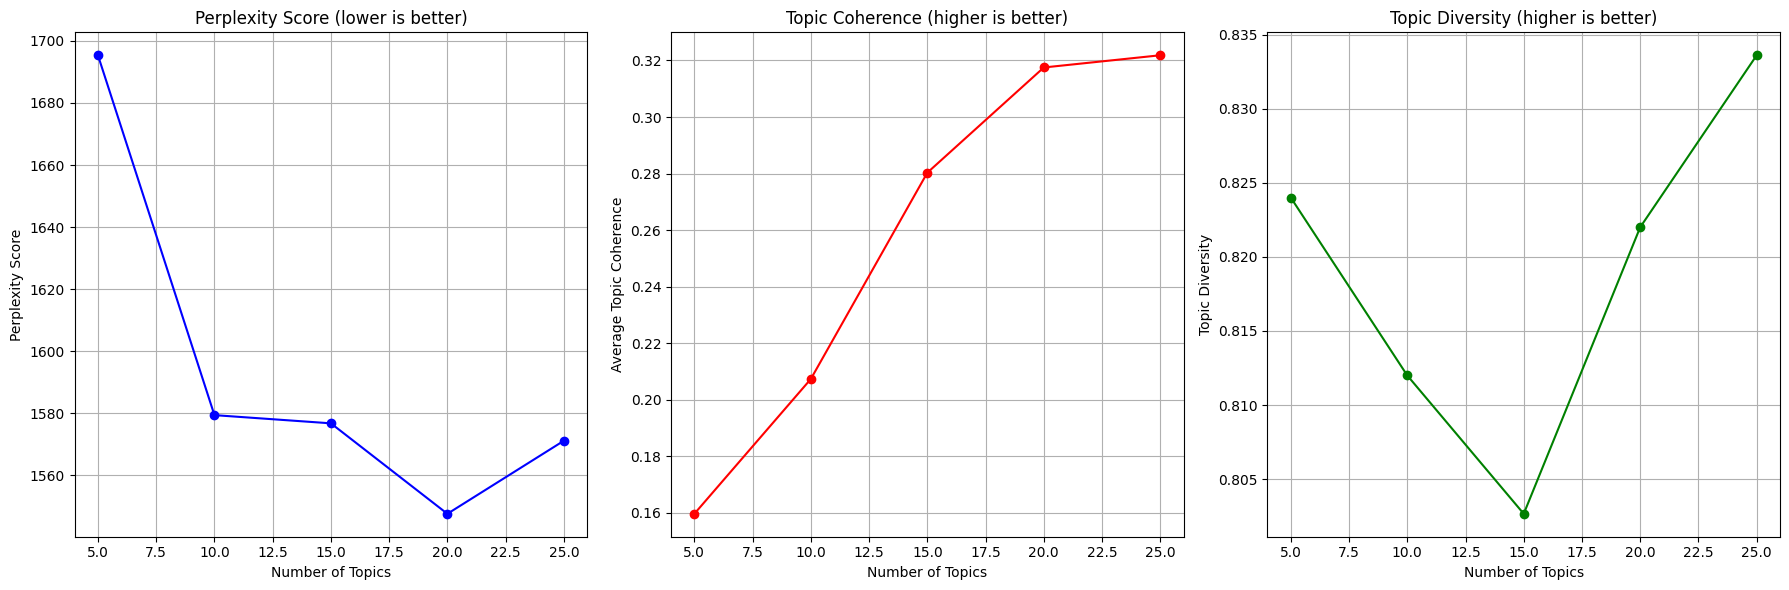

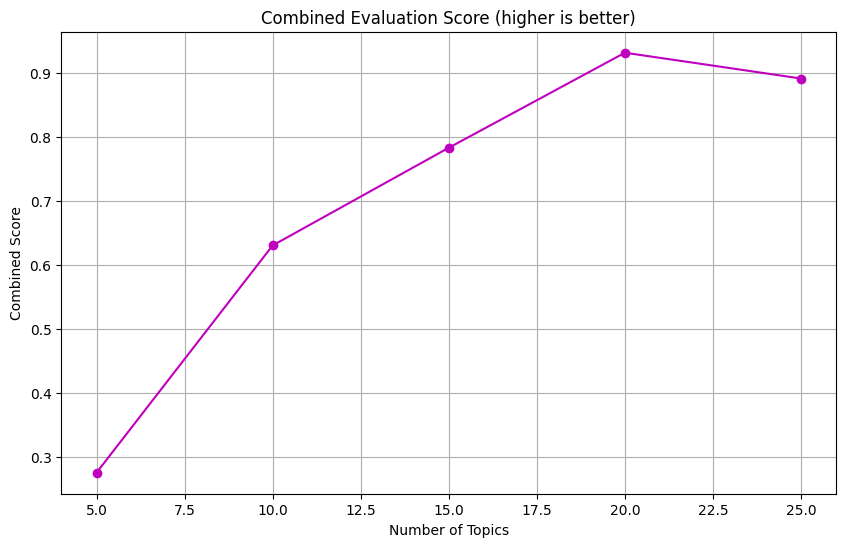


Optimal number of topics based on combined metrics: 20
Training final LDA model with 20 topics...

Top 10 words per topic:
Topic 0: airline flight passenger air rover airport fuel blue chelsea gallas
Topic 1: ireland france italy nation half try irish scotland penalty robinson
Topic 2: site mail net attack virus spam message said website firm
Topic 3: race marathon cross radcliffe ink paula printer km chepkemei cartridge
Topic 4: gaming sony console japan nintendo gamers sale machine handheld developer
Topic 5: drug olympic world test sport domain champion indoor athens european
Topic 6: film award best actor star director oscar year actress movie
Topic 7: year said growth economy rate price sale bank figure month
Topic 8: blog party ukip kilroy silk blogger mr election veritas robert
Topic 9: game year said world time new music number day play
Topic 10: said year mr bn company country new firm government share
Topic 11: said mr people say government bbc new plan public time
Topic 12:

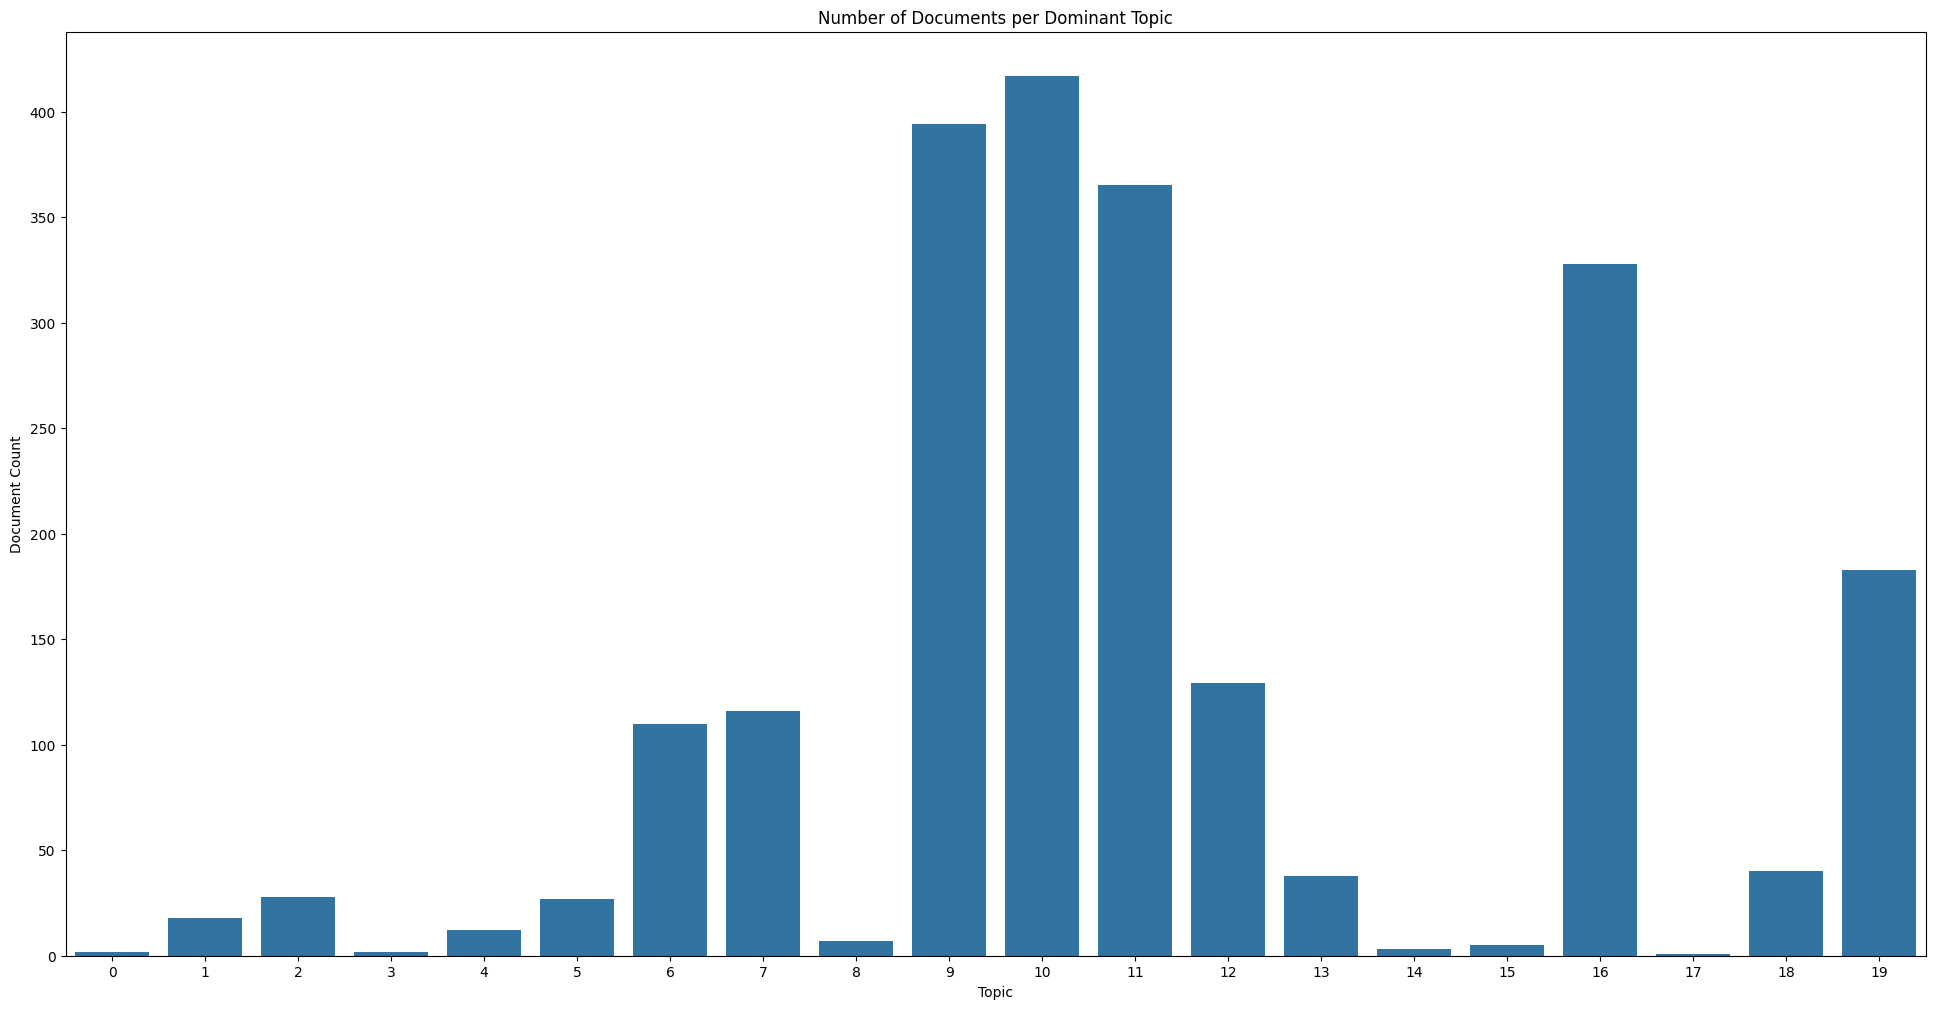

<Figure size 2000x1200 with 0 Axes>

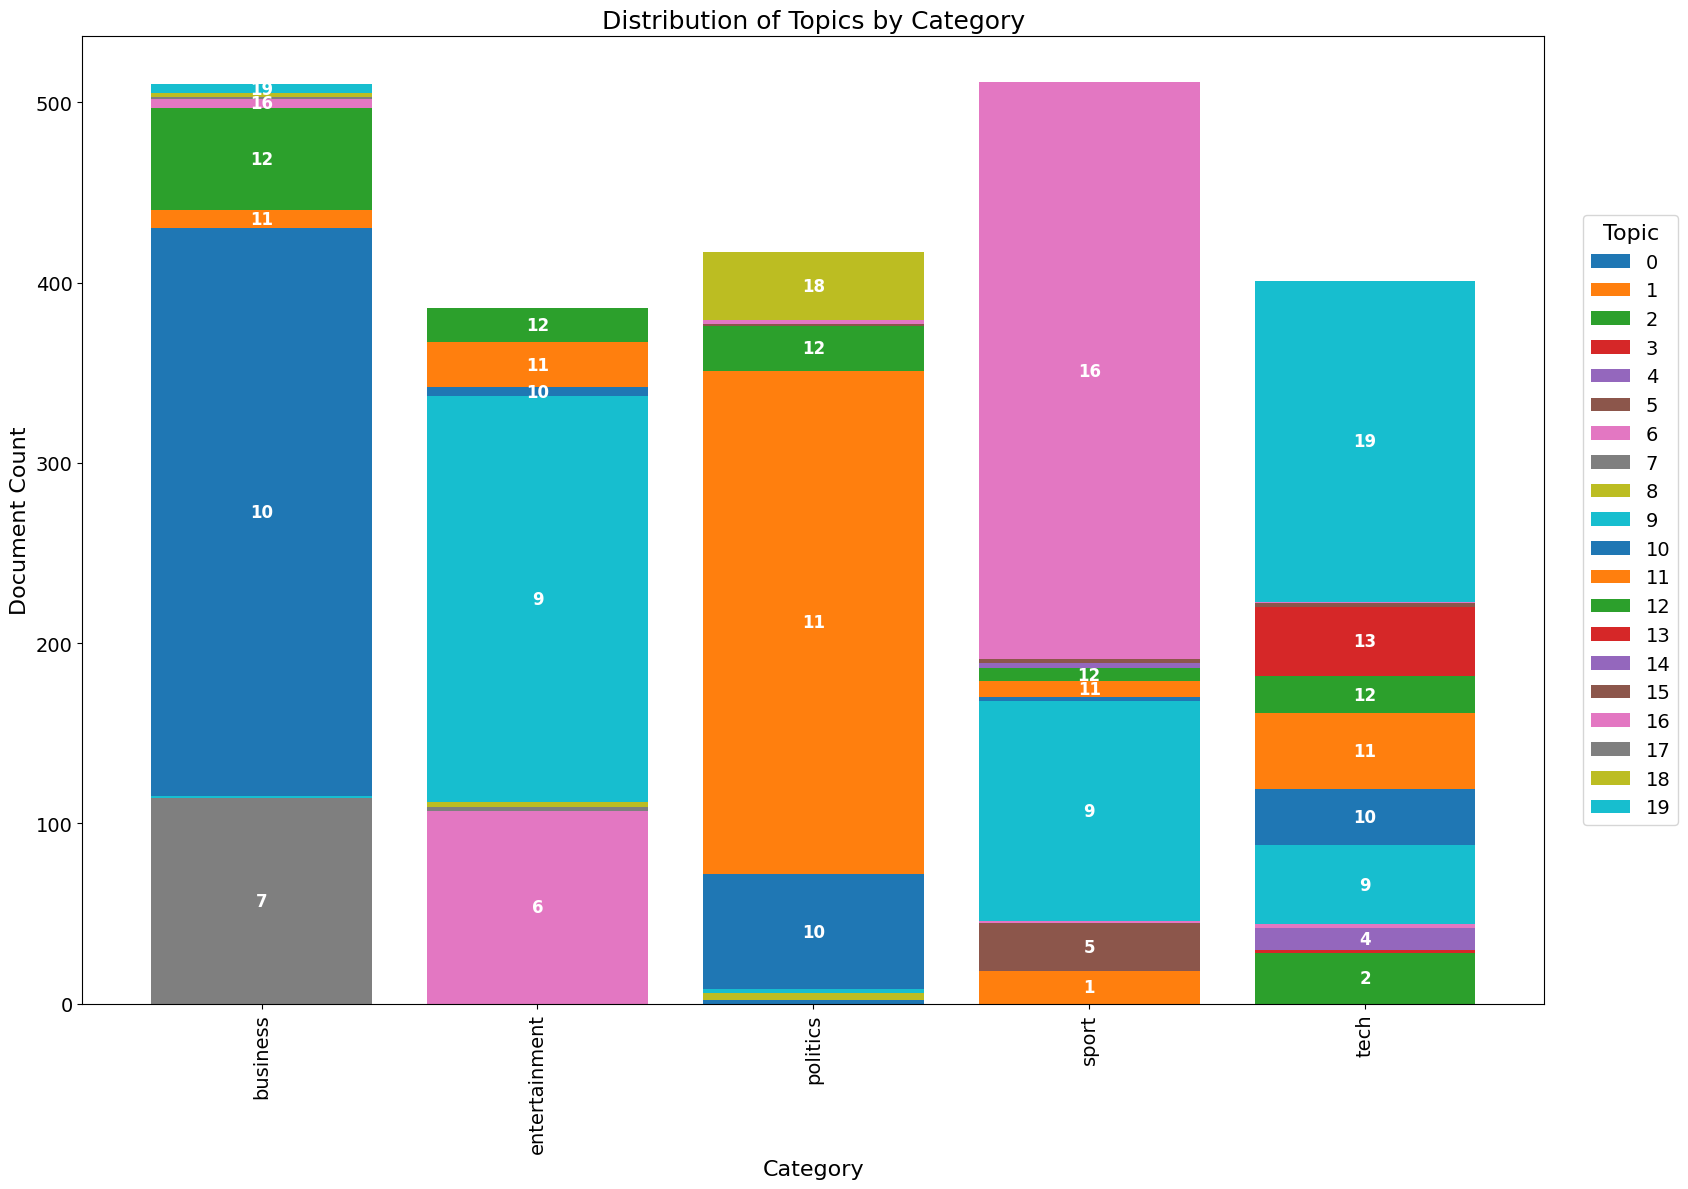

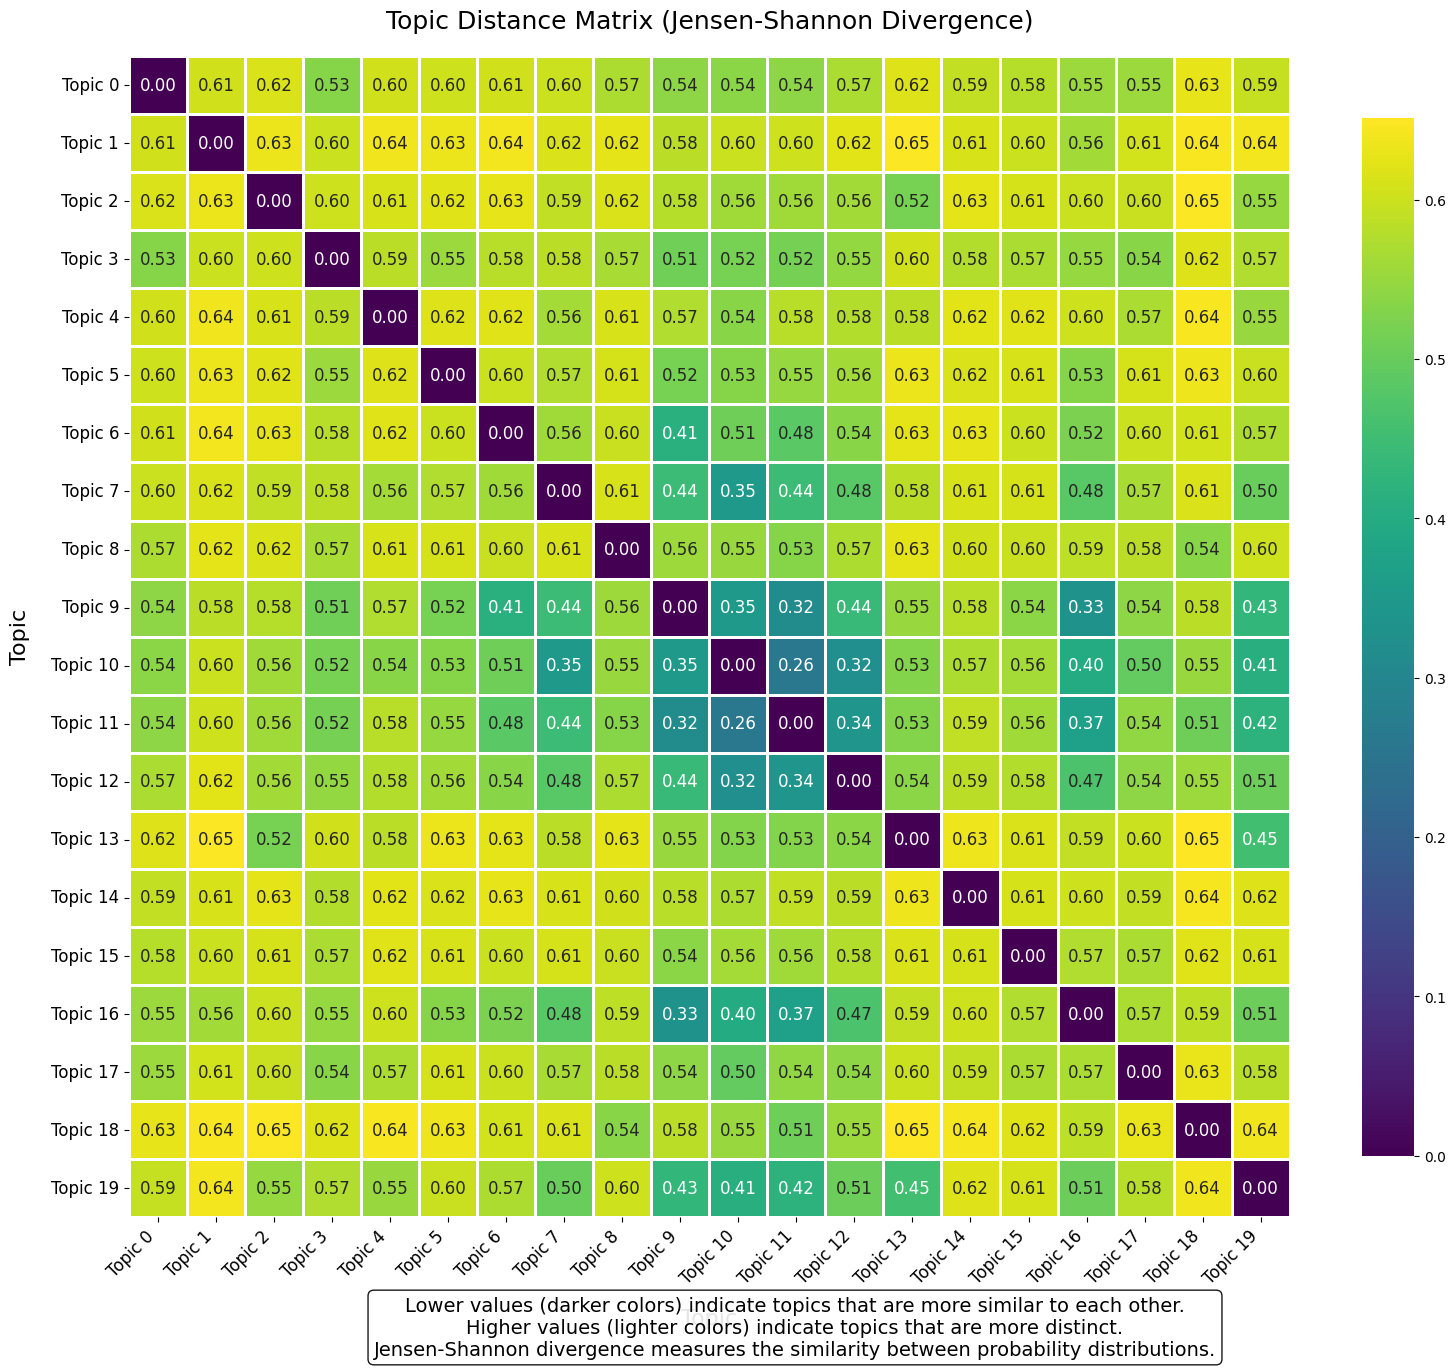


Evaluation Results:
   n_topics   perplexity  avg_coherence  topic_diversity  combined_score
0         5  1695.360805       0.159602         0.824000        0.274667
1        10  1579.443937       0.207304         0.812000        0.630277
2        15  1576.800635       0.280296         0.802667        0.783091
3        20  1547.662816       0.317528         0.822000        0.931787
4        25  1571.192423       0.321850         0.833600        0.891430


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# 1. Prepare text data
documents = df['lemmatized_normalized_text'].tolist()

# 2. Create document-term matrix with CountVectorizer
print("Creating document-term matrix...")
vectorizer = CountVectorizer(
    max_df=0.95,            # Ignore terms that appear in more than 95% of documents
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=5000       # Limit vocabulary size
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# 3. Function to evaluate LDA models with TC and TD metrics
def evaluate_lda_models(X, feature_names, range_topics):
    results = []

    for n_topics in range_topics:
        print(f"Evaluating model with {n_topics} topics...")
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=10,
            learning_method='online',
            learning_offset=50.,
            random_state=42
        )
        lda.fit(X)

        # Calculate metrics
        perplexity = lda.perplexity(X)

        # Topic Coherence - using NPMI-inspired approach
        topic_coherence = calculate_topic_coherence(lda.components_, X, feature_names)
        avg_coherence = np.mean(topic_coherence)

        # Topic Diversity - using term-based approach
        topic_diversity = calculate_topic_diversity(lda.components_)

        results.append({
            'n_topics': n_topics,
            'perplexity': perplexity,
            'avg_coherence': avg_coherence,
            'topic_diversity': topic_diversity
        })

    return pd.DataFrame(results)

# Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):

        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n)

# 4. Try a range of topic numbers
topic_range = range(5, 26, 5)  # [5, 10, 15, 20, 25]
evaluation_results = evaluate_lda_models(X, feature_names, topic_range)

# 5. Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Perplexity plot
axes[0].plot(evaluation_results['n_topics'], evaluation_results['perplexity'], 'bo-')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Perplexity Score')
axes[0].set_title('Perplexity Score (lower is better)')
axes[0].grid(True)

# Topic coherence plot
axes[1].plot(evaluation_results['n_topics'], evaluation_results['avg_coherence'], 'ro-')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Average Topic Coherence')
axes[1].set_title('Topic Coherence (higher is better)')
axes[1].grid(True)

# Topic diversity plot
axes[2].plot(evaluation_results['n_topics'], evaluation_results['topic_diversity'], 'go-')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversity (higher is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 6. Decide on optimal number of topics (simple approach)
# Weight each metric: lower perplexity, higher coherence, higher diversity
normalized_perplexity = 1 - (evaluation_results['perplexity'] - min(evaluation_results['perplexity'])) / (max(evaluation_results['perplexity']) - min(evaluation_results['perplexity']) + 1e-10)
normalized_coherence = (evaluation_results['avg_coherence'] - min(evaluation_results['avg_coherence'])) / (max(evaluation_results['avg_coherence']) - min(evaluation_results['avg_coherence']) + 1e-10)
normalized_diversity = evaluation_results['topic_diversity']

# Combined score (equal weights)
evaluation_results['combined_score'] = (normalized_perplexity + normalized_coherence + normalized_diversity) / 3

# Plot combined score
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['n_topics'], evaluation_results['combined_score'], 'mo-')
plt.xlabel('Number of Topics')
plt.ylabel('Combined Score')
plt.title('Combined Evaluation Score (higher is better)')
plt.grid(True)
plt.show()

# Find optimal number of topics
optimal_topics = evaluation_results.loc[evaluation_results['combined_score'].idxmax(), 'n_topics']
print(f"\nOptimal number of topics based on combined metrics: {optimal_topics}")

# 7. Train the final LDA model
print(f"Training final LDA model with {optimal_topics} topics...")

lda_model = LatentDirichletAllocation(
    n_components=optimal_topics,
    max_iter=25,
    learning_method='online',
    learning_offset=50.,
    random_state=42
)
lda_model.fit(X)

# 8. Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[topic_idx] = topic_words
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topic_dict

print("\nTop 10 words per topic:")
topic_dict = display_topics(lda_model, feature_names, 10)

# 9. Calculate final TC and TD metrics for the optimal model
final_coherence = calculate_topic_coherence(lda_model.components_, X, feature_names)
final_diversity = calculate_topic_diversity(lda_model.components_)

print("\nFinal Topic Coherence scores per topic:")
for i, score in enumerate(final_coherence):
    print(f"Topic {i}: {score:.4f}")
print(f"Average Topic Coherence: {np.mean(final_coherence):.4f}")
print(f"Topic Diversity: {final_diversity:.4f}")

# 10. Visualize document distribution across topics
topic_distribution = lda_model.transform(X)
dominant_topics = np.argmax(topic_distribution, axis=1)

# Count documents per dominant topic
topic_counts = np.bincount(dominant_topics, minlength=optimal_topics)

# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': dominant_topics,
    'category': df['category']
})

# Plot document count by dominant topic
plt.figure(figsize=(24, 12))
sns.countplot(x='dominant_topic', data=topic_df)
plt.title('Number of Documents per Dominant Topic')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.show()

# 11. Analysis by category
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = i
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 12. Topic distance visualization
# Calculate distance between topics using Jensen-Shannon divergence
def js_distance(P, Q):
    """Calculate Jensen-Shannon distance between probability distributions"""
    # Normalize if not already
    P = P / np.sum(P)
    Q = Q / np.sum(Q)
    M = 0.5 * (P + Q)
    return 0.5 * (np.sum(P * np.log(P / M + 1e-10)) + np.sum(Q * np.log(Q / M + 1e-10)))

# Calculate the distance matrix
topic_distances = np.zeros((optimal_topics, optimal_topics))
for i in range(optimal_topics):
    for j in range(i+1, optimal_topics):
        dist = js_distance(lda_model.components_[i], lda_model.components_[j])
        topic_distances[i, j] = dist
        topic_distances[j, i] = dist

plt.figure(figsize=(16, 14))
topic_labels = [f"Topic {i}" for i in range(optimal_topics)]

ax = sns.heatmap(
    topic_distances,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

# Improve the appearance of the plot
plt.title('Topic Distance Matrix (Jensen-Shannon Divergence)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

# Increase the font size of tick labels
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Lower values (darker colors) indicate topics that are more similar to each other.\n"
    "Higher values (lighter colors) indicate topics that are more distinct.\n"
    "Jensen-Shannon divergence measures the similarity between probability distributions.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

# Adjust layout
plt.tight_layout()
plt.show()

print("\nEvaluation Results:")
print(evaluation_results)

# LDA Results

### Metric Performance

- Perplexity: The model achieved a perplexity score of 1547.66 with 20 topics, representing the lowest value across all tested configurations (5-25 topics). This indicates superior predictive performance at this topic count.
- Topic Coherence: The average topic coherence score of 0.284 indicates moderately coherent topics overall. Notable variations in coherence exist between topics, with Topic 3 (marathon/race-related) showing exceptionally high coherence (0.605), while Topic 9 (general terms like "game", "year", "said") displaying lower coherence (0.046). This variability is expected given the diverse content domains.
- Topic Diversity: The model exhibits strong diversity (0.814), indicating minimal redundancy among topics. This suggests that the 20-topic configuration effectively captures distinct thematic elements with limited overlap.

### Topic Analysis
The discovered topics demonstrate clear alignment with typical BBC content categories:

- Well-defined domains: Several topics exhibit clear thematic coherence around specific domains:
1. Sports (Topics 1, 3, 5, 14, 16)
2. Technology (Topics 2, 4, 13, 19)
3. Politics (Topics 8, 18)
4. Business/Economy (Topics 7, 10, 17)
5. Entertainment (Topic 6)

- Topic quality: Higher coherence scores generally correspond to more specialized topics (e.g., Topic 3 on marathons/racing), while lower coherence scores appear in topics containing more generic terms (e.g., Topic 9).

#

# NMF (Non-negative Matrix Factorization)

Creating document-term matrix...
Document-term matrix shape: (2225, 5000)
Evaluating model with 5 topics...
Evaluating model with 10 topics...
Evaluating model with 15 topics...
Evaluating model with 20 topics...
Evaluating model with 25 topics...


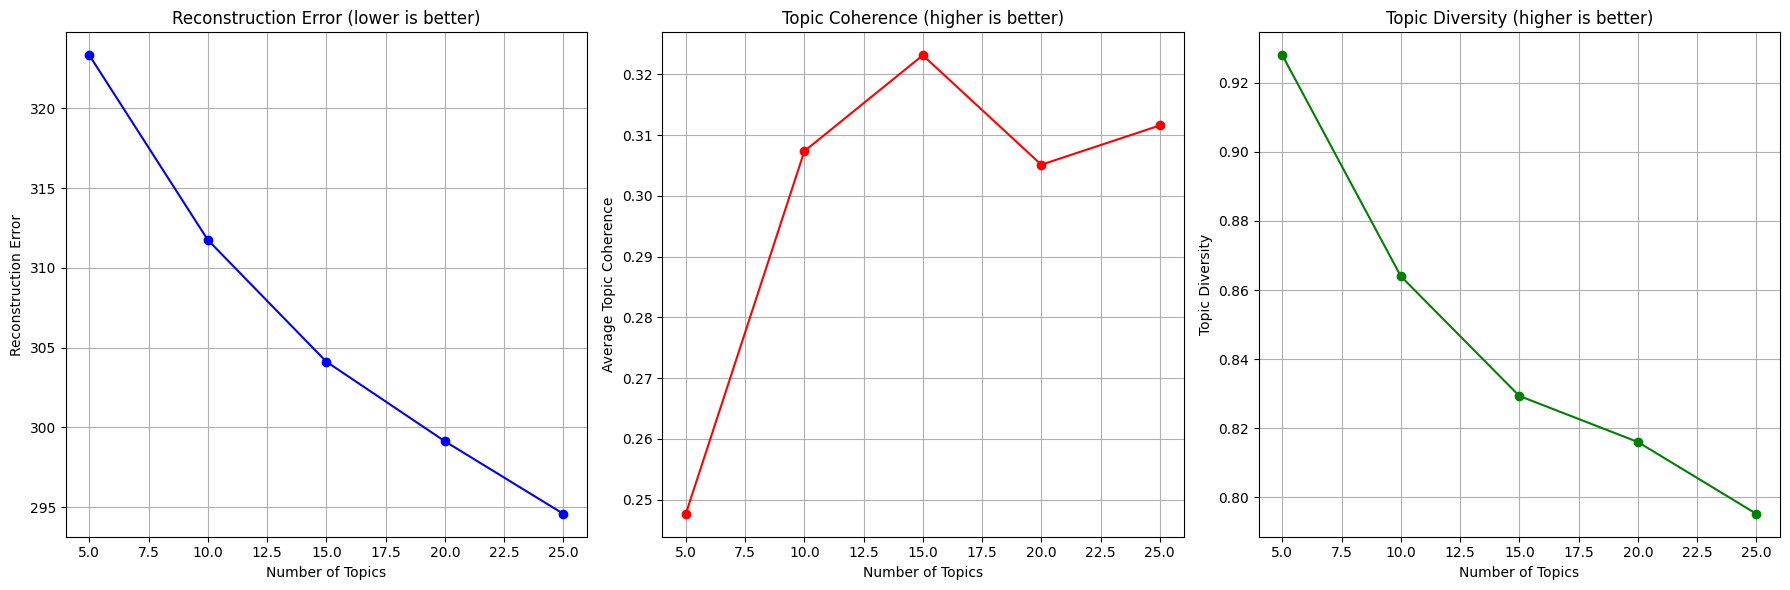

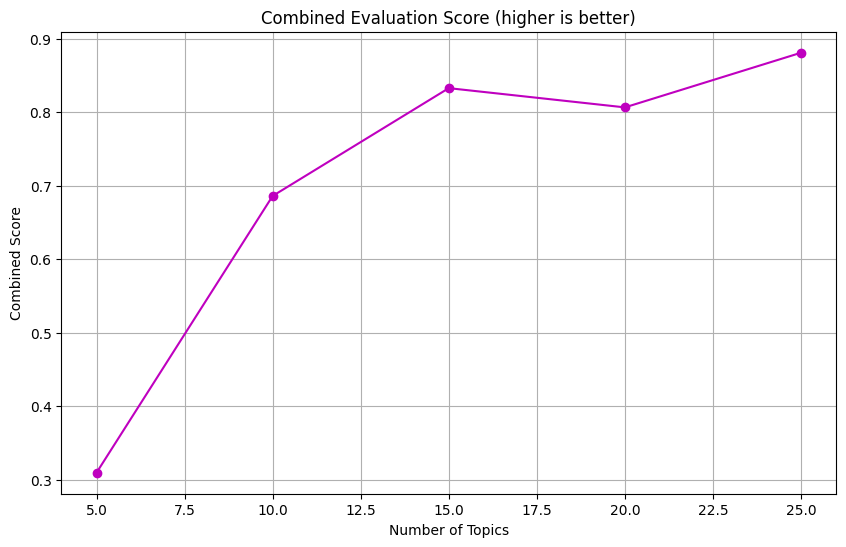


Optimal number of topics based on combined metrics: 25
Training final NMF model with 25 topics...

Top 10 words per topic:
Topic 0: child school people said student university education scottish problem say
Topic 1: election labour party mr tory blair howard brown said campaign
Topic 2: growth economy rate price economic dollar rise market figure year
Topic 3: film star festival movie actor cinema starring musical hollywood tv
Topic 4: mobile phone technology service broadband people digital network net bt
Topic 5: court law yukos police case said mr trial legal lawyer
Topic 6: music band album song chart singer rock single artist pop
Topic 7: mail virus program software site security microsoft user spam attack
Topic 8: drug woman test kenteris athletics iaaf marathon greek athens thanou
Topic 9: england wale ireland rugby robinson france nation game coach scotland
Topic 10: open australian seed final match win roddick beat tennis set
Topic 11: game dvd sony gaming gadget console vide

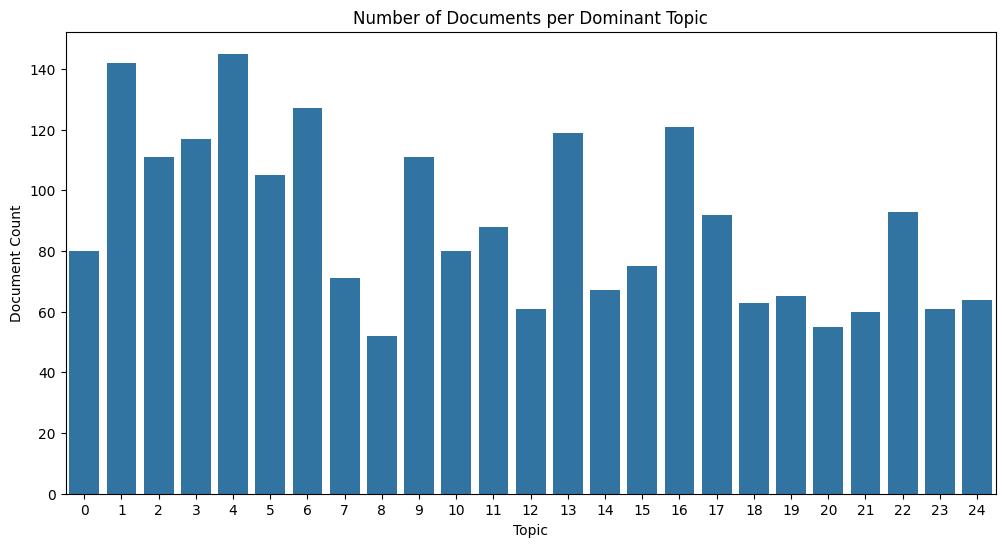

<Figure size 2000x1200 with 0 Axes>

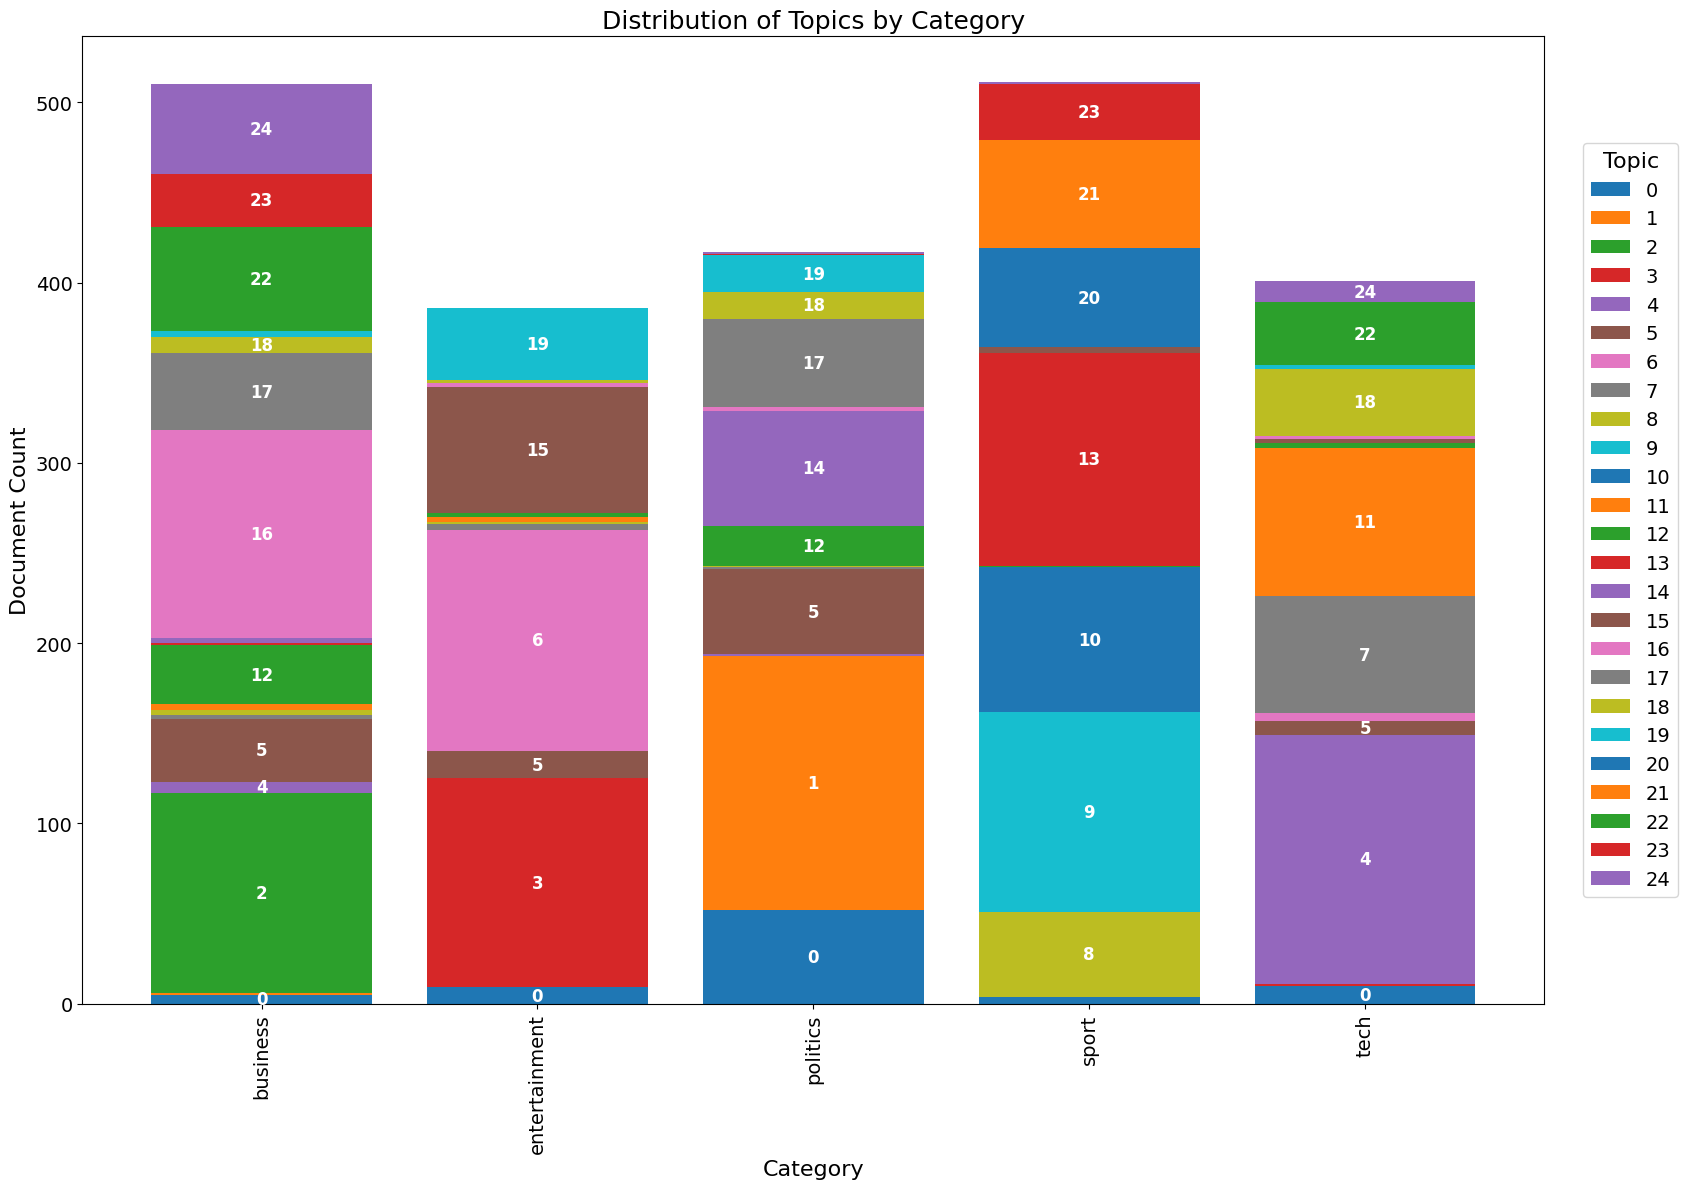

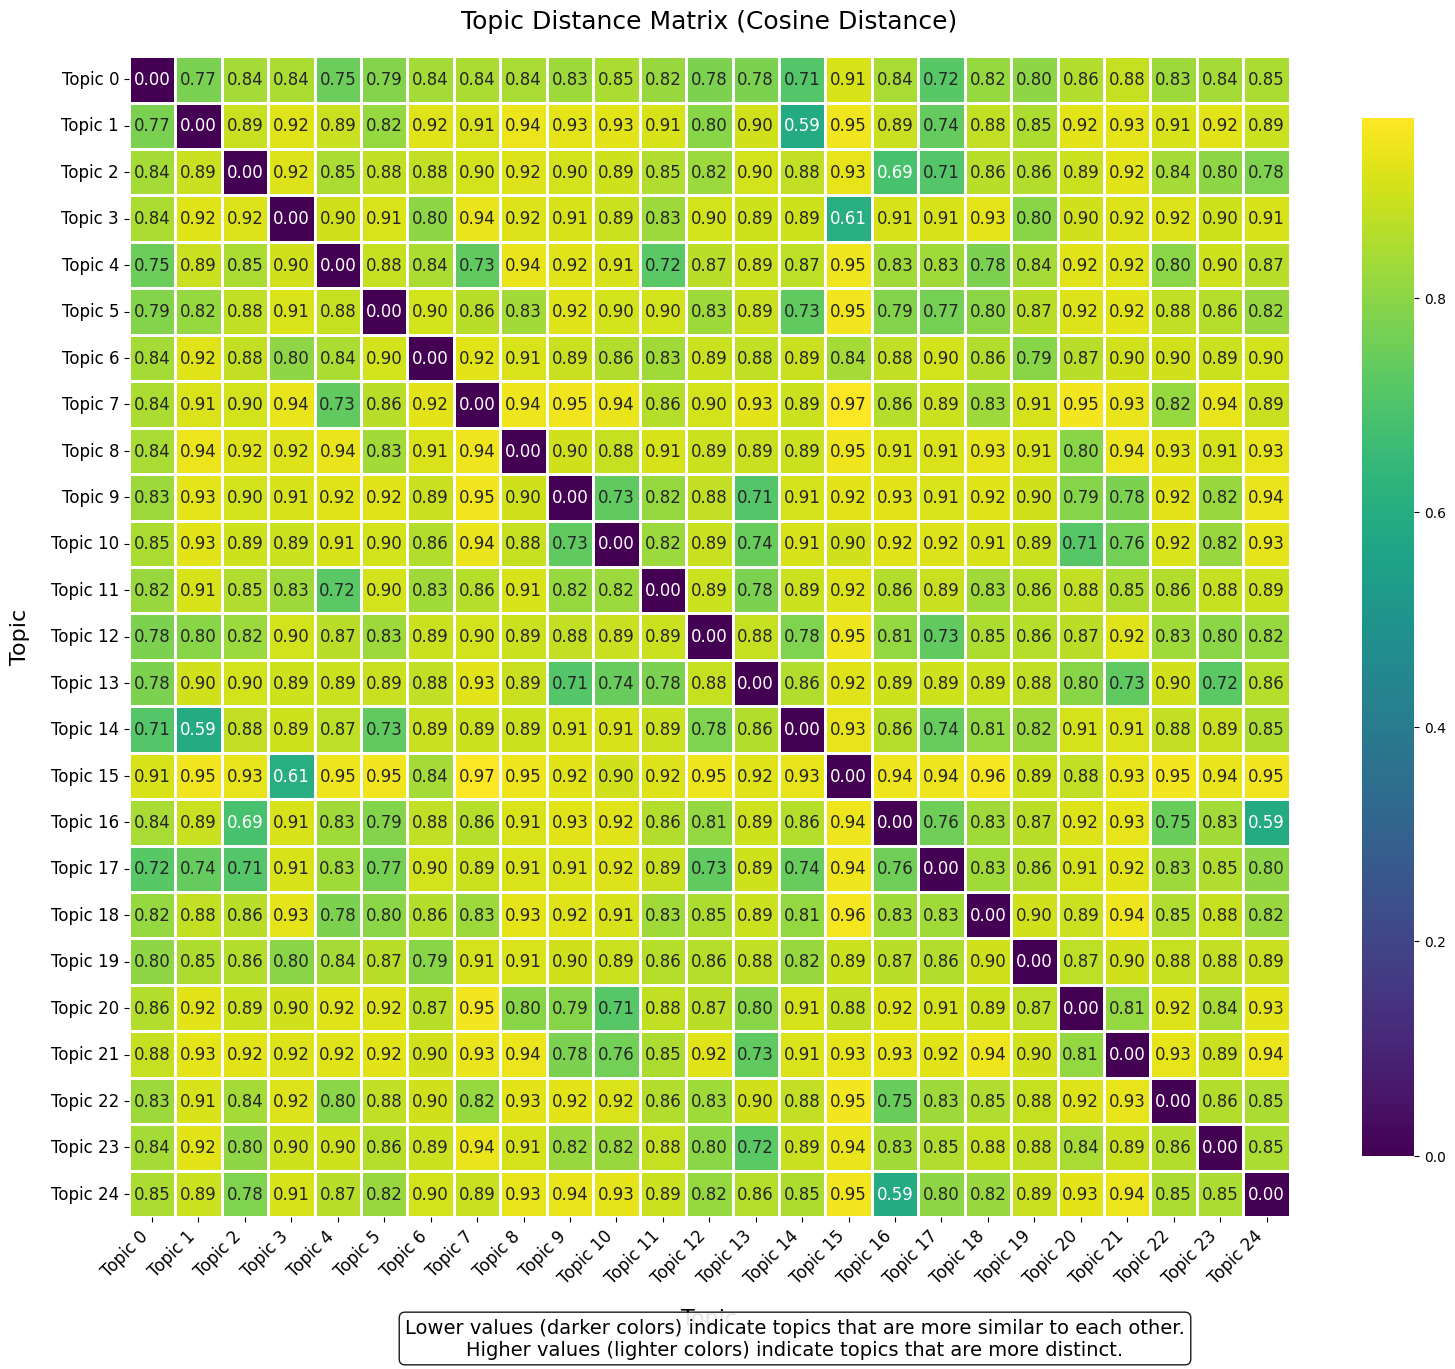


Evaluation Results:
   n_topics  reconstruction_error  avg_coherence  topic_diversity  \
0         5            323.318673       0.247656         0.928000   
1        10            311.745645       0.307356         0.864000   
2        15            304.118781       0.323151         0.829333   
3        20            299.132140       0.305129         0.816000   
4        25            294.584700       0.311593         0.795200   

   combined_score  
0        0.309333  
1        0.685849  
2        0.832509  
3        0.806341  
4        0.880701  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

# 1. Prepare text data
df = pd.read_csv("_data/2_Medium_BBC_dataset/bbc_dataset_preprocessed.csv")
documents = df['lemmatized_normalized_text'].tolist()

# 2. Create document-term matrix with TfidfVectorizer (common for NMF)
print("Creating document-term matrix...")
vectorizer = TfidfVectorizer(
    max_df=0.95,    # Ignore terms that appear in more than 95% of documents
    min_df=2,       # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=5000  # Limit vocabulary size
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# 3. Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):
        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n)

# 4. Function to evaluate NMF models with TC and TD metrics
def evaluate_nmf_models(X, feature_names, range_topics):
    results = []

    for n_topics in range_topics:
        print(f"Evaluating model with {n_topics} topics...")
        nmf = NMF(
            n_components=n_topics,
            random_state=42,
            beta_loss='kullback-leibler',
            solver='mu'
        )
        W = nmf.fit_transform(X)  # Document-topic matrix
        H = nmf.components_      # Topic-term matrix

        # Calculate reconstruction error
        error = nmf.reconstruction_err_

        # Topic Coherence - using NPMI-inspired approach
        topic_coherence = calculate_topic_coherence(H, X, feature_names)
        avg_coherence = np.mean(topic_coherence)

        # Topic Diversity - using term-based approach
        topic_diversity = calculate_topic_diversity(H)

        results.append({
            'n_topics': n_topics,
            'reconstruction_error': error,
            'avg_coherence': avg_coherence,
            'topic_diversity': topic_diversity
        })

    return pd.DataFrame(results)

# 5. Try a range of topic numbers
topic_range = range(5, 26, 5)  # [5, 10, 15, 20, 25]
evaluation_results = evaluate_nmf_models(X, feature_names, topic_range)

# 6. Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Reconstruction error plot
axes[0].plot(evaluation_results['n_topics'], evaluation_results['reconstruction_error'], 'bo-')
axes[0].set_xlabel('Number of Topics')
axes[0].set_ylabel('Reconstruction Error')
axes[0].set_title('Reconstruction Error (lower is better)')
axes[0].grid(True)

# Topic coherence plot
axes[1].plot(evaluation_results['n_topics'], evaluation_results['avg_coherence'], 'ro-')
axes[1].set_xlabel('Number of Topics')
axes[1].set_ylabel('Average Topic Coherence')
axes[1].set_title('Topic Coherence (higher is better)')
axes[1].grid(True)

# Topic diversity plot
axes[2].plot(evaluation_results['n_topics'], evaluation_results['topic_diversity'], 'go-')
axes[2].set_xlabel('Number of Topics')
axes[2].set_ylabel('Topic Diversity')
axes[2].set_title('Topic Diversity (higher is better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 7. Decide on optimal number of topics (simple approach)
# Weight each metric: lower error, higher coherence, higher diversity
normalized_error = 1 - (evaluation_results['reconstruction_error'] - min(evaluation_results['reconstruction_error'])) / (max(evaluation_results['reconstruction_error']) - min(evaluation_results['reconstruction_error']) + 1e-10)
normalized_coherence = (evaluation_results['avg_coherence'] - min(evaluation_results['avg_coherence'])) / (max(evaluation_results['avg_coherence']) - min(evaluation_results['avg_coherence']) + 1e-10)
normalized_diversity = evaluation_results['topic_diversity']

# Combined score (equal weights)
evaluation_results['combined_score'] = (normalized_error + normalized_coherence + normalized_diversity) / 3

# Plot combined score
plt.figure(figsize=(10, 6))
plt.plot(evaluation_results['n_topics'], evaluation_results['combined_score'], 'mo-')
plt.xlabel('Number of Topics')
plt.ylabel('Combined Score')
plt.title('Combined Evaluation Score (higher is better)')
plt.grid(True)
plt.show()

# Find optimal number of topics
optimal_topics = evaluation_results.loc[evaluation_results['combined_score'].idxmax(), 'n_topics']
print(f"\nOptimal number of topics based on combined metrics: {optimal_topics}")

# 8. Train the final NMF model
print(f"Training final NMF model with {optimal_topics} topics...")

nmf_model = NMF(
    n_components=optimal_topics,
    random_state=42,
    beta_loss='kullback-leibler',
    solver='mu'
)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

# 9. Display top words for each topic
def display_topics(model_components, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model_components):
        topic_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[topic_idx] = topic_words
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topic_dict

print("\nTop 10 words per topic:")
topic_dict = display_topics(H, feature_names, 10)

# 10. Calculate final TC and TD metrics for the optimal model
final_coherence = calculate_topic_coherence(H, X, feature_names)
final_diversity = calculate_topic_diversity(H)

print("\nFinal Topic Coherence scores per topic:")
for i, score in enumerate(final_coherence):
    print(f"Topic {i}: {score:.4f}")
print(f"Average Topic Coherence: {np.mean(final_coherence):.4f}")
print(f"Topic Diversity: {final_diversity:.4f}")

# 11. Visualize document distribution across topics
# For NMF, we take the highest weighted topic for each document as the dominant topic
dominant_topics = np.argmax(W, axis=1)

# Count documents per dominant topic
topic_counts = np.bincount(dominant_topics, minlength=optimal_topics)

# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': dominant_topics,
    'category': df['category']
})

# Plot document count by dominant topic
plt.figure(figsize=(12, 6))
sns.countplot(x='dominant_topic', data=topic_df)
plt.title('Number of Documents per Dominant Topic')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.show()

# 12. Analysis by category with topic numbers on bars
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = i
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 13. Topic distance visualization
# Calculate distance between topics using cosine distance (appropriate for NMF)
topic_distances = cosine_distances(H)
plt.figure(figsize=(16, 14))

# Custom labels for the axes that include "Topic X"
topic_labels = [f"Topic {i}" for i in range(len(topic_distances))]

ax = sns.heatmap(
    topic_distances,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

plt.title('Topic Distance Matrix (Cosine Distance)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Lower values (darker colors) indicate topics that are more similar to each other.\n"
    "Higher values (lighter colors) indicate topics that are more distinct.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()

# Display the evaluation table
print("\nEvaluation Results:")
print(evaluation_results)

# Top2Vec

In [ ]:
!pip install top2vec

Restart the kernel if you get this error:

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Evaluating Top2Vec models with different parameters...


2025-04-21 20:34:42,474 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


Training model with min_count=10, n_neighbors=5...


2025-04-21 20:34:44,693 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-21 20:37:07,349 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-04-21 20:37:13,350 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-04-21 20:37:13,412 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2025-04-21 20:37:16,115 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


  Found 31 topics
  Avg coherence: 0.5369
  Topic diversity: 0.9419
Training model with min_count=10, n_neighbors=15...


2025-04-21 20:37:17,497 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-21 20:39:39,952 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-04-21 20:39:53,408 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-04-21 20:39:53,517 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2025-04-21 20:39:54,189 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


  Found 6 topics
  Avg coherence: 0.5684
  Topic diversity: 0.9867
Training model with min_count=20, n_neighbors=5...


2025-04-21 20:39:55,801 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-21 20:41:40,743 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-04-21 20:41:47,862 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-04-21 20:41:47,933 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics
2025-04-21 20:41:50,466 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training


  Found 33 topics
  Avg coherence: 0.4872
  Topic diversity: 0.8885
Training model with min_count=20, n_neighbors=15...


2025-04-21 20:41:51,321 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-04-21 20:43:27,416 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-04-21 20:43:35,152 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-04-21 20:43:35,207 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


  Found 6 topics
  Avg coherence: 0.5391
  Topic diversity: 0.9667


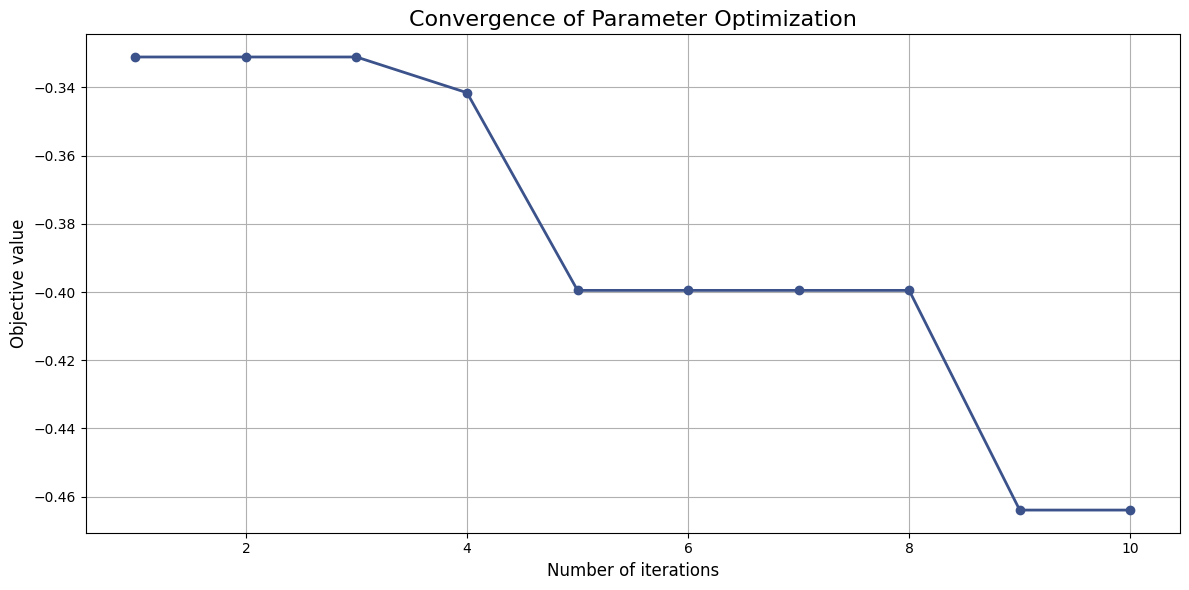

<Figure size 1600x1200 with 0 Axes>

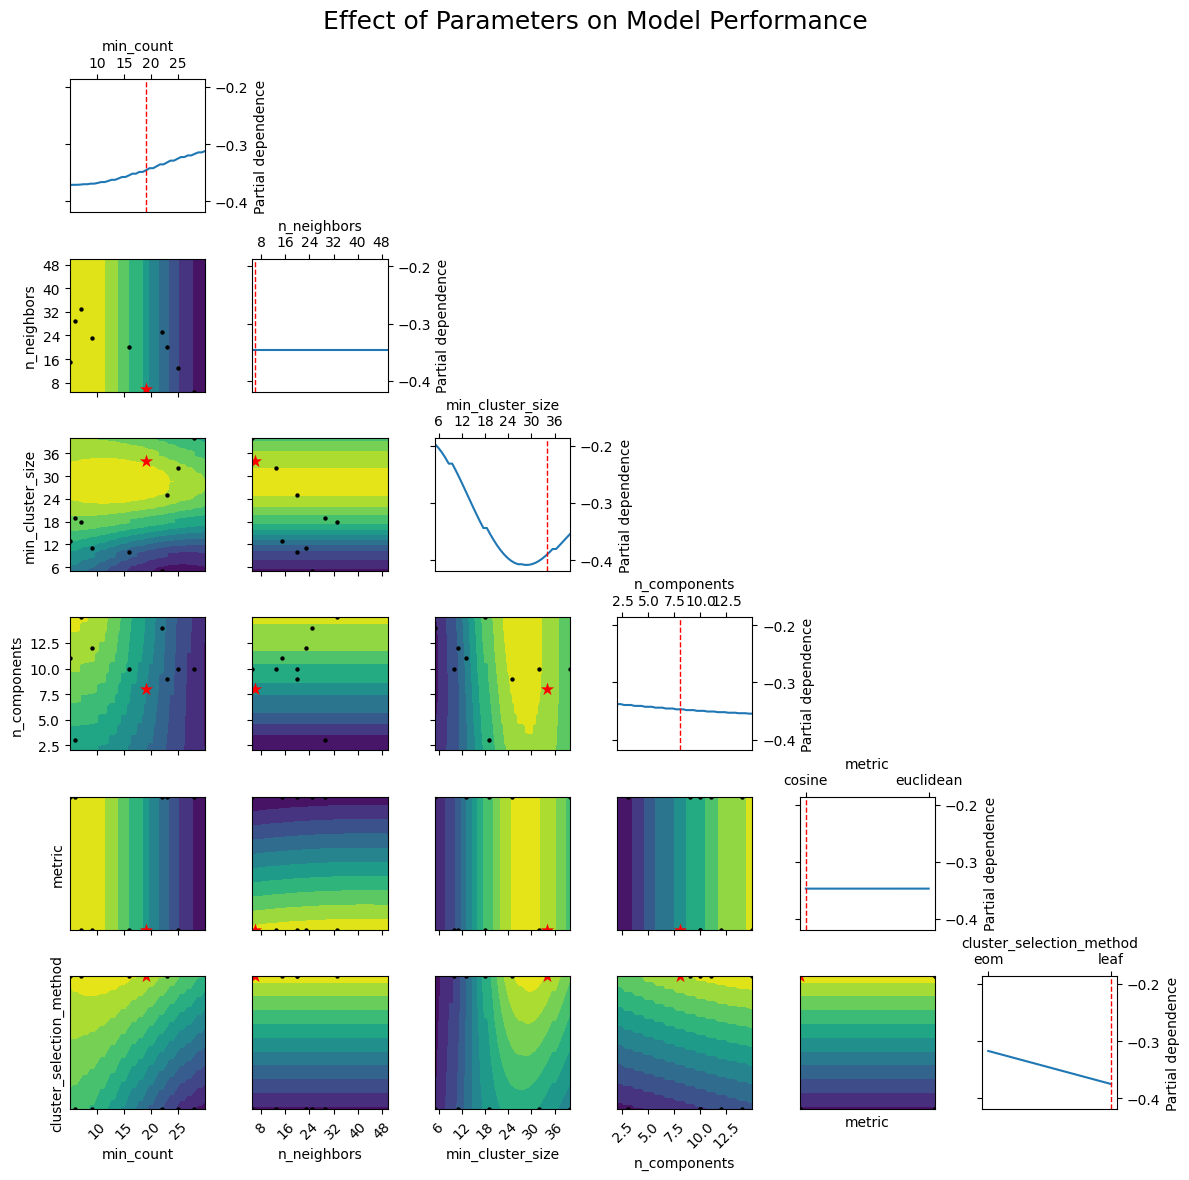

<Figure size 1600x1200 with 0 Axes>

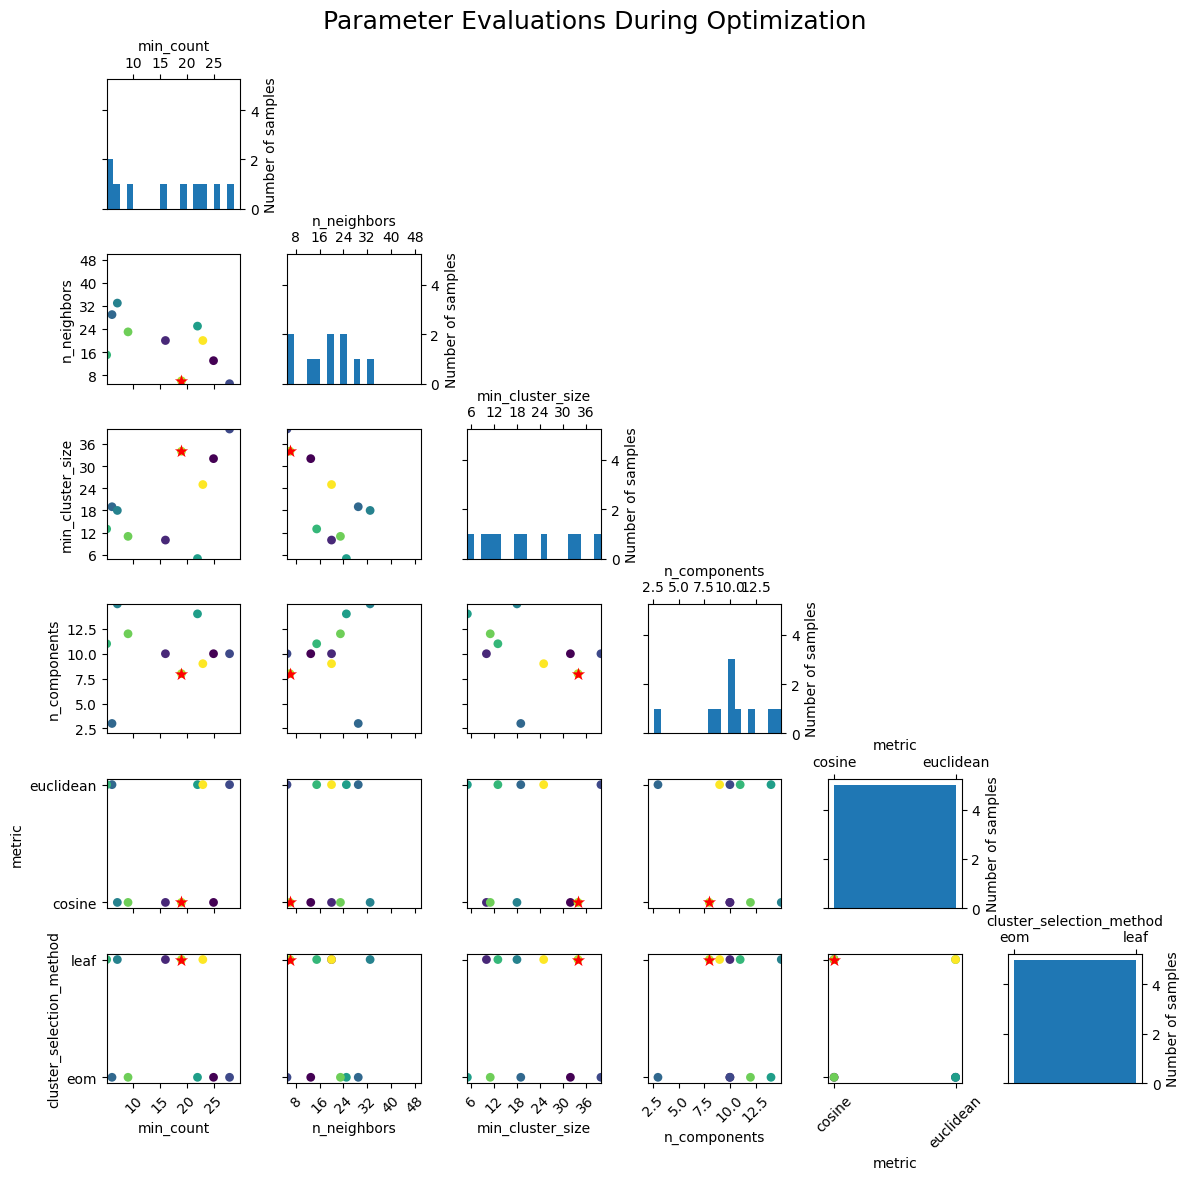

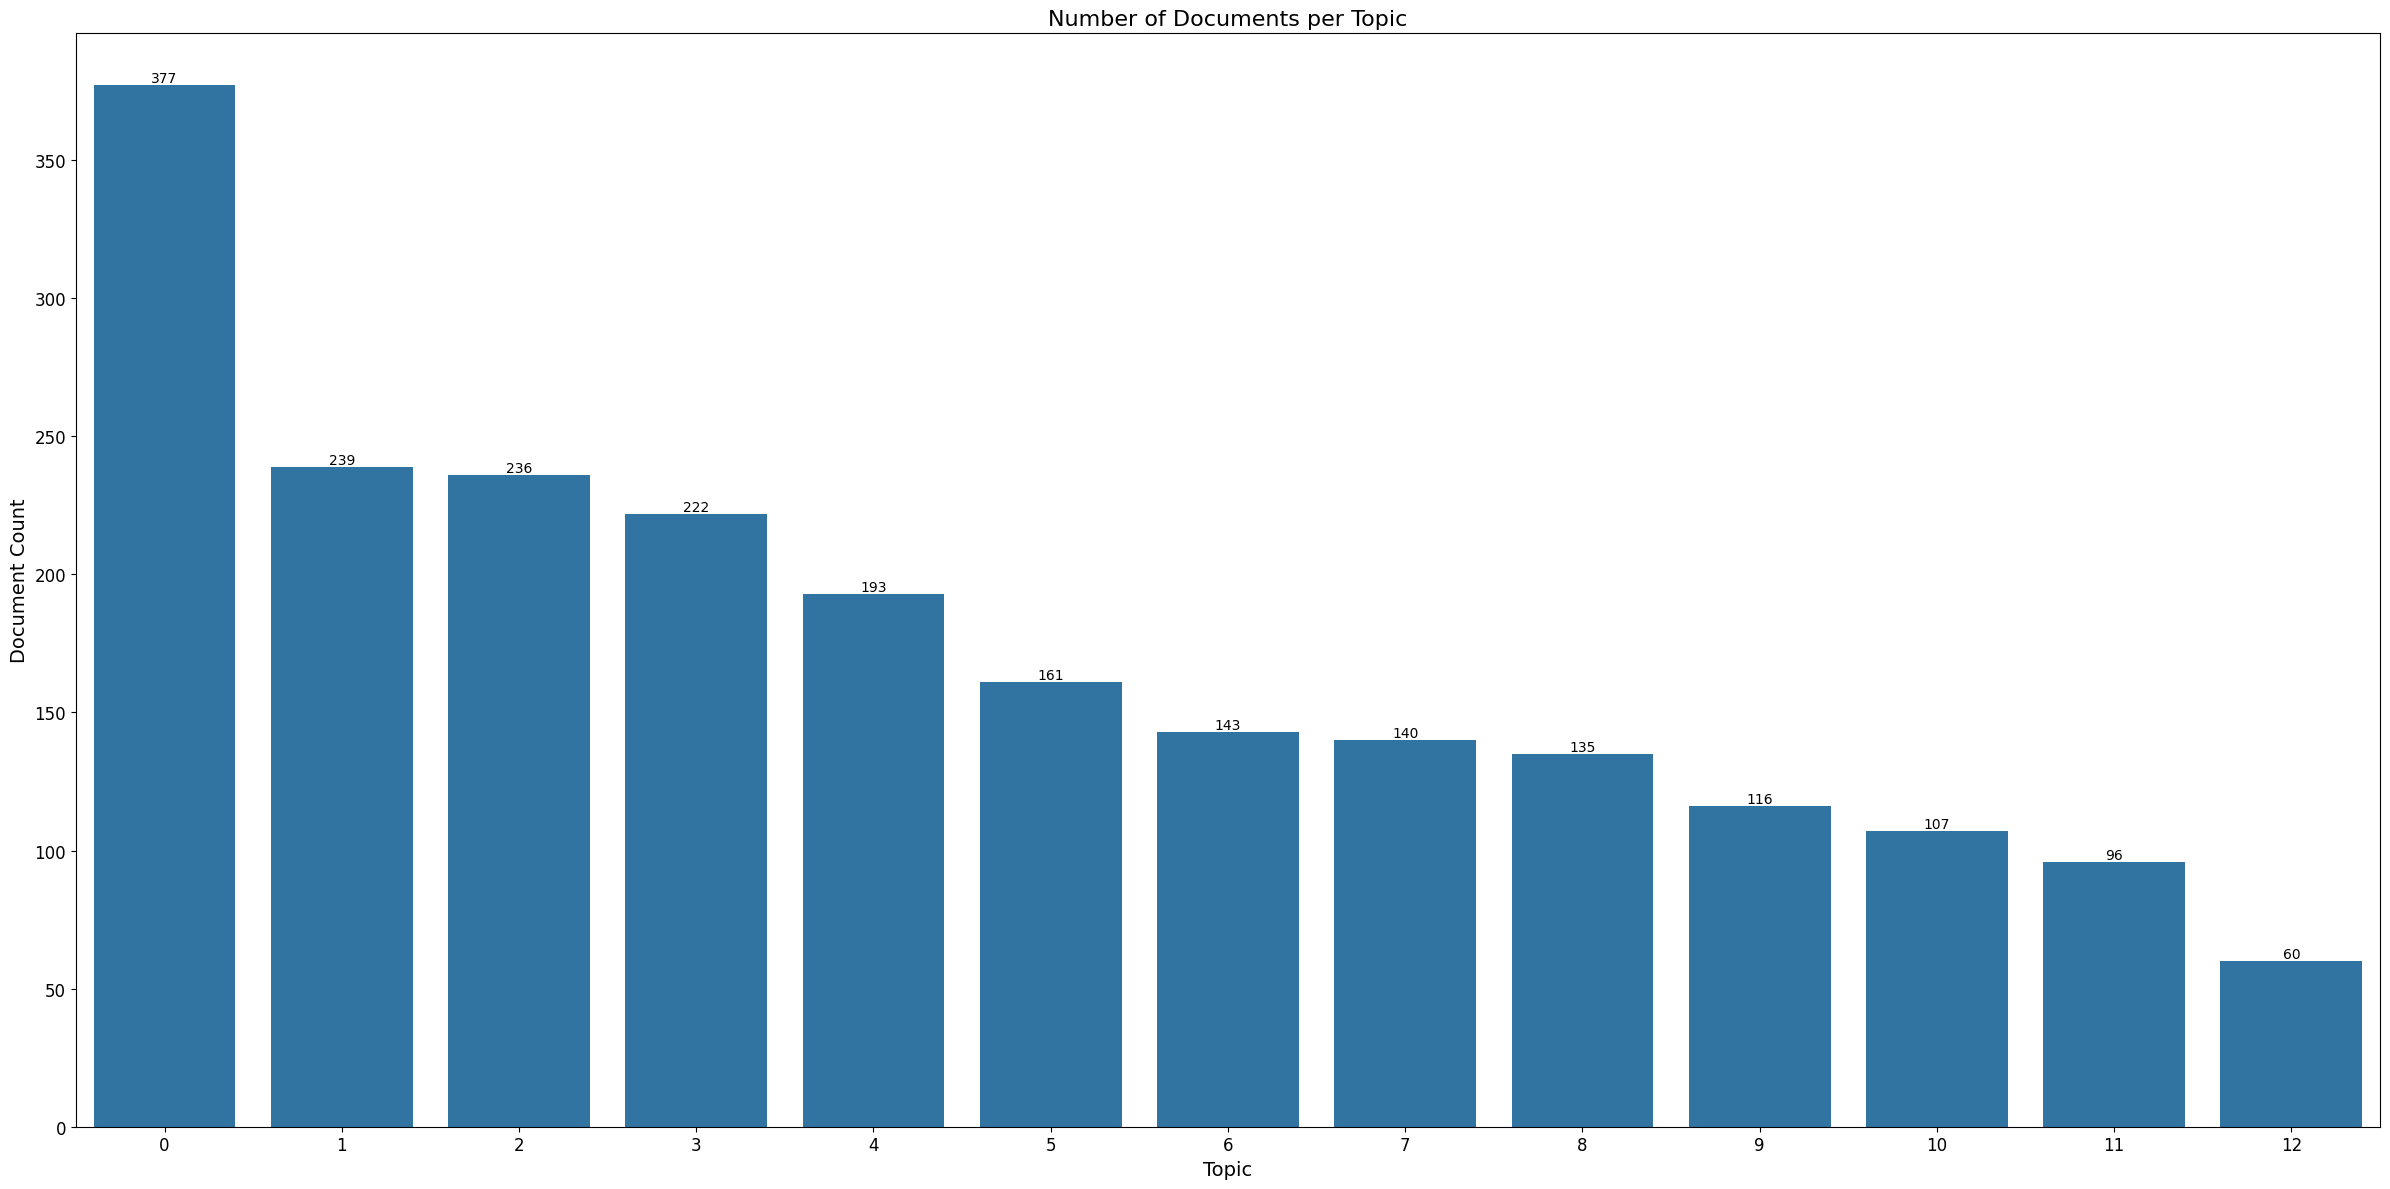

<Figure size 2000x1200 with 0 Axes>

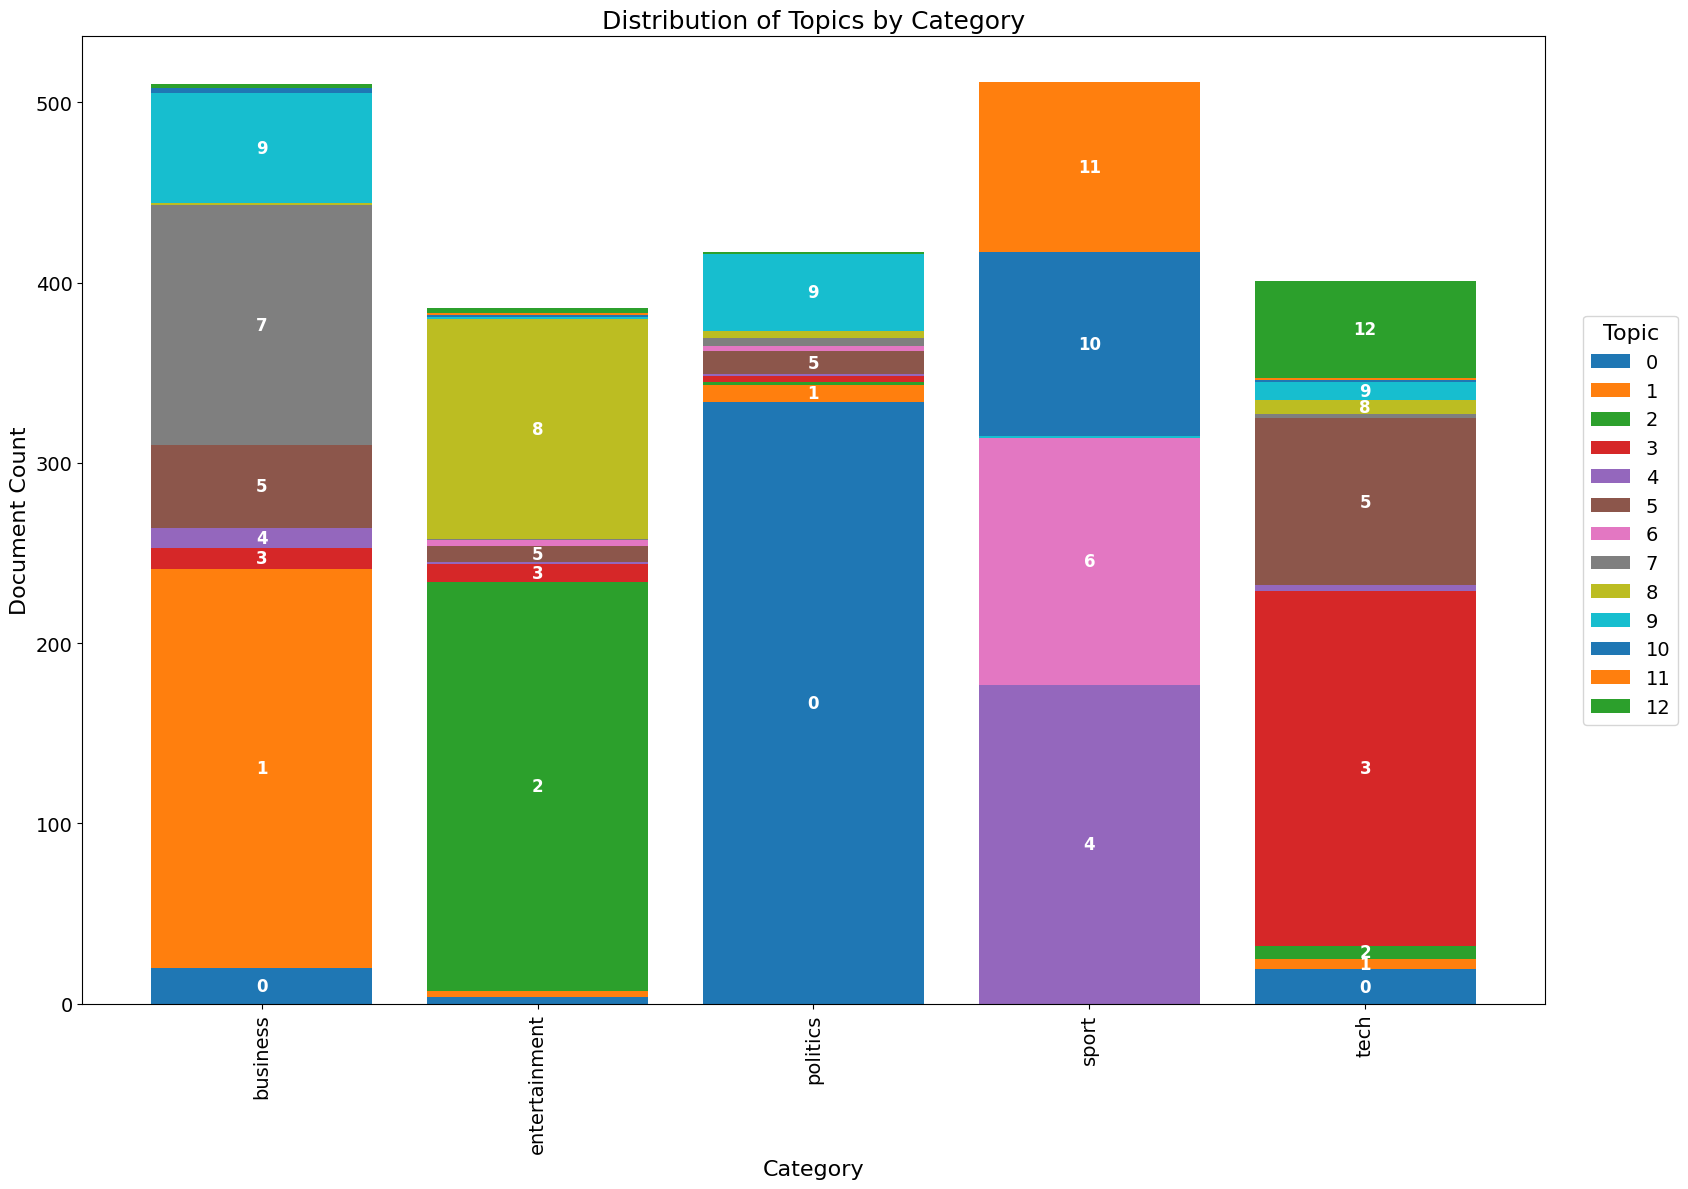

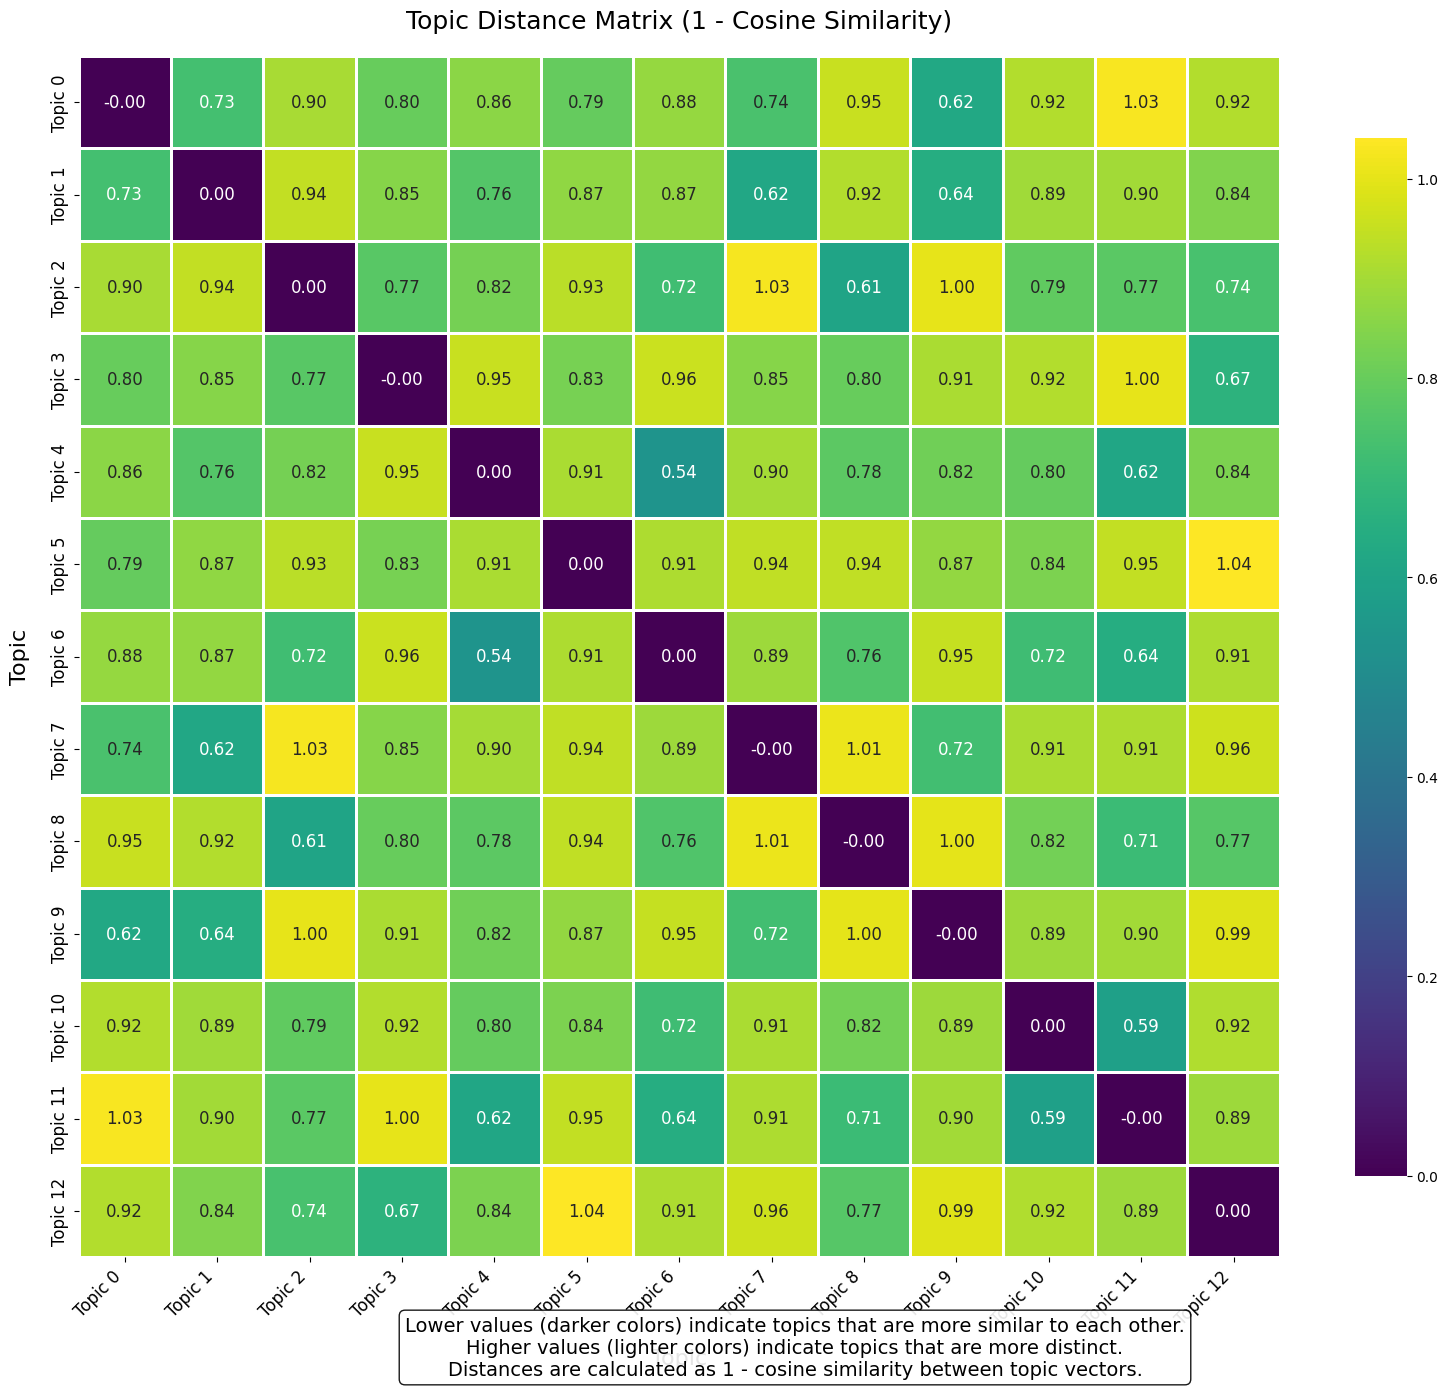

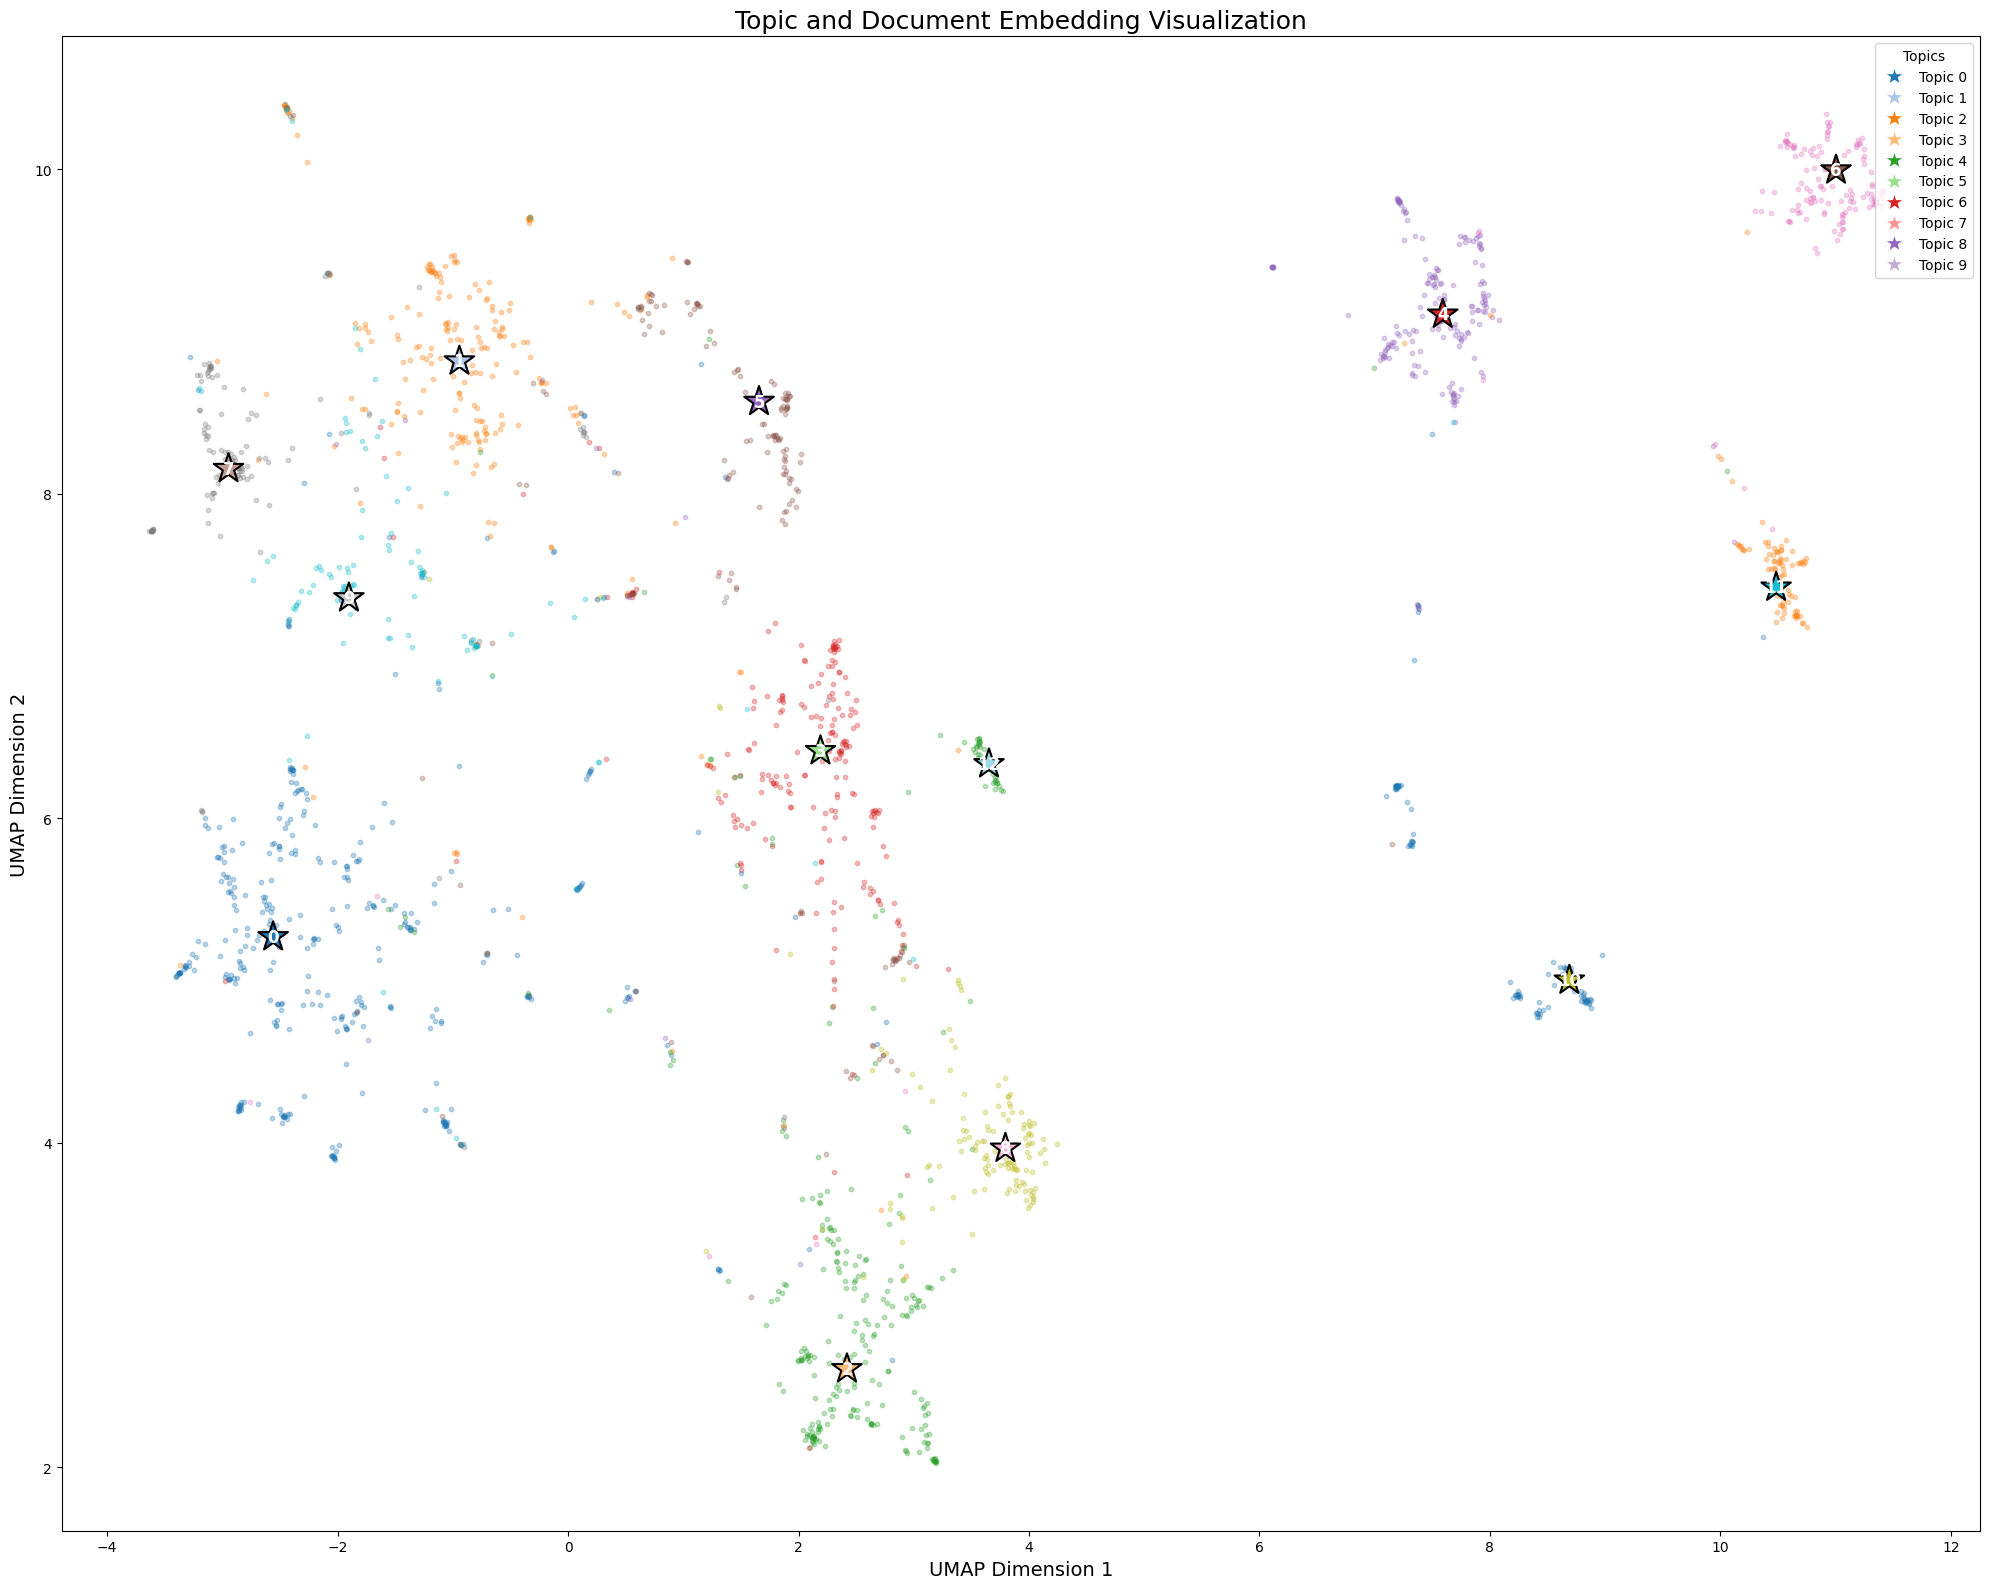

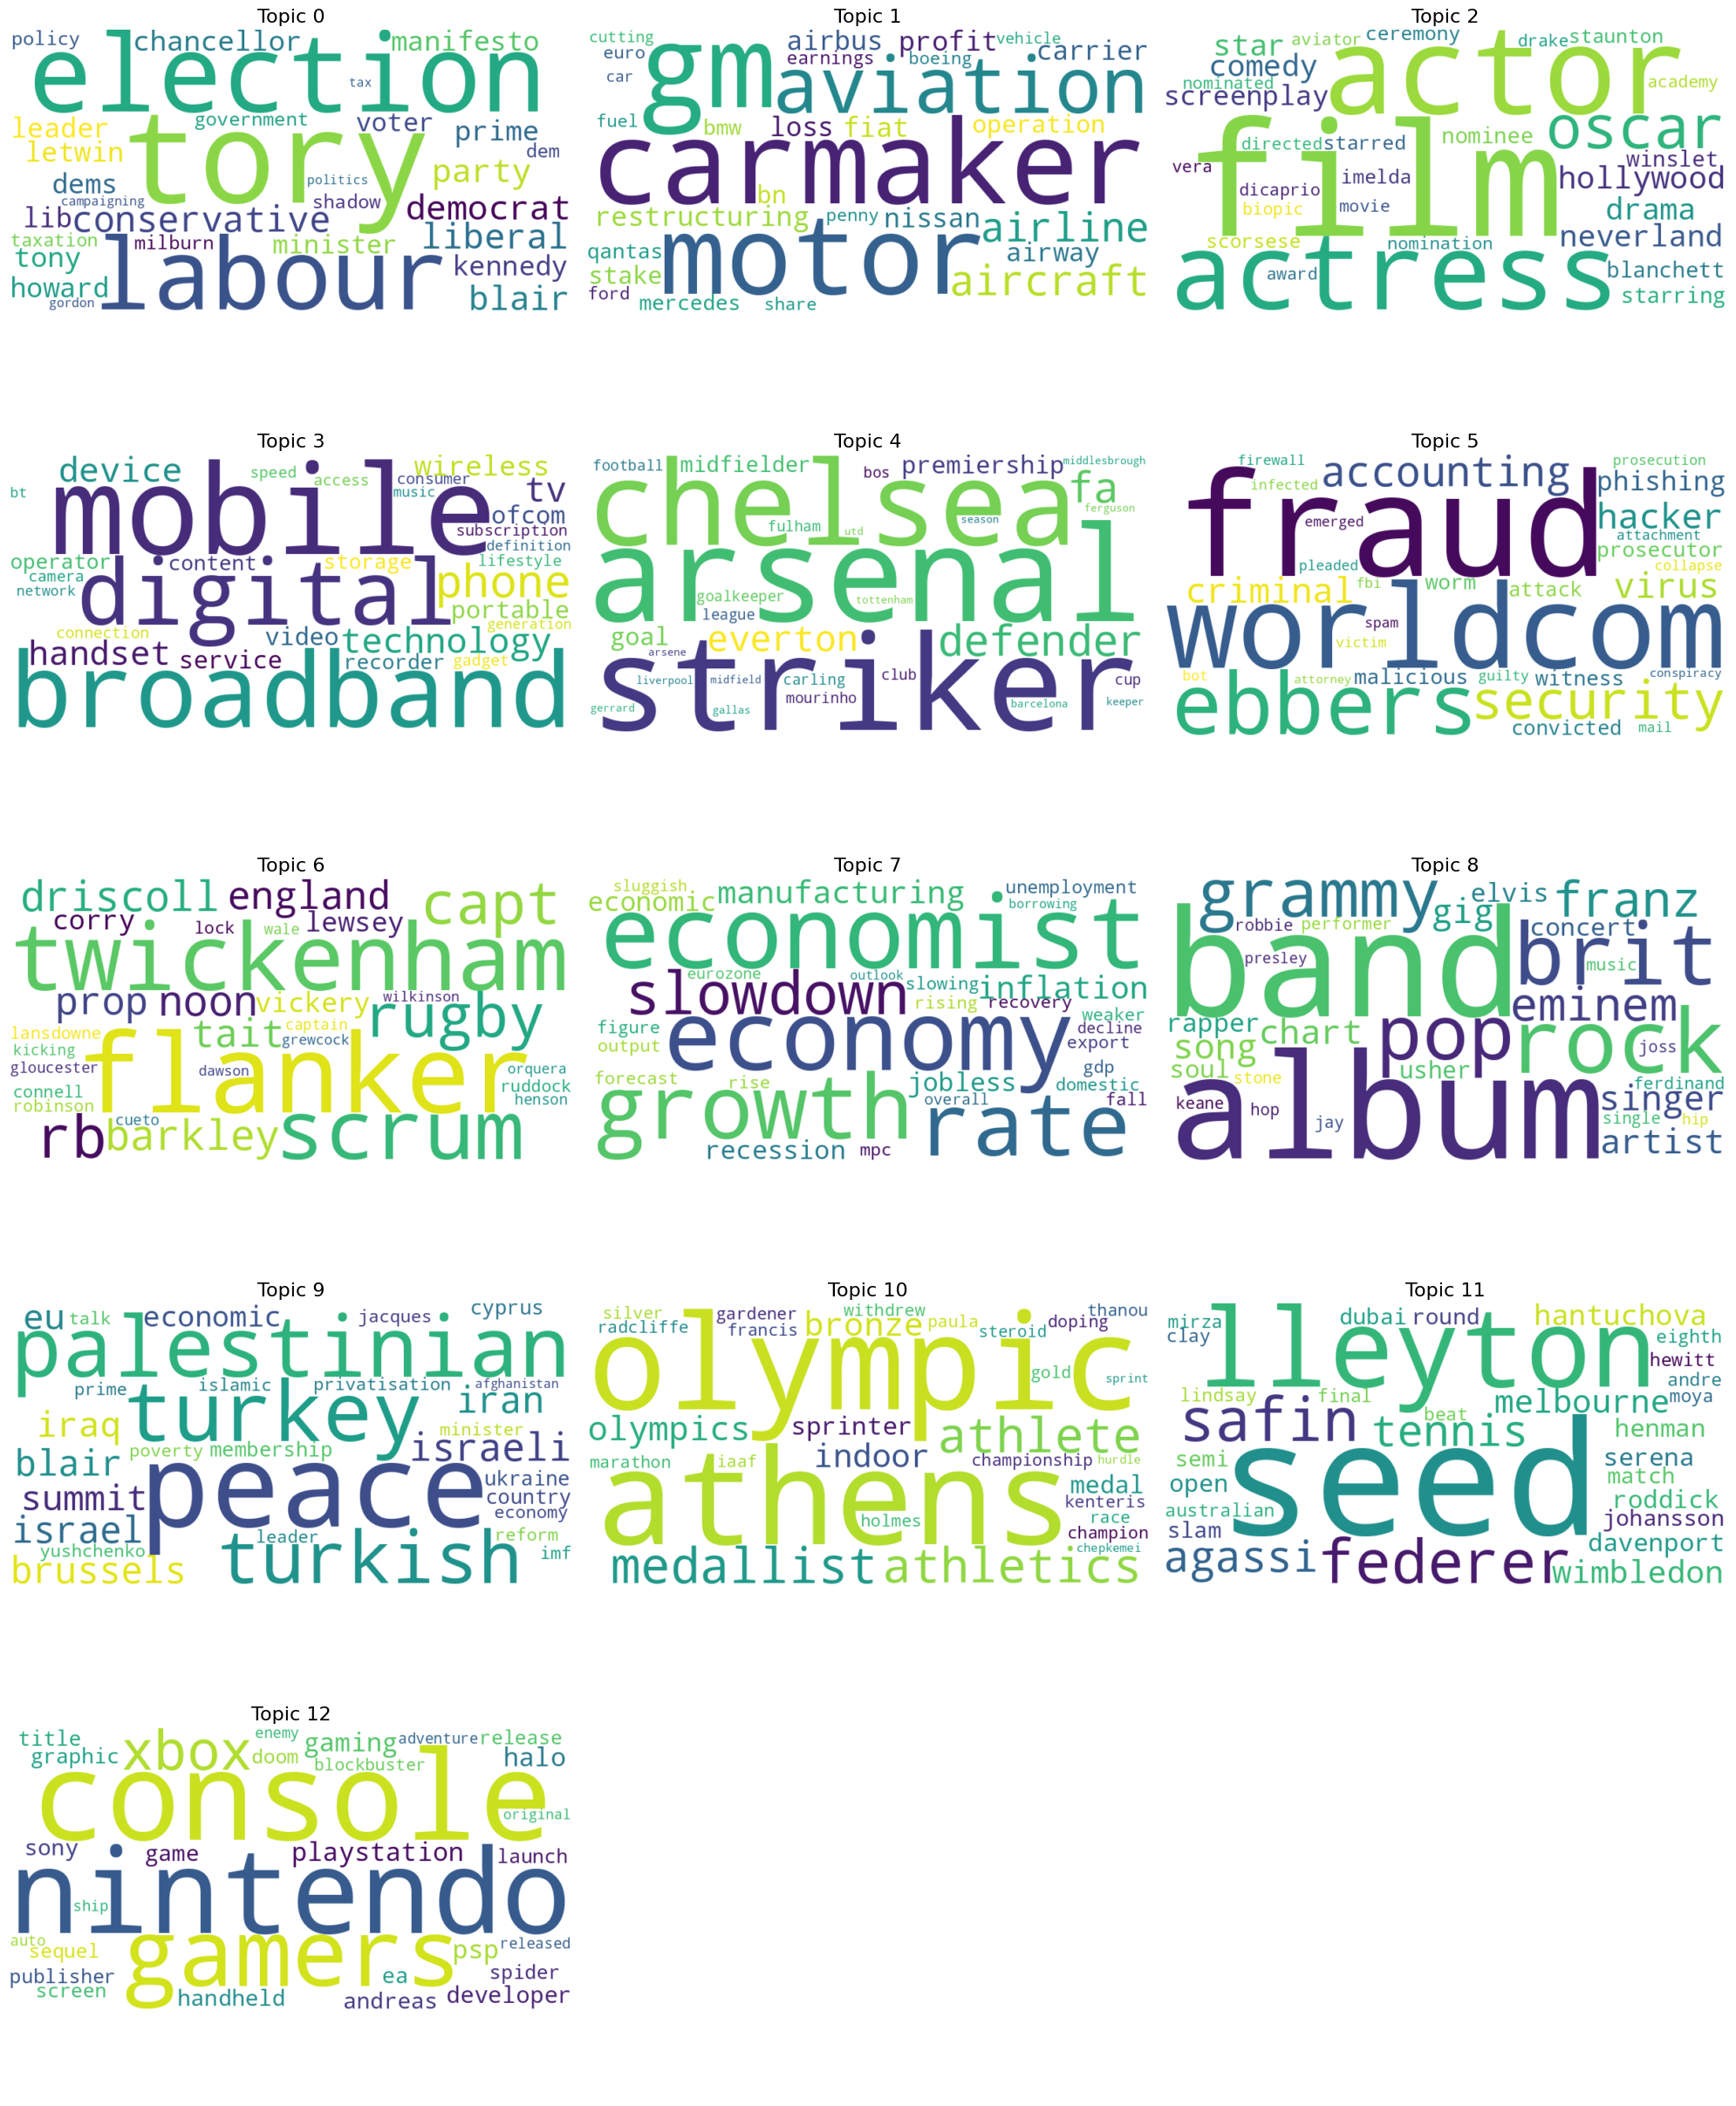

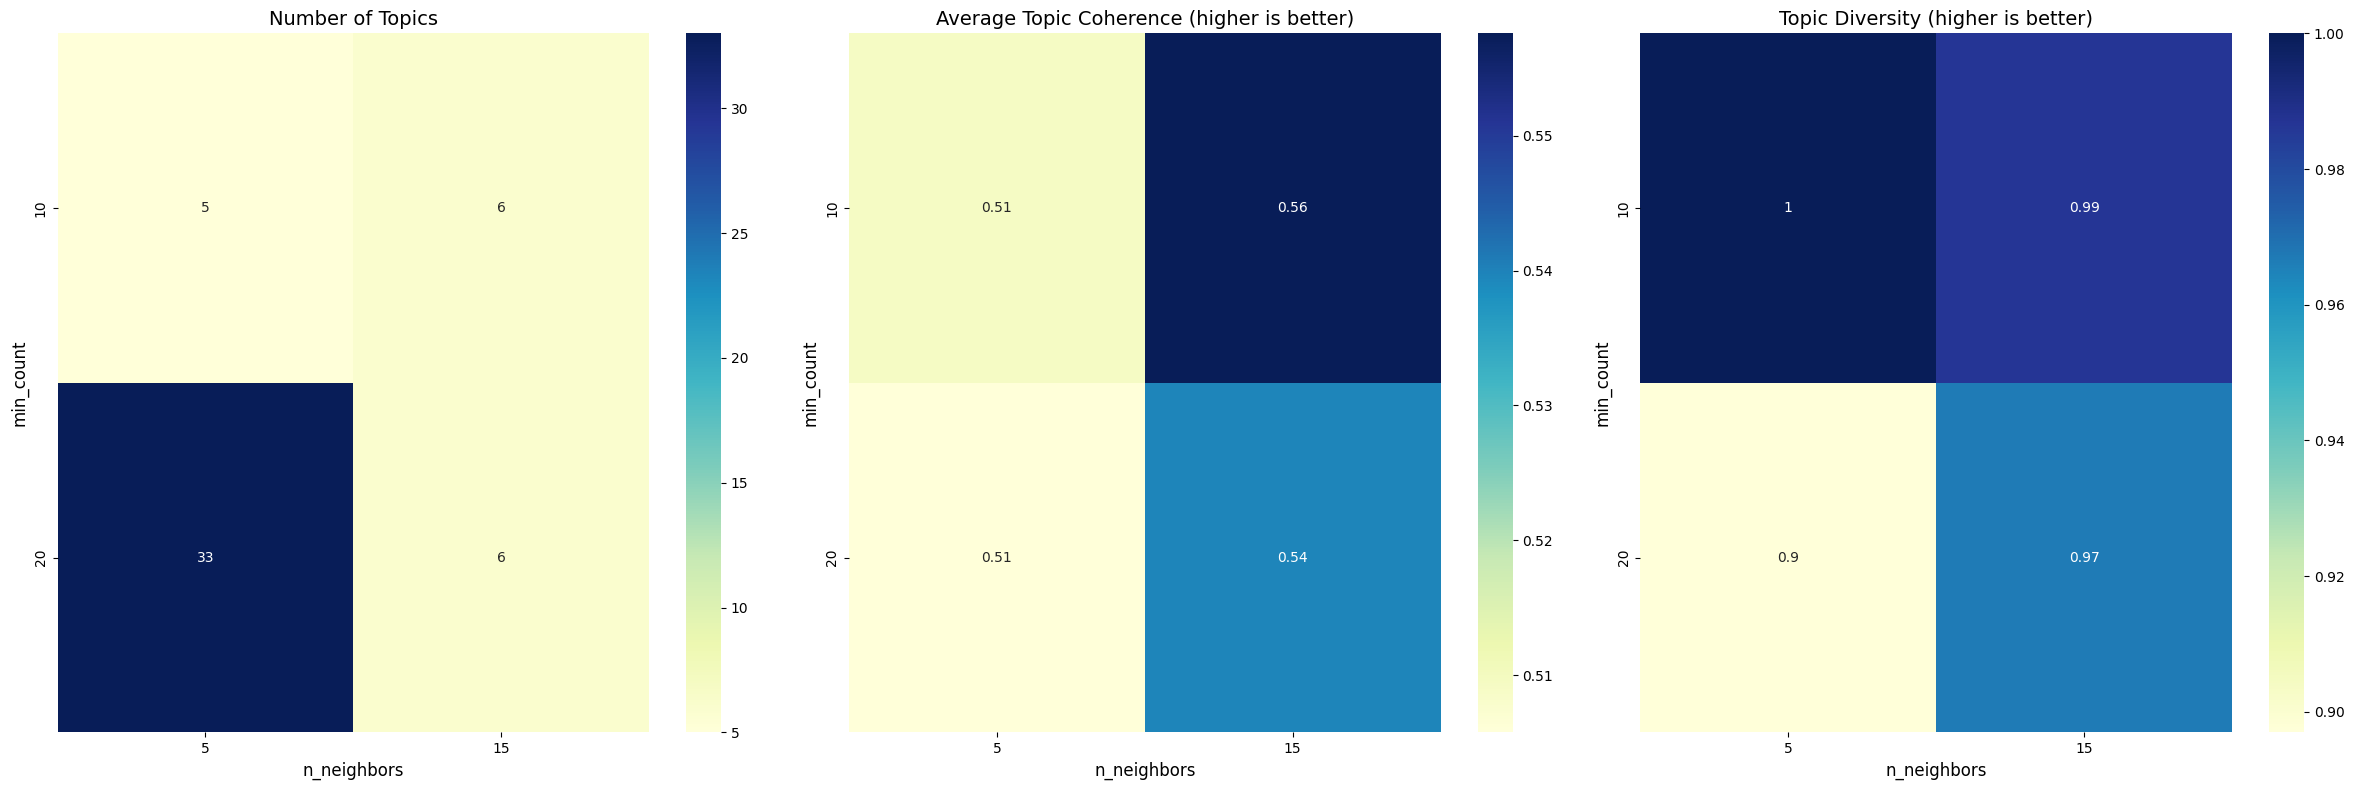

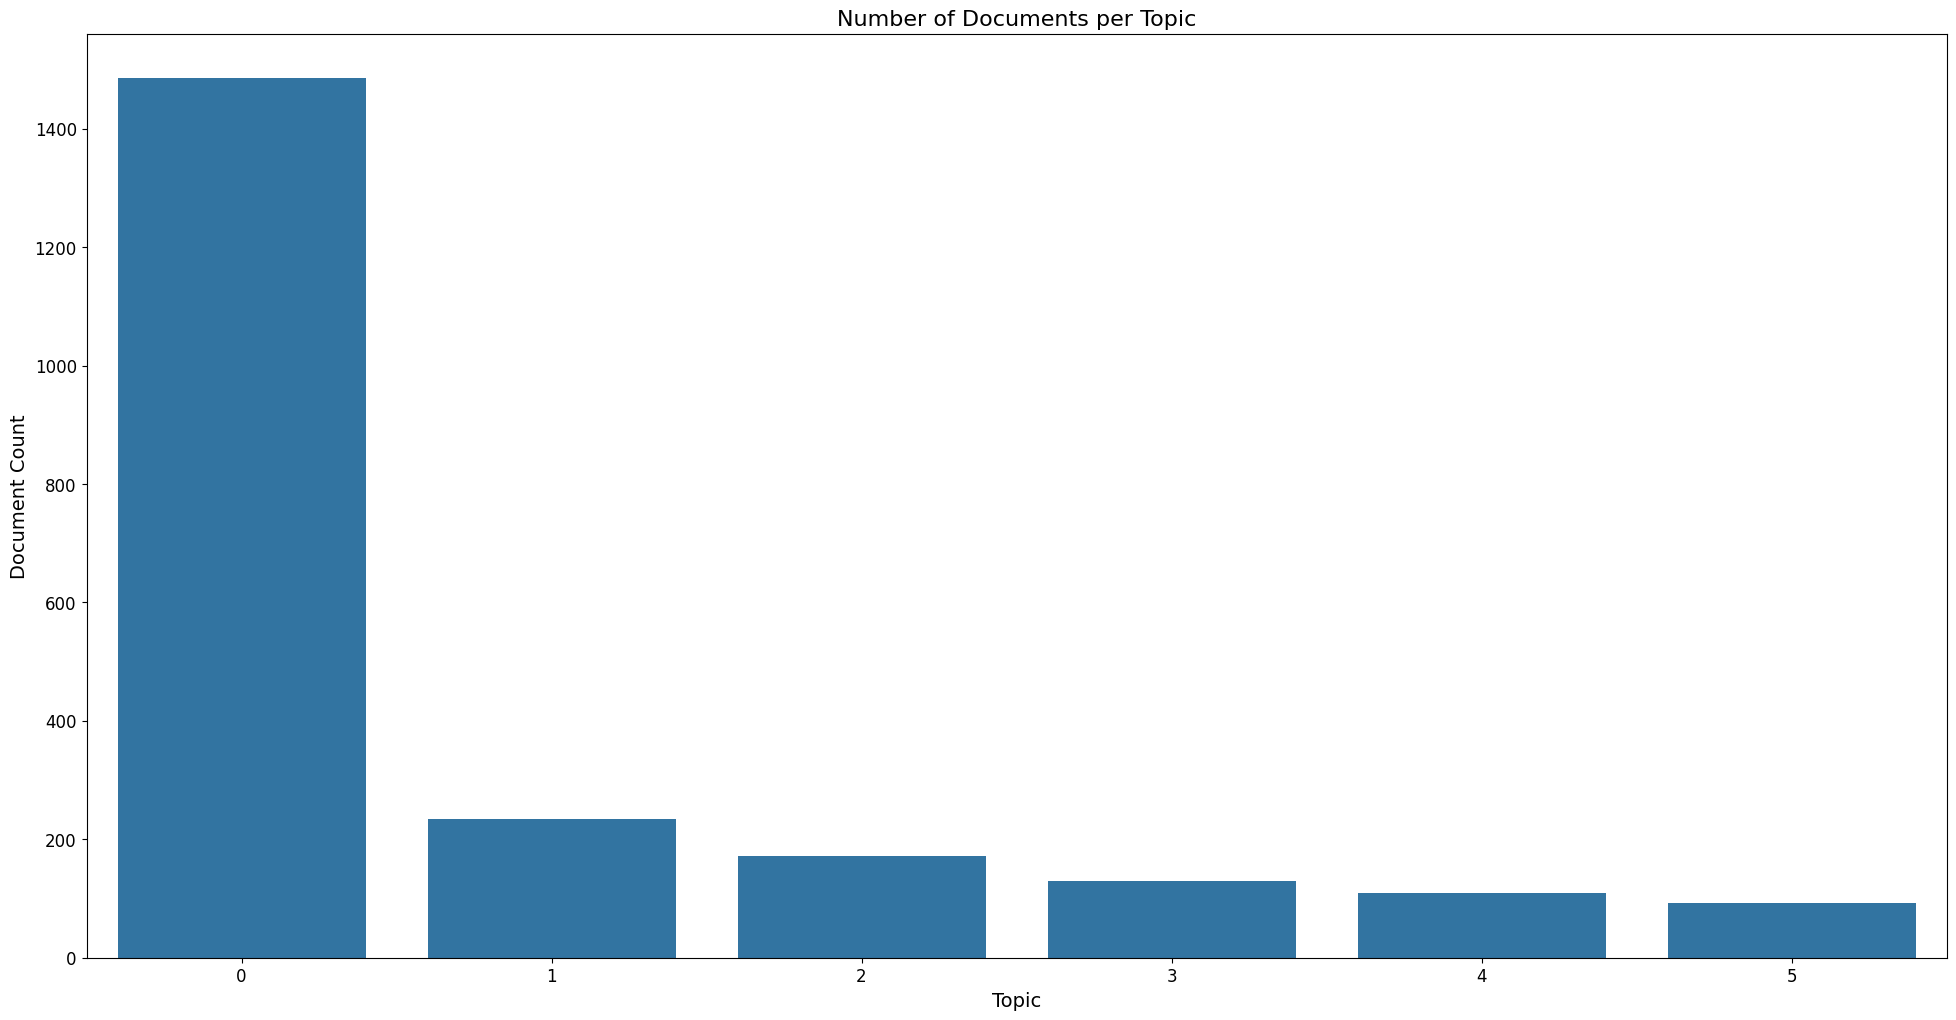

<Figure size 2000x1200 with 0 Axes>

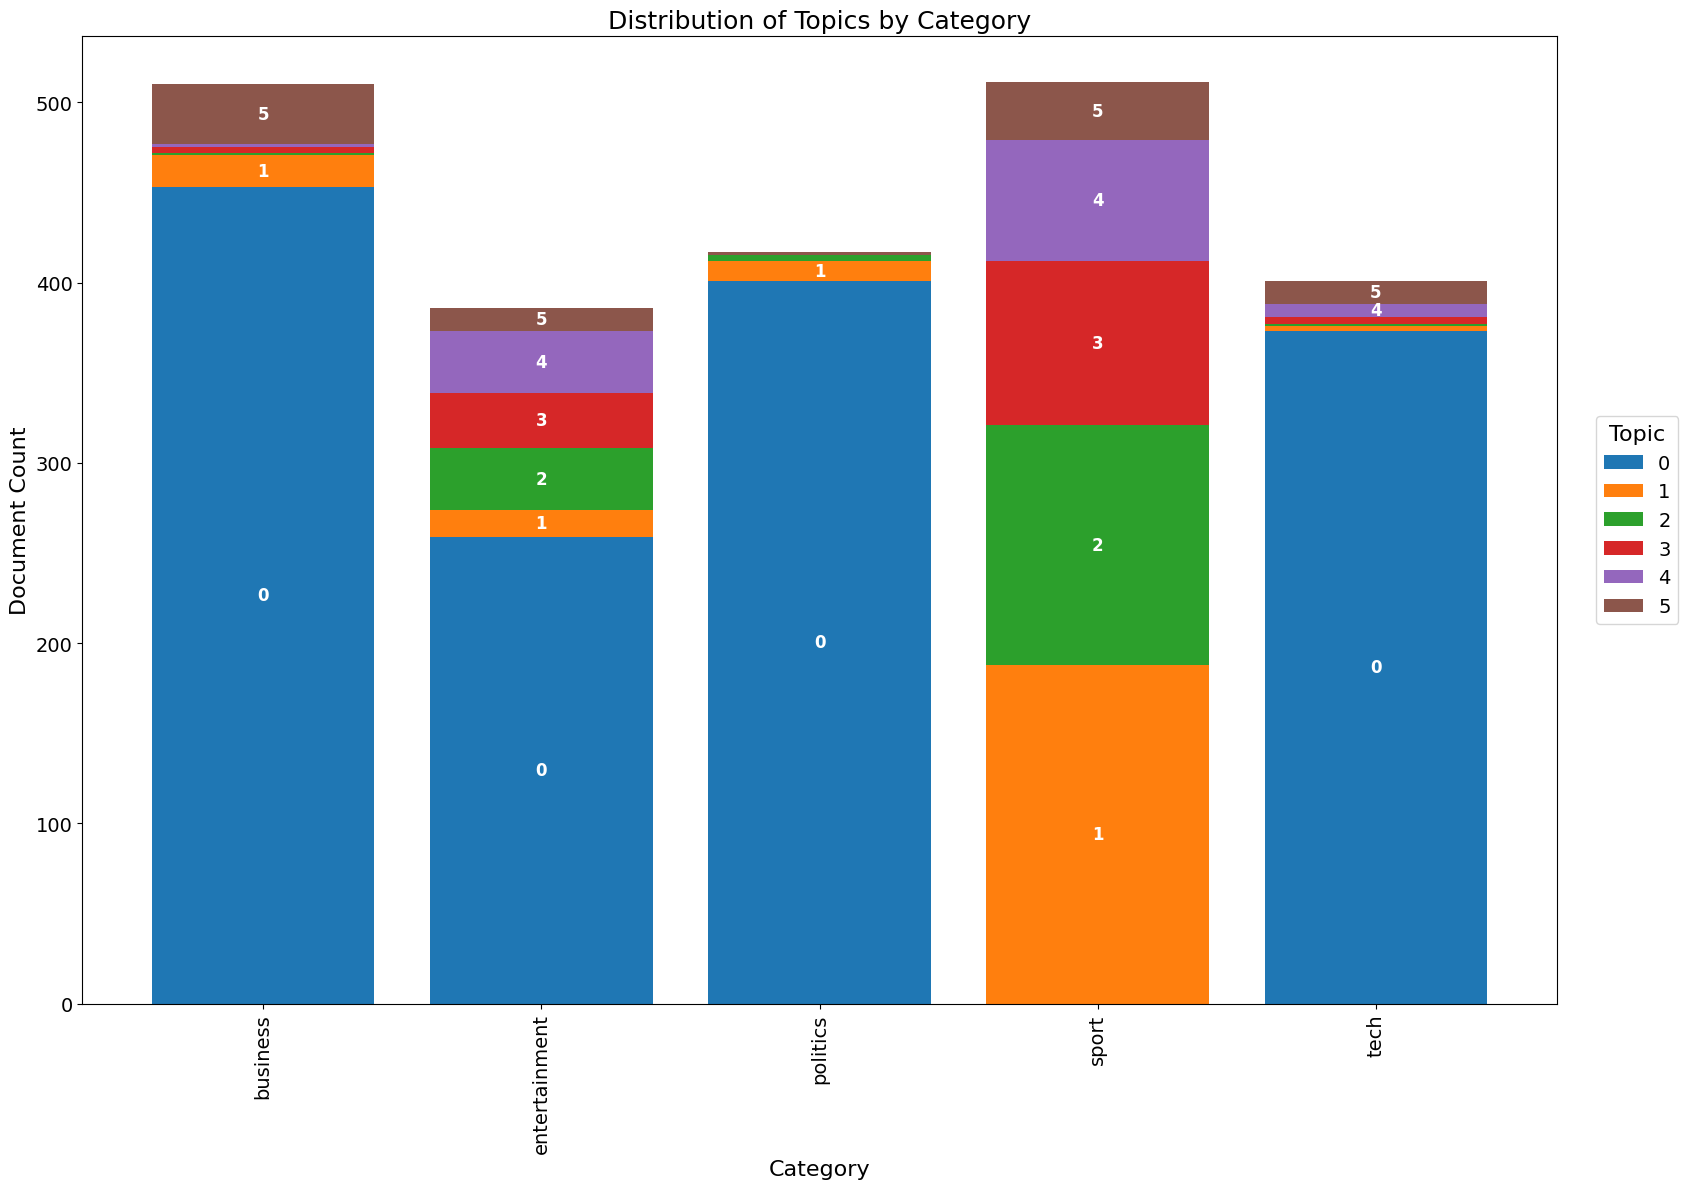

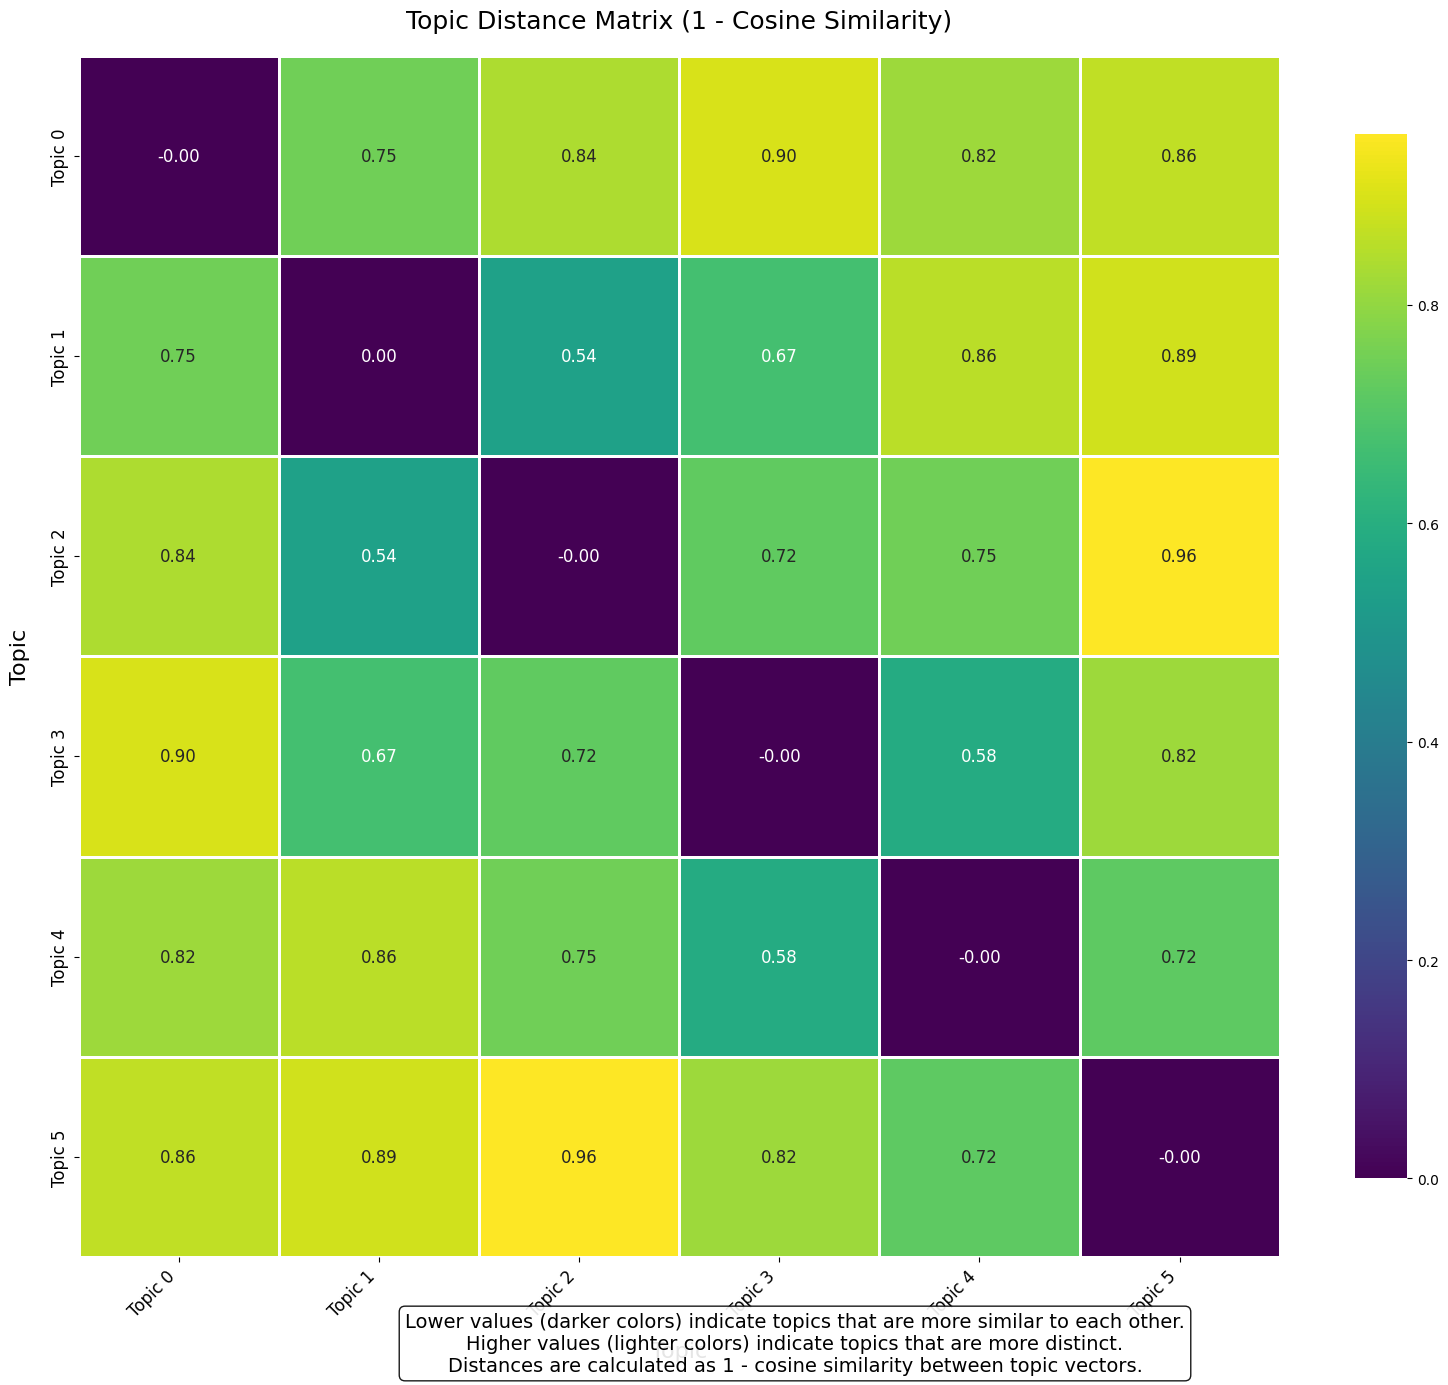

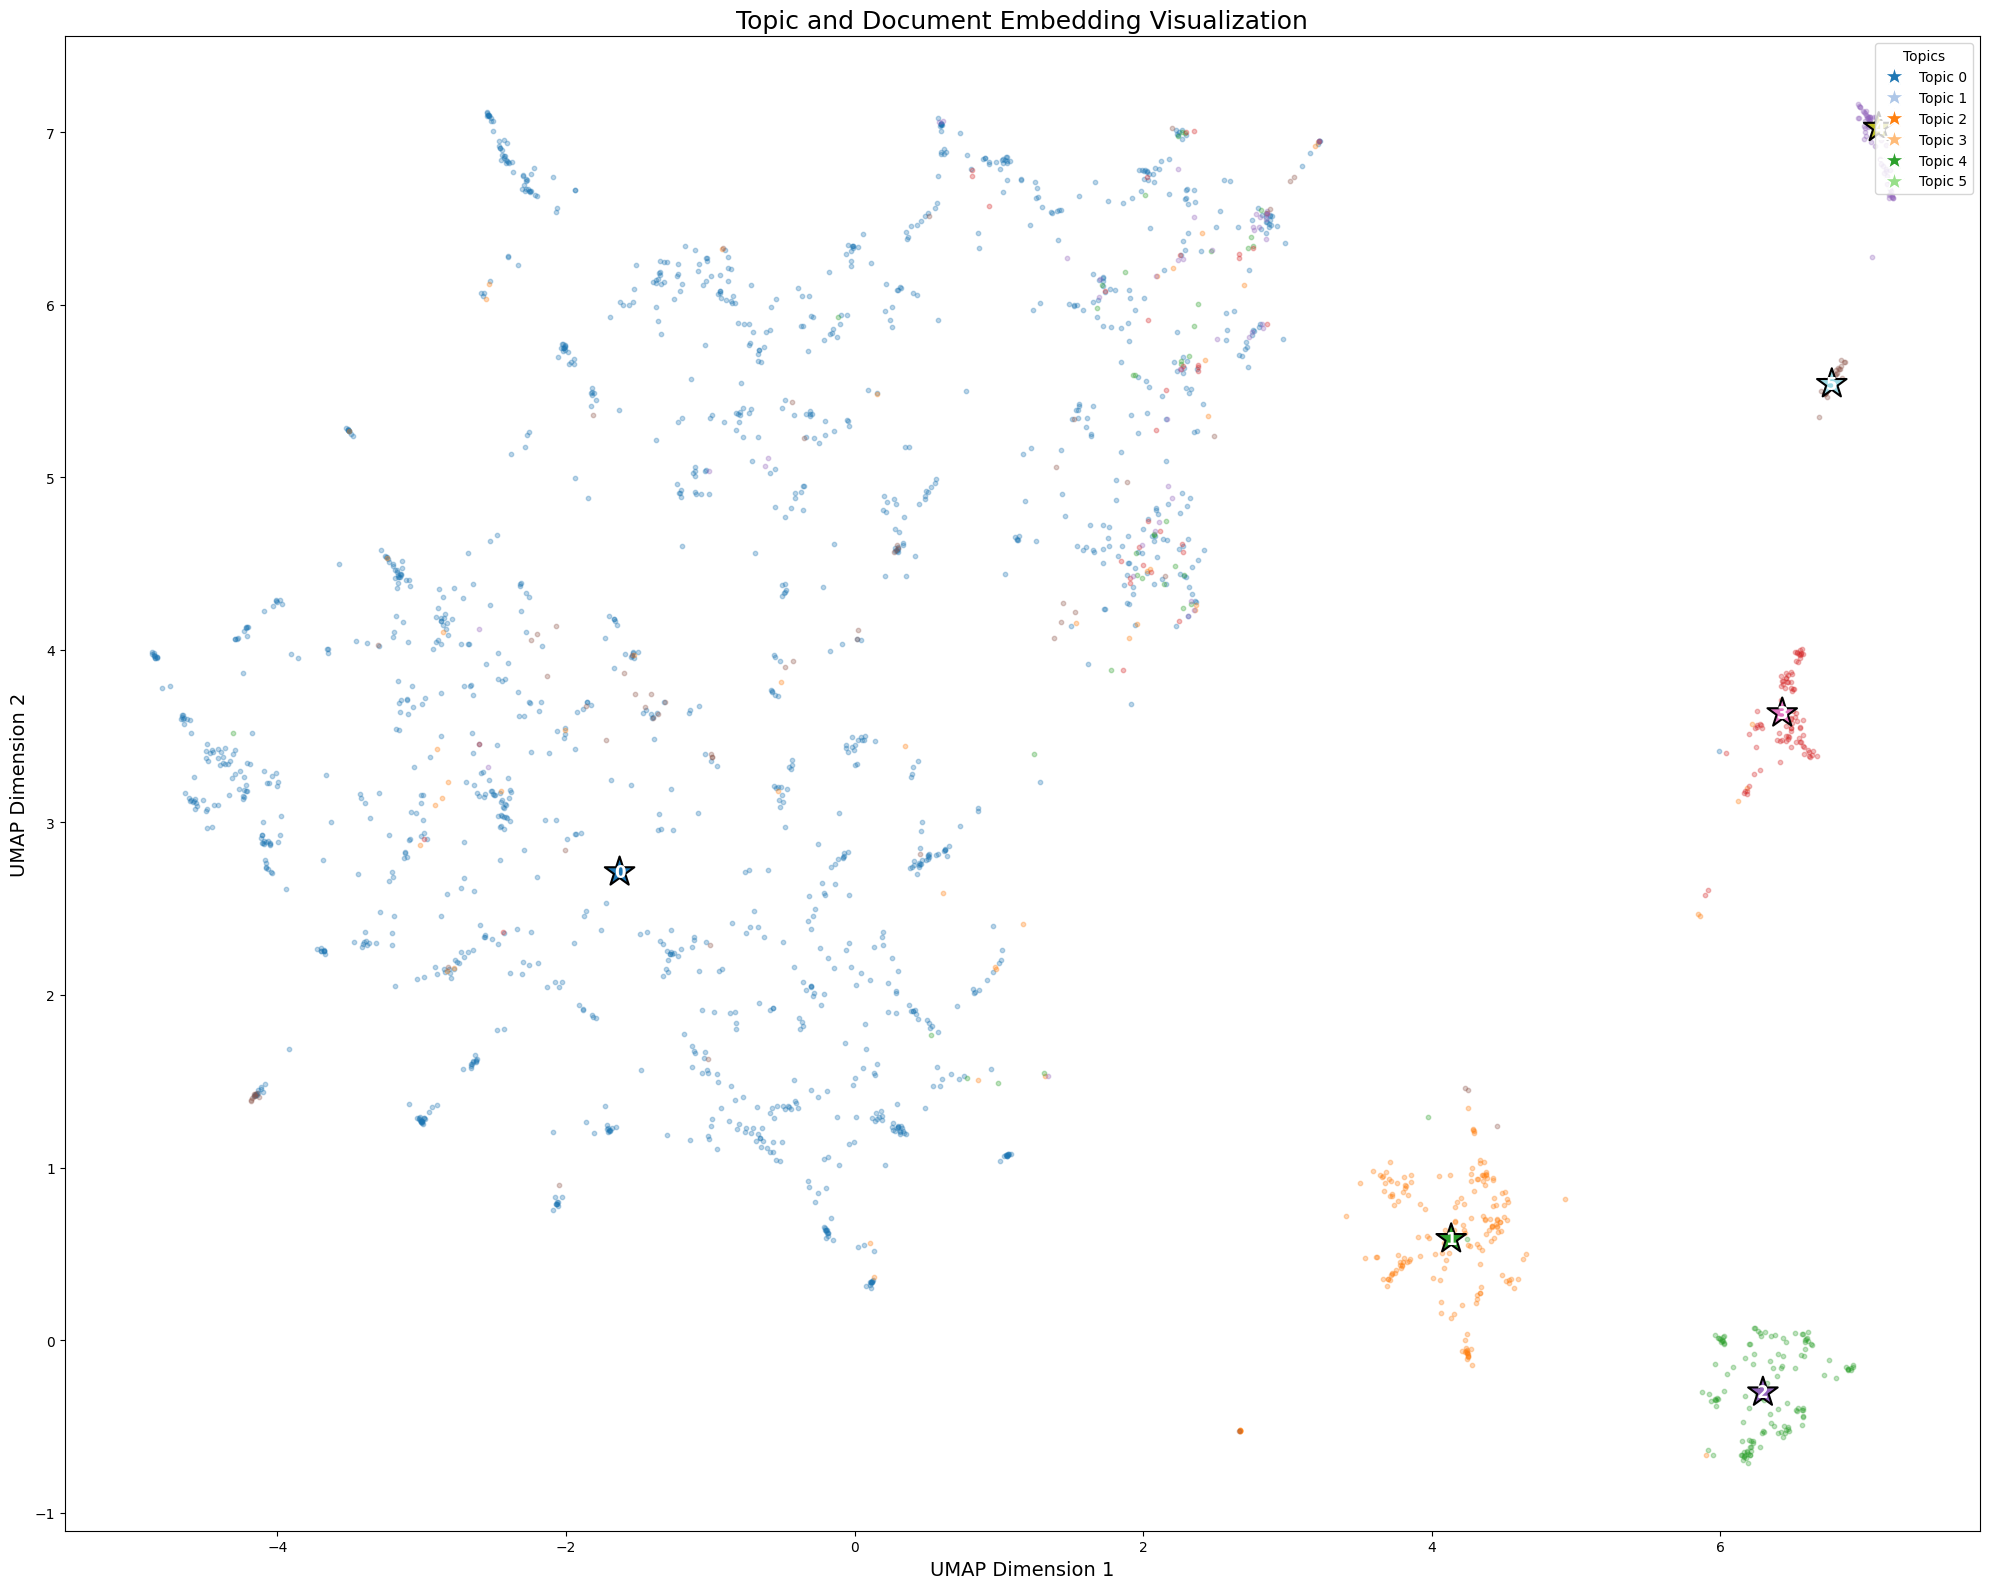

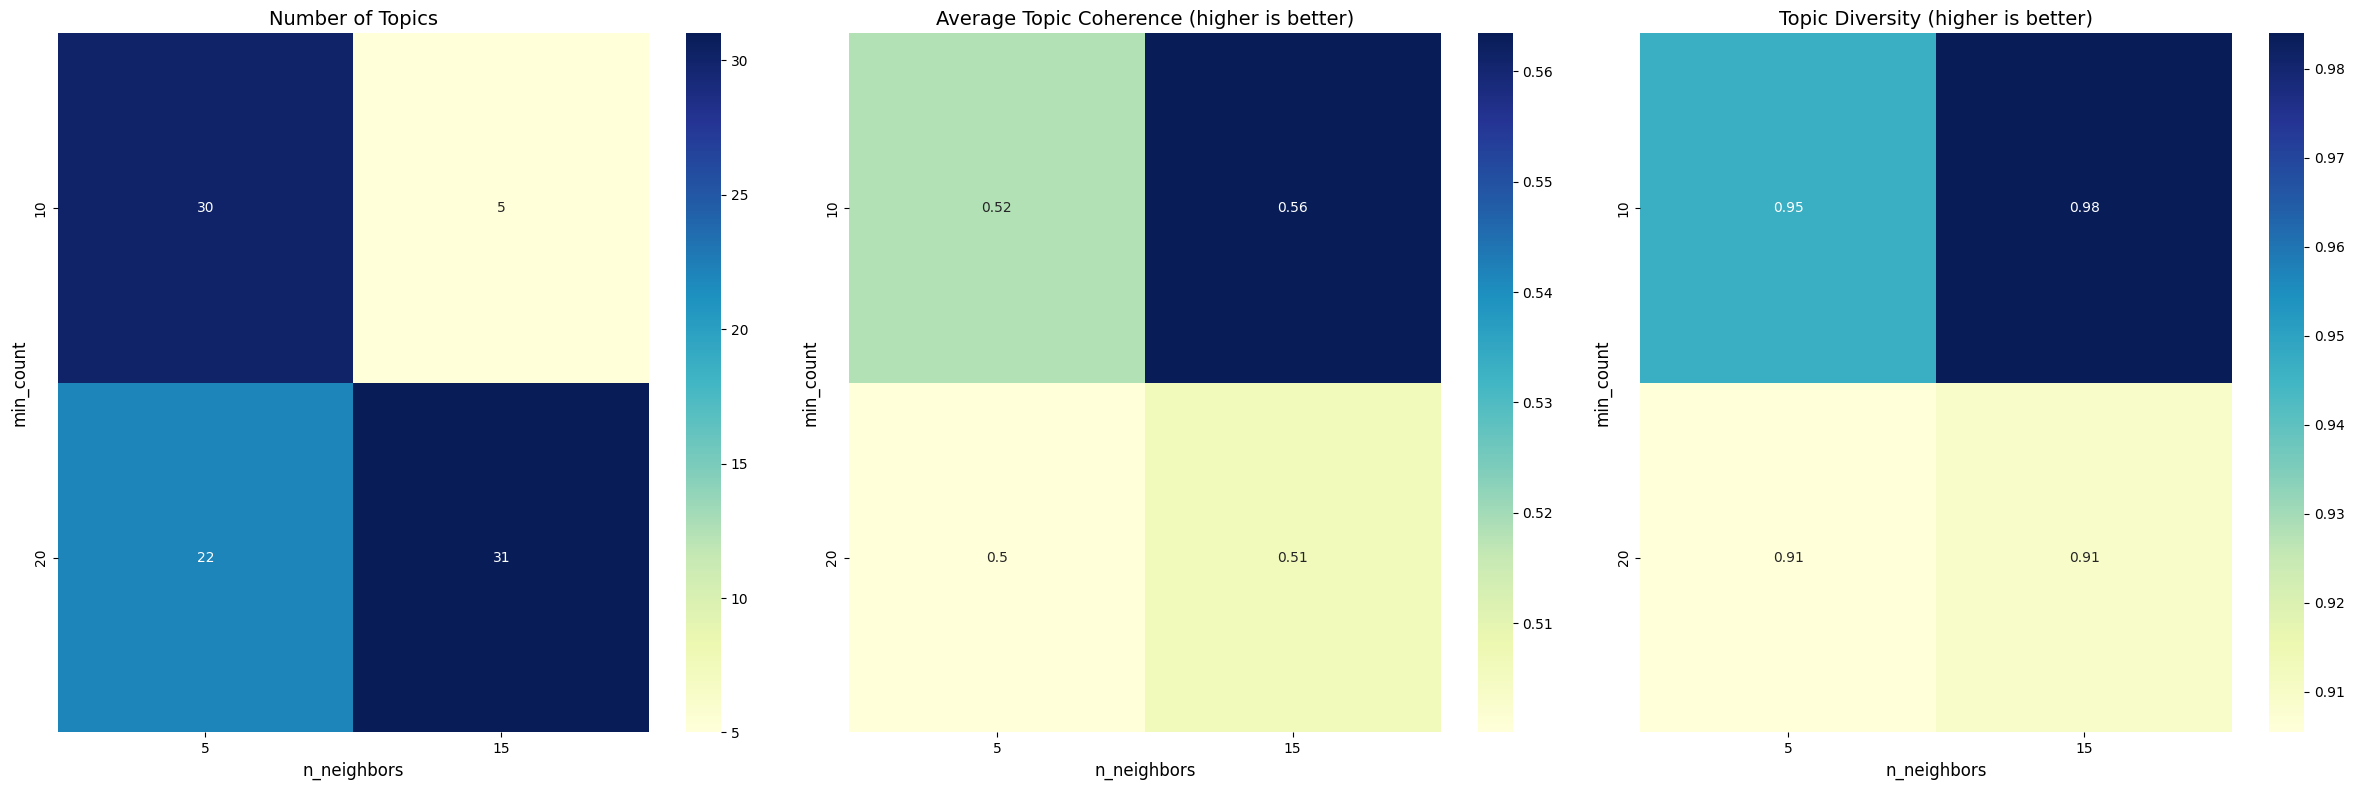

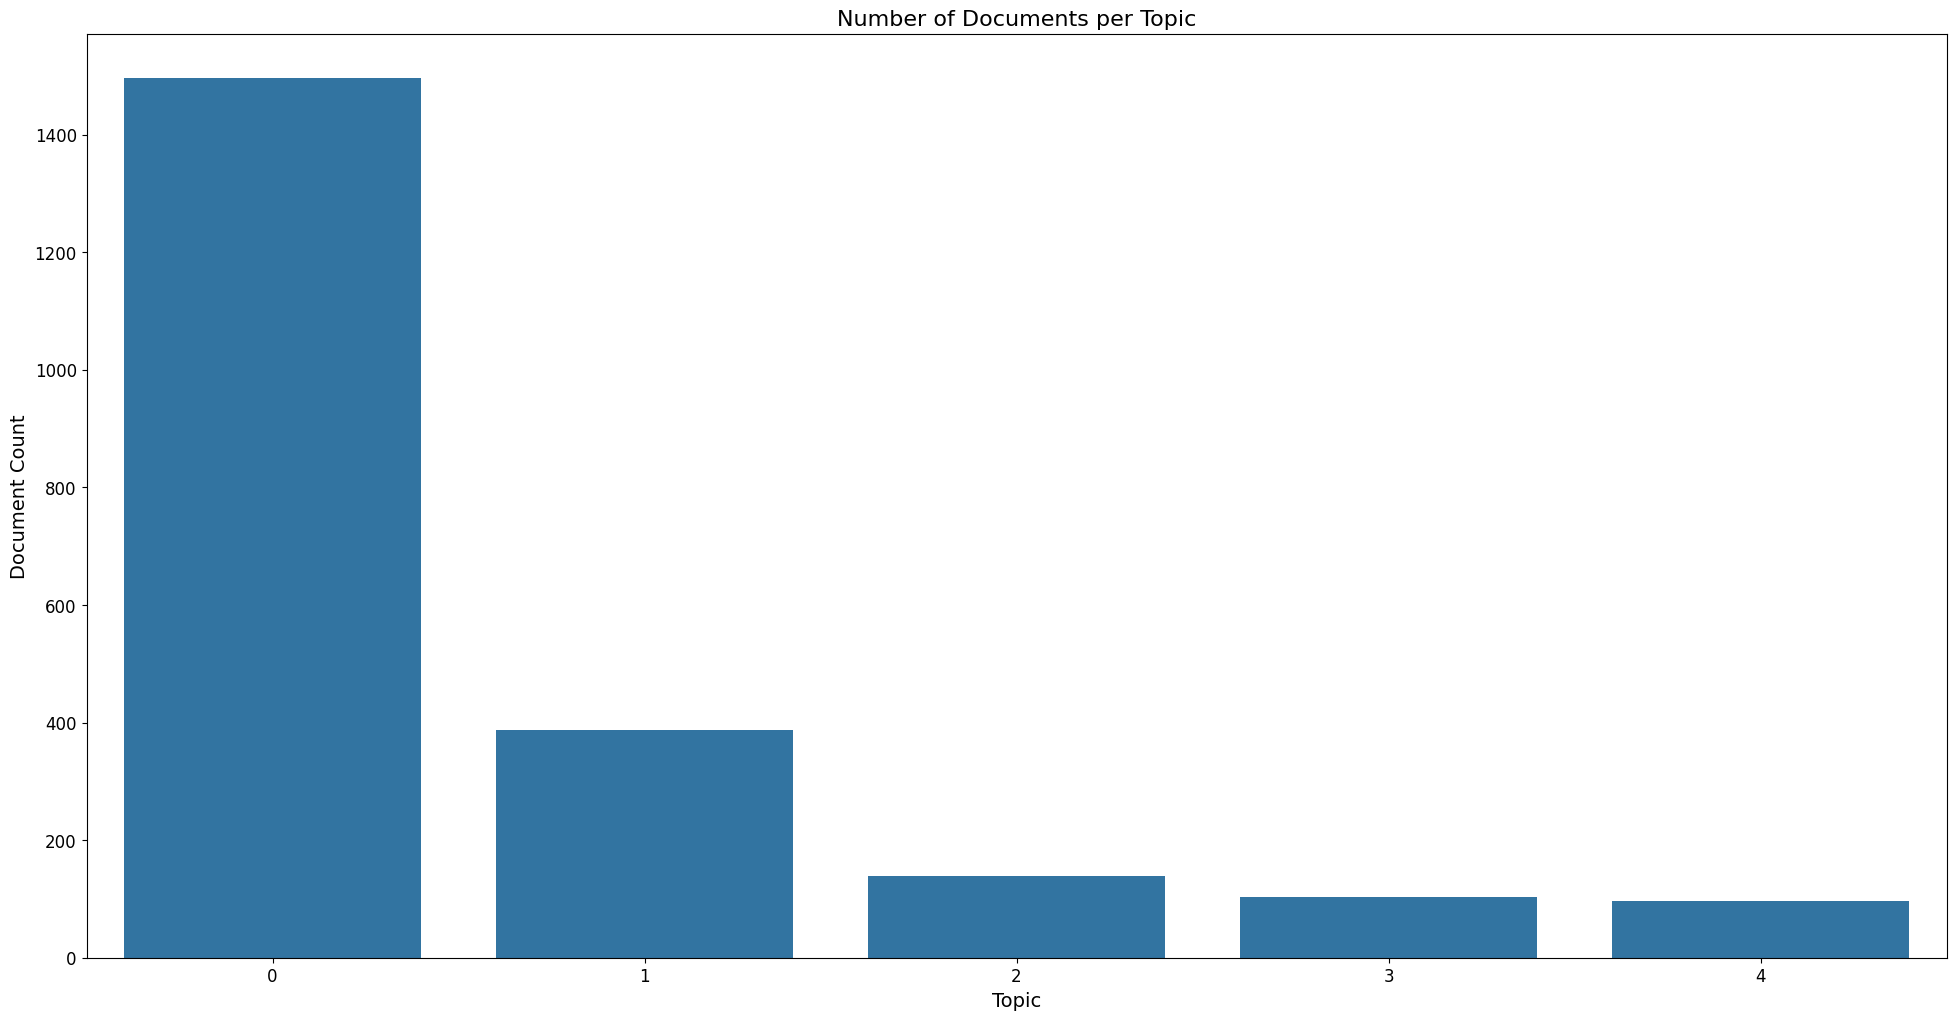

<Figure size 2000x1200 with 0 Axes>

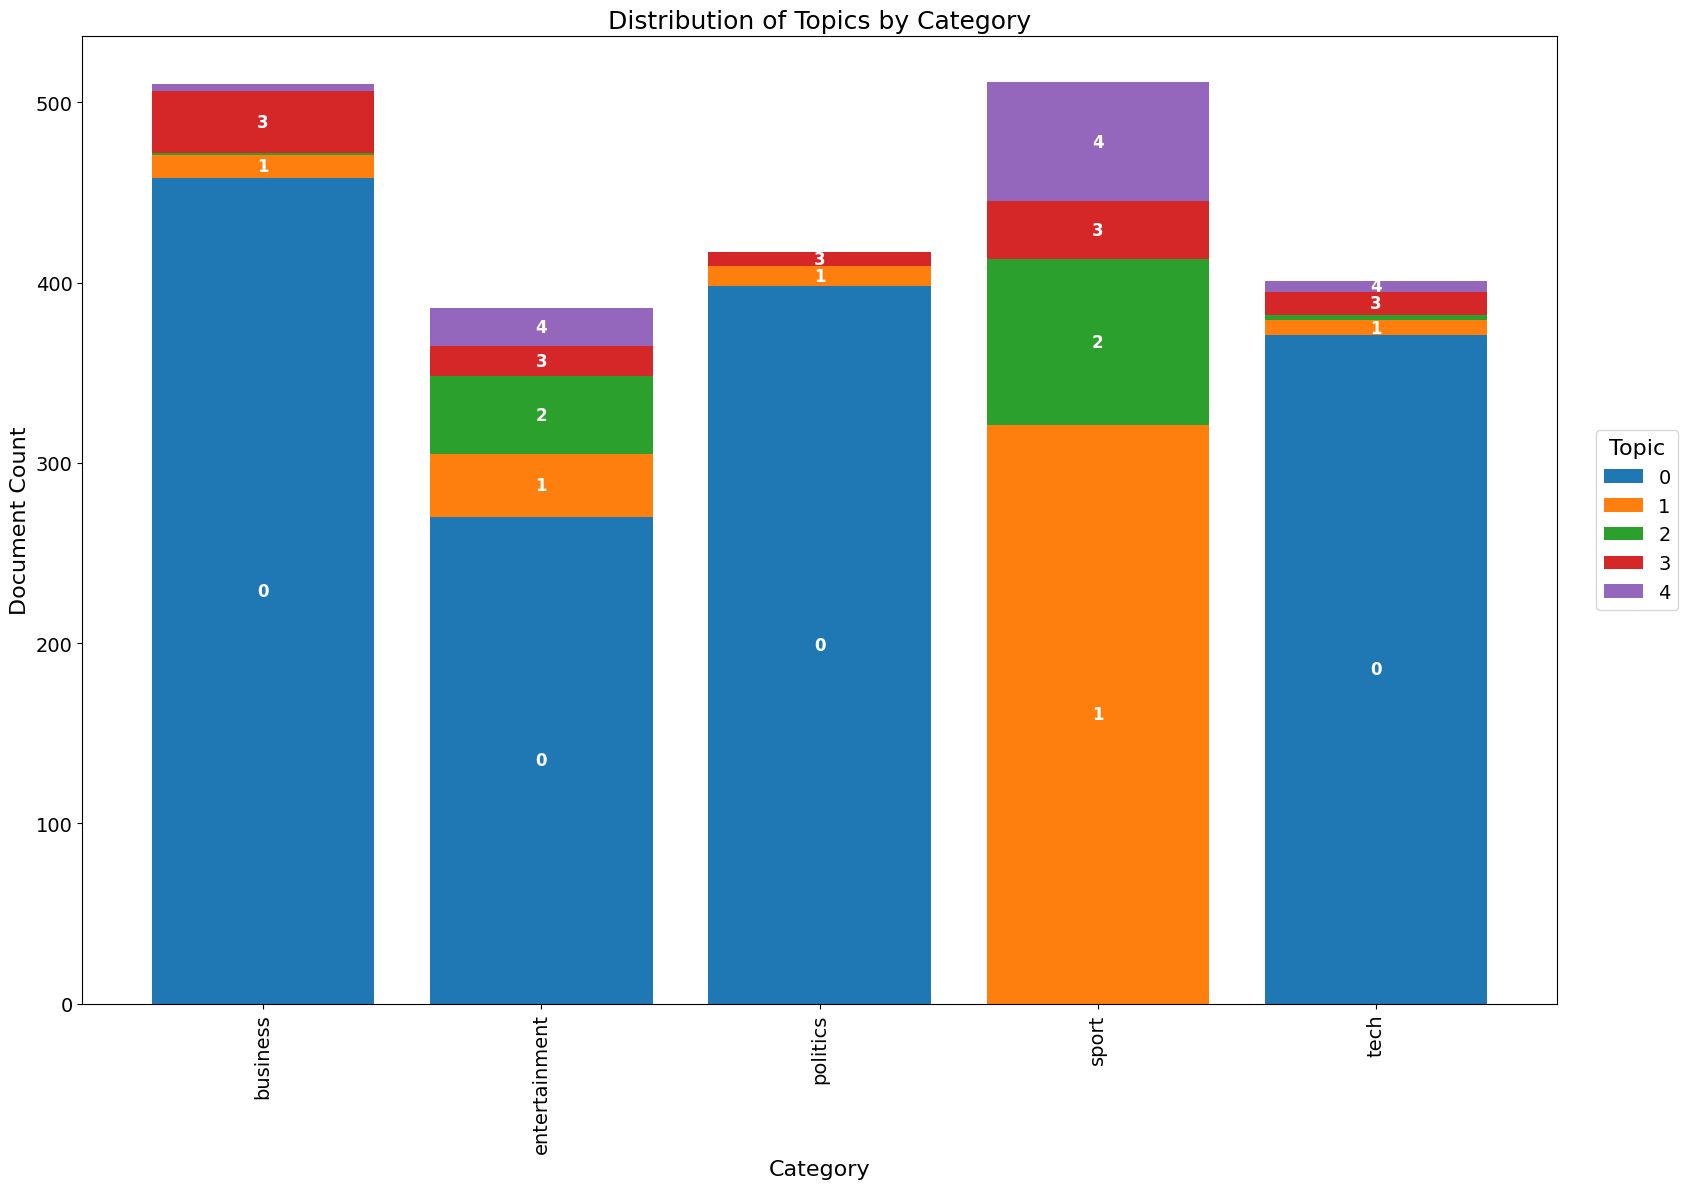

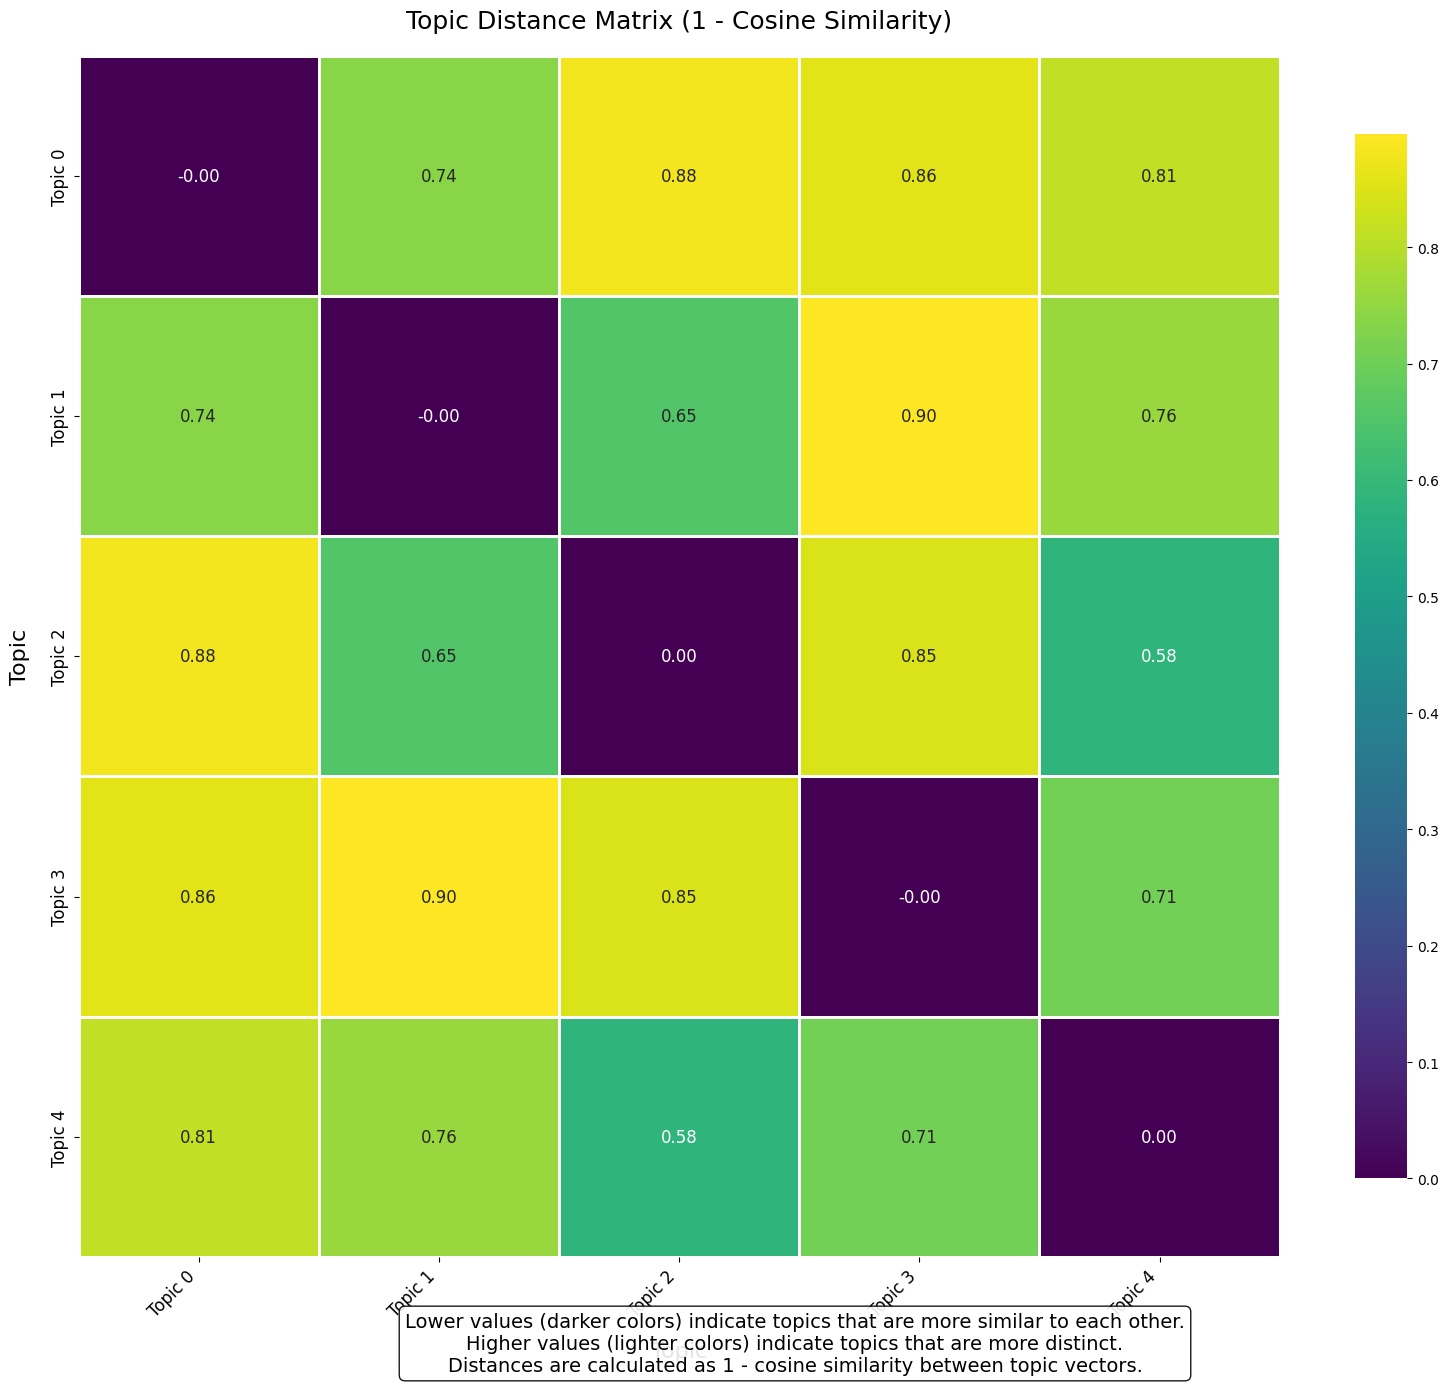

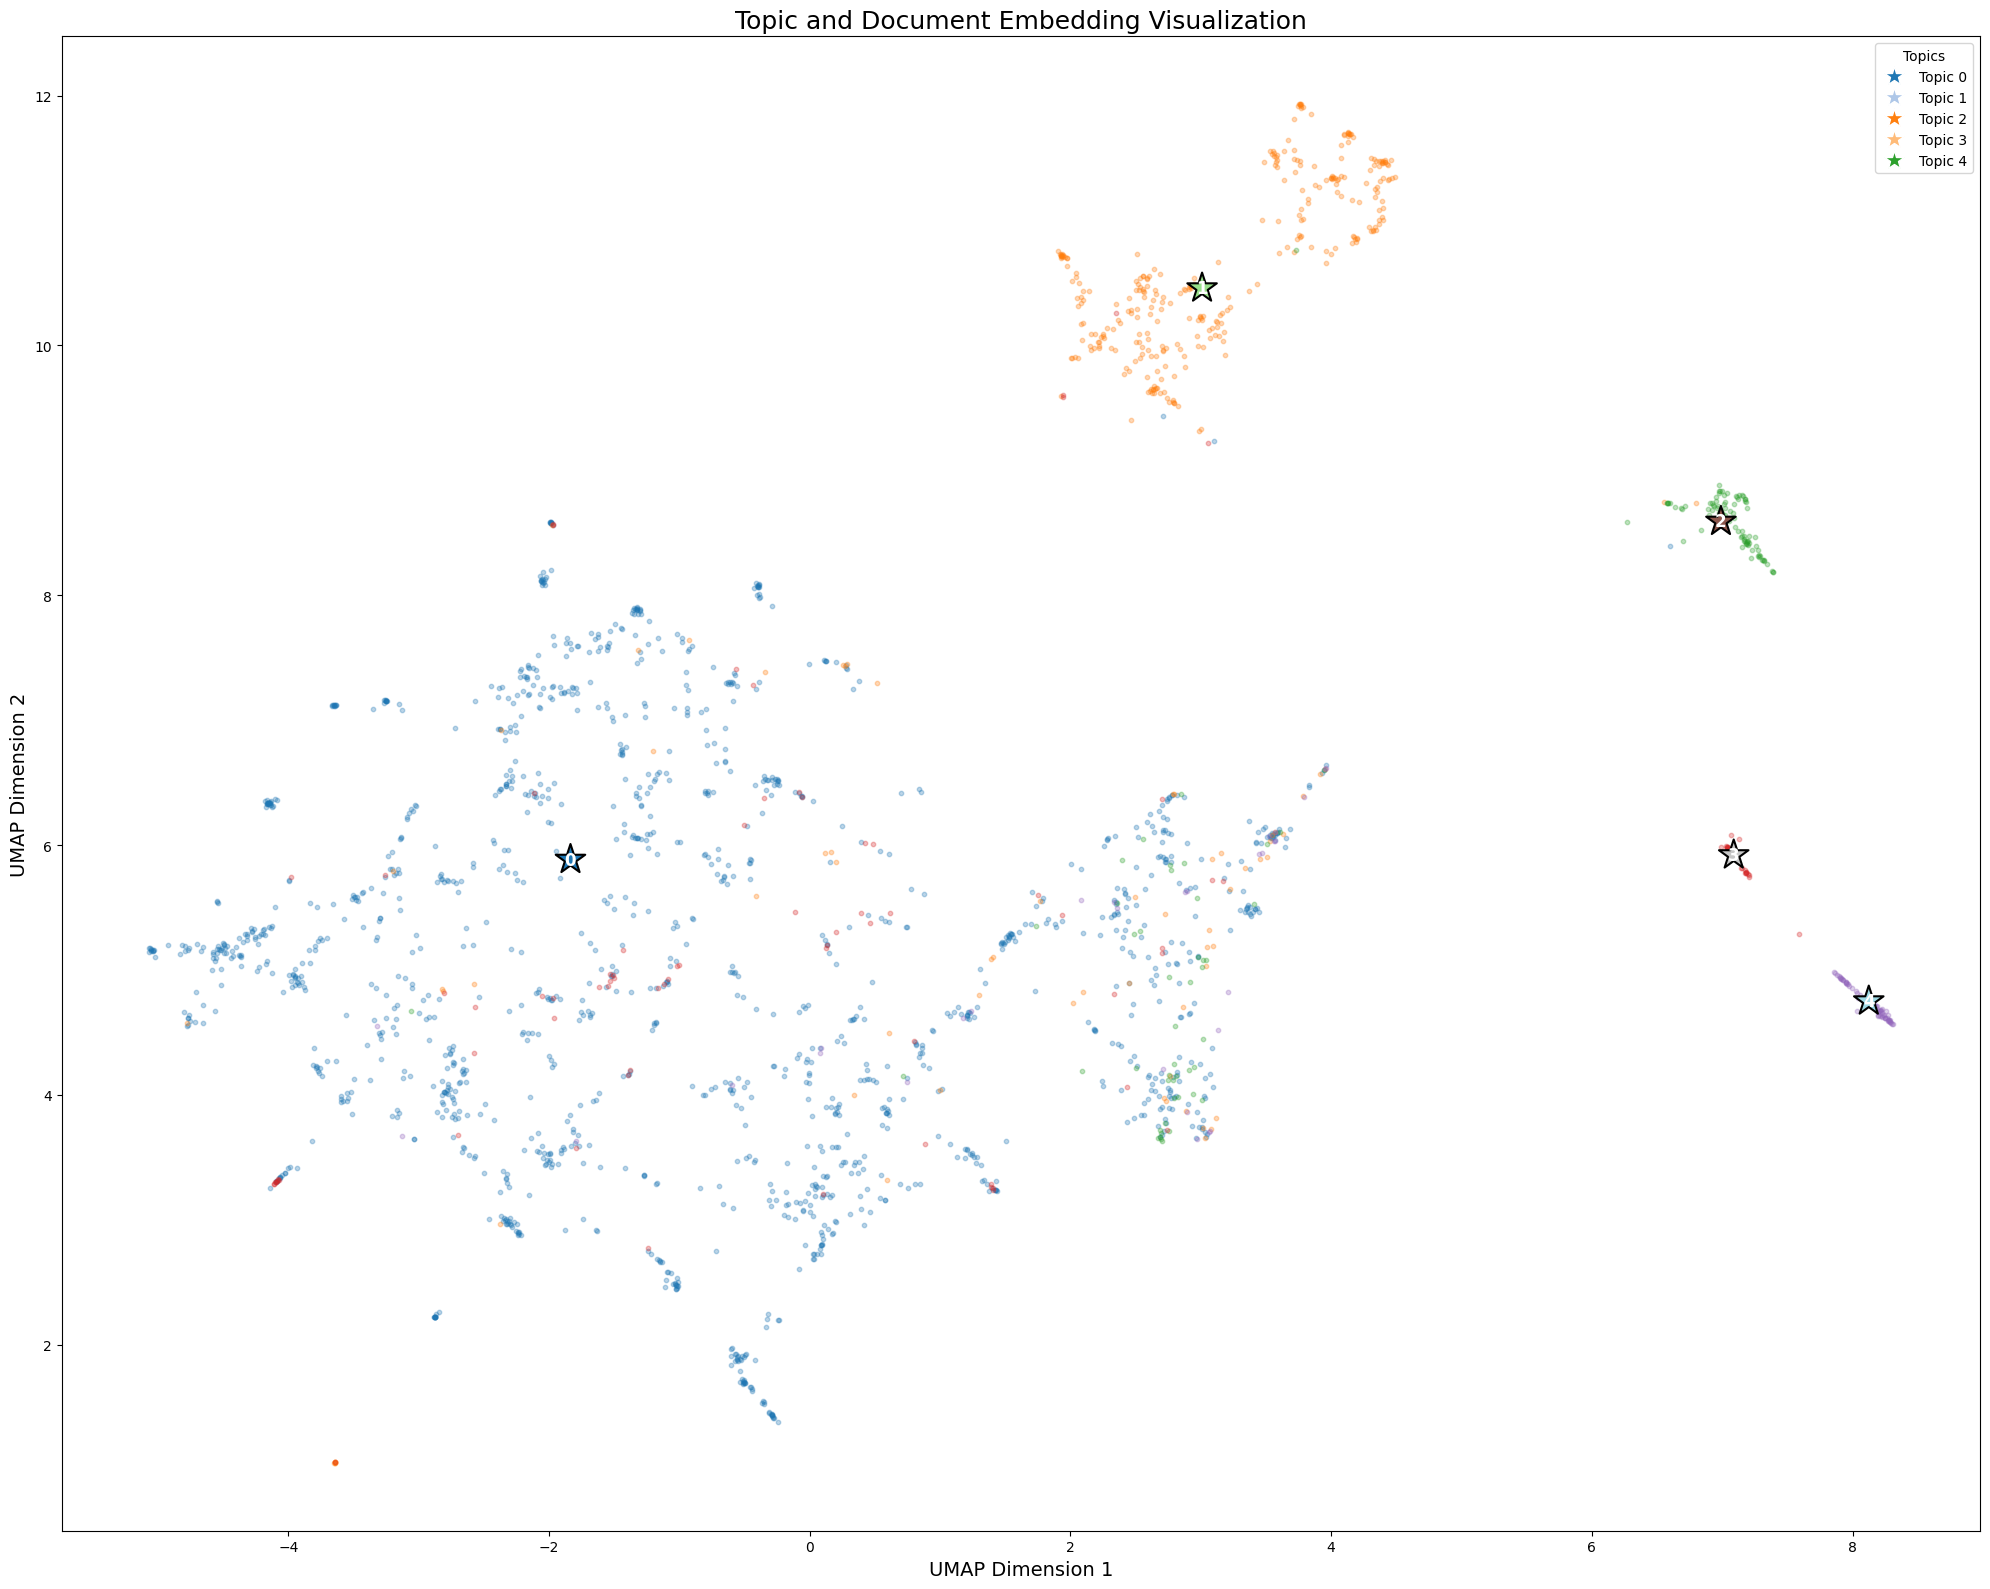

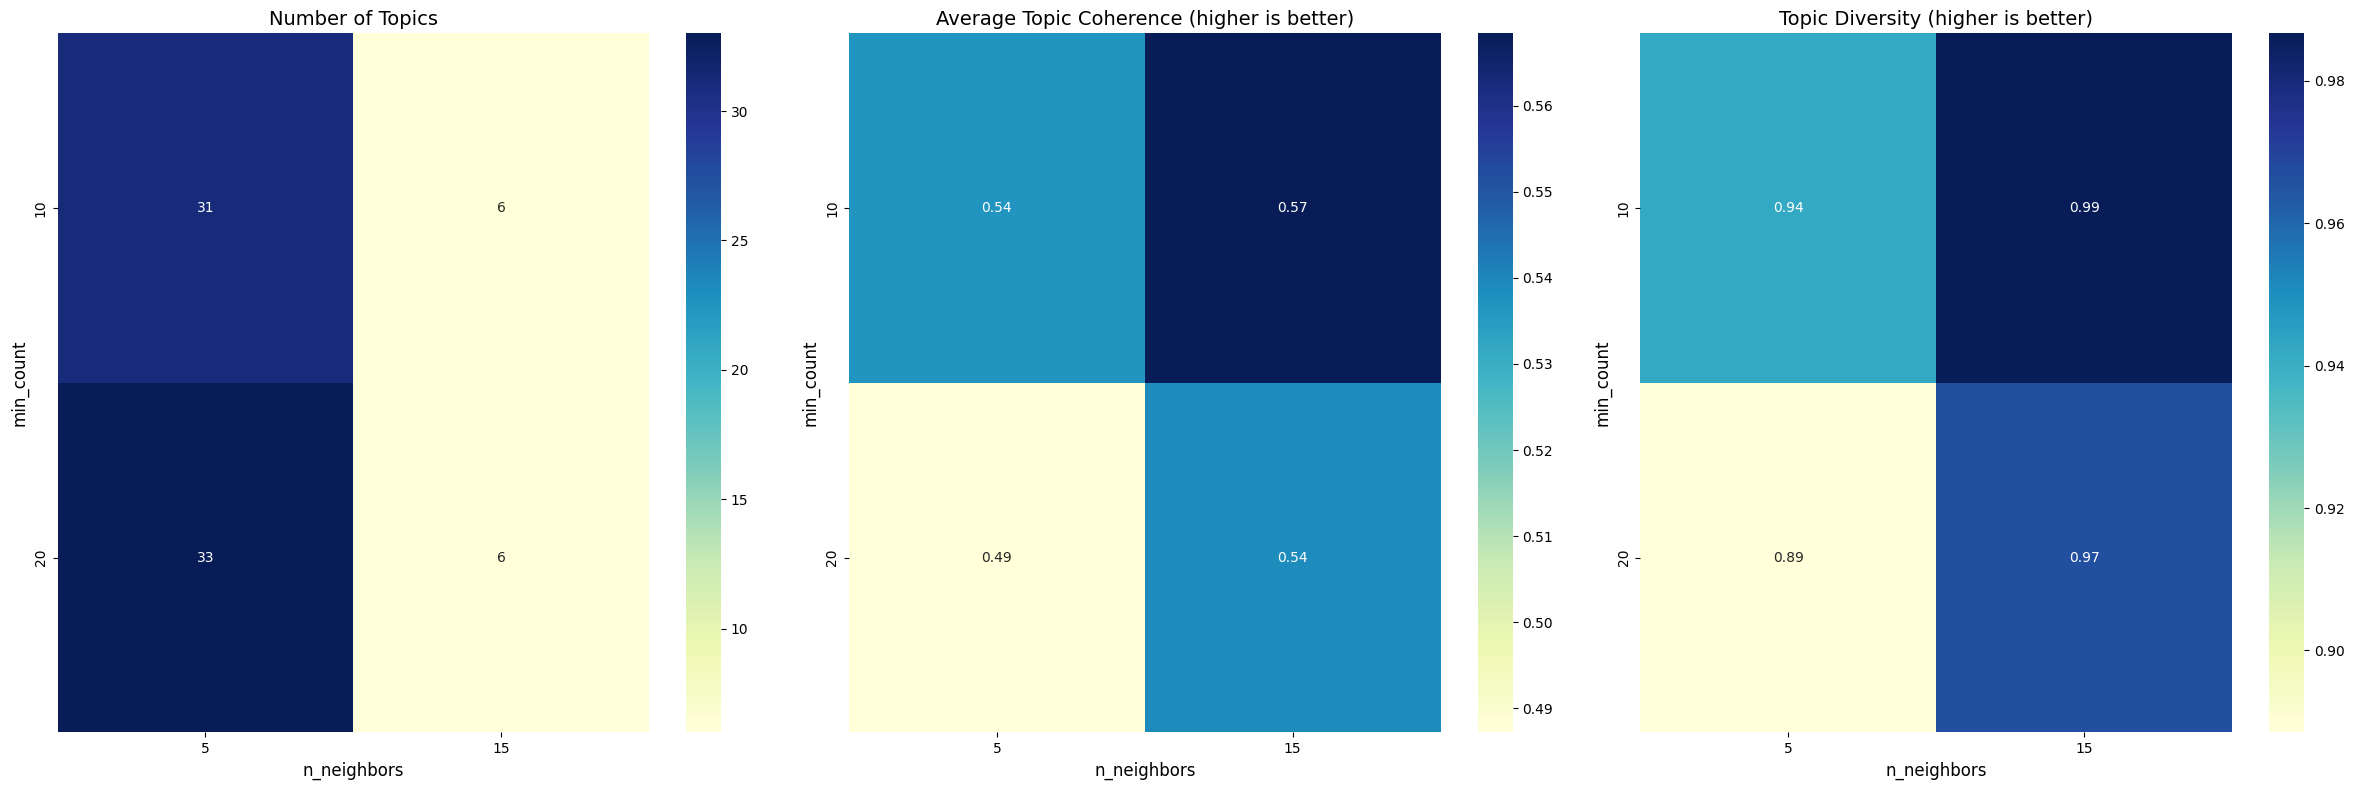


Best model parameters:
min_count: 10
n_neighbors: 15
Number of topics: 6
Average coherence: 0.5684
Topic diversity: 0.9867

Top 10 words per topic:
Topic 0: election labour conservative tory minister democrat liberal party prime government
Topic 1: striker arsenal league premiership chelsea mourinho defender fa everton bos
Topic 2: twickenham england scrum rugby flanker driscoll robinson capt mathew jenkins
Topic 3: seed lleyton seeded federer myskina melbourne tennis marat molik wimbledon
Topic 4: doping tzekos iaaf kenteris thanou sprinter ioannidis olympics faking kostas
Topic 5: indoor olympic race championship medallist heptathlon indoors bronze gardener prix


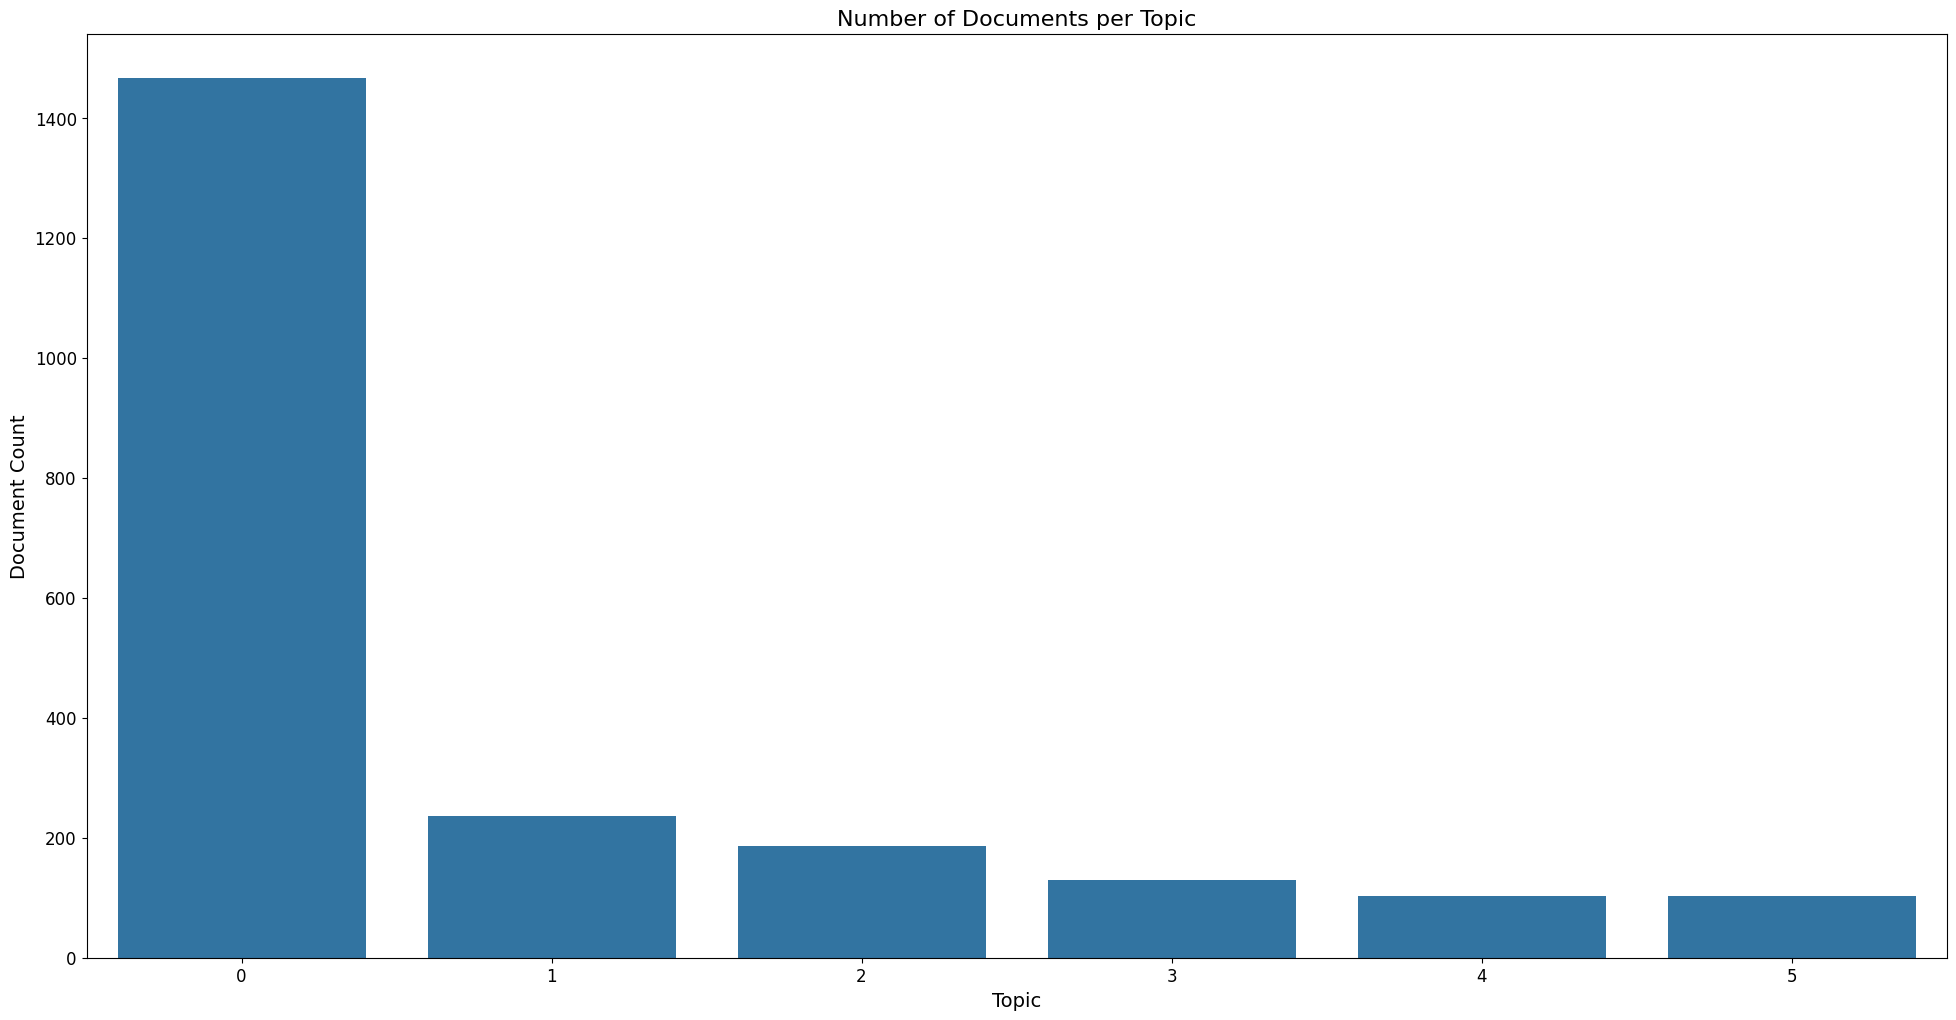

<Figure size 2000x1200 with 0 Axes>

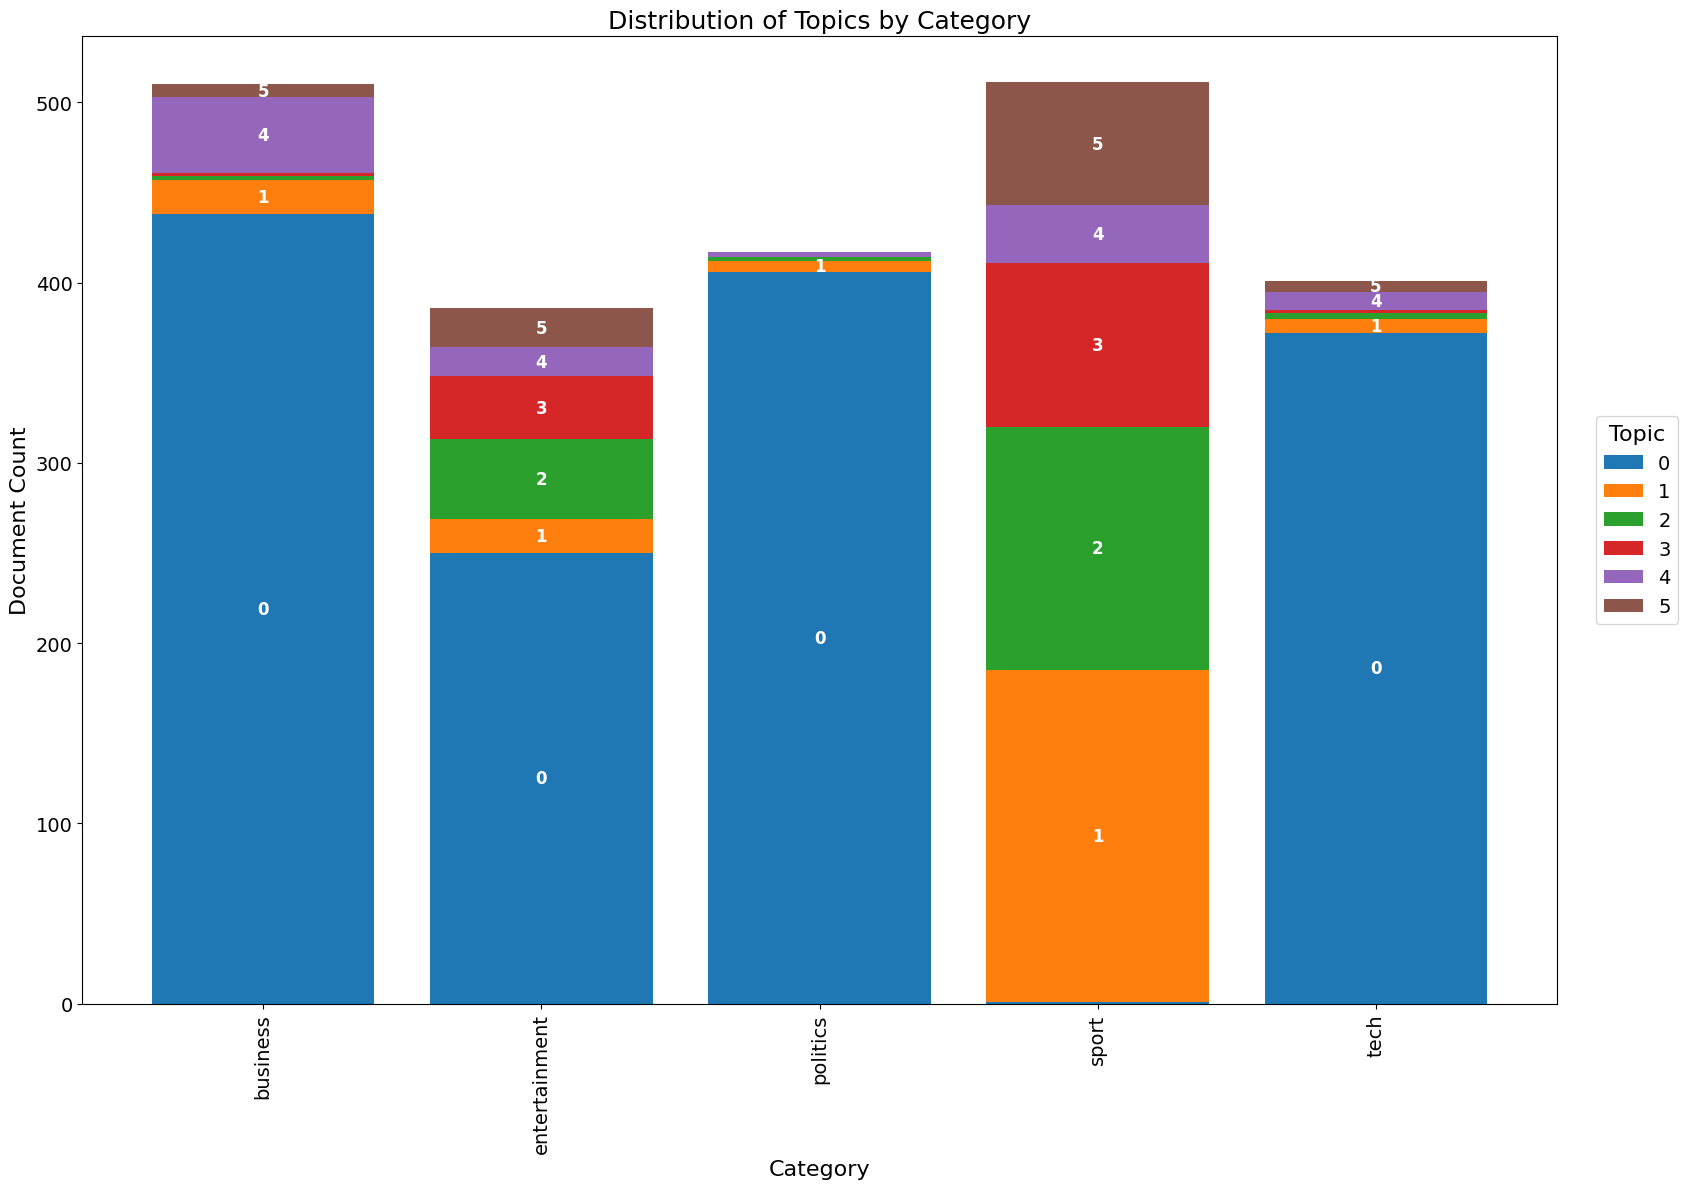

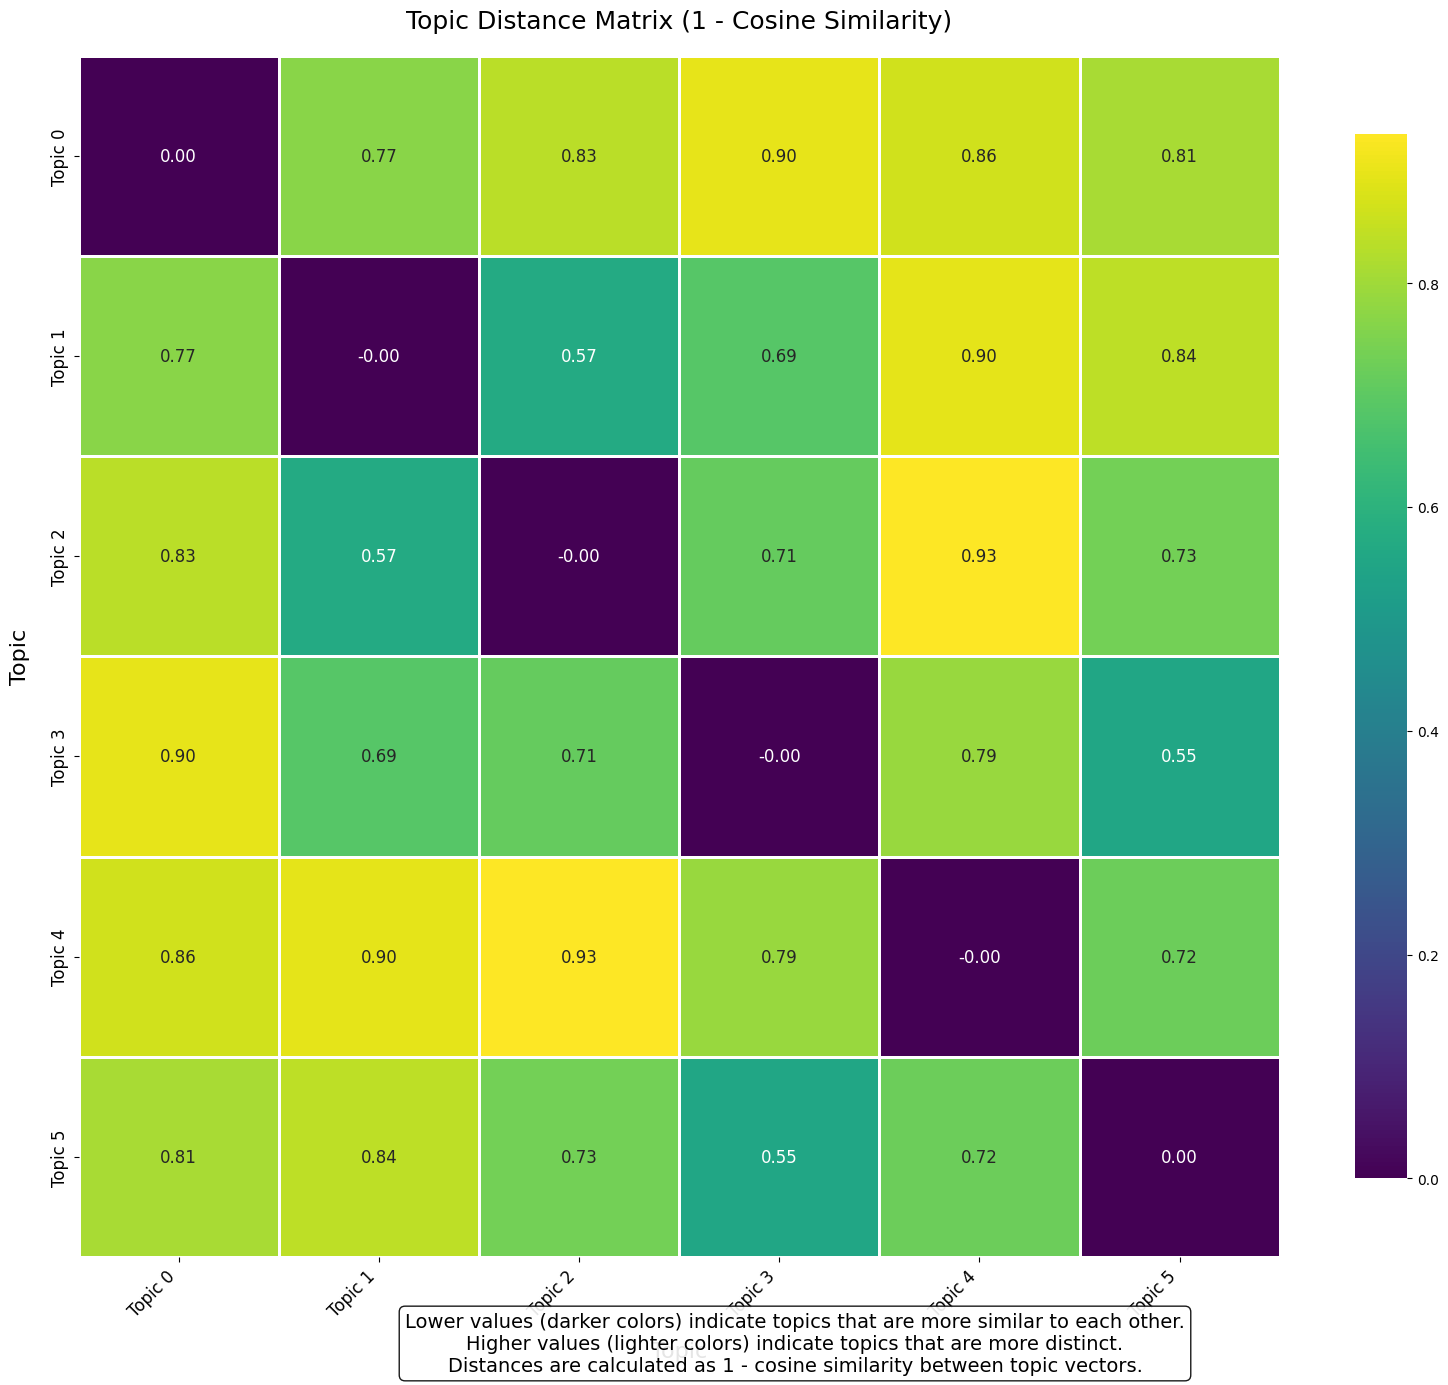

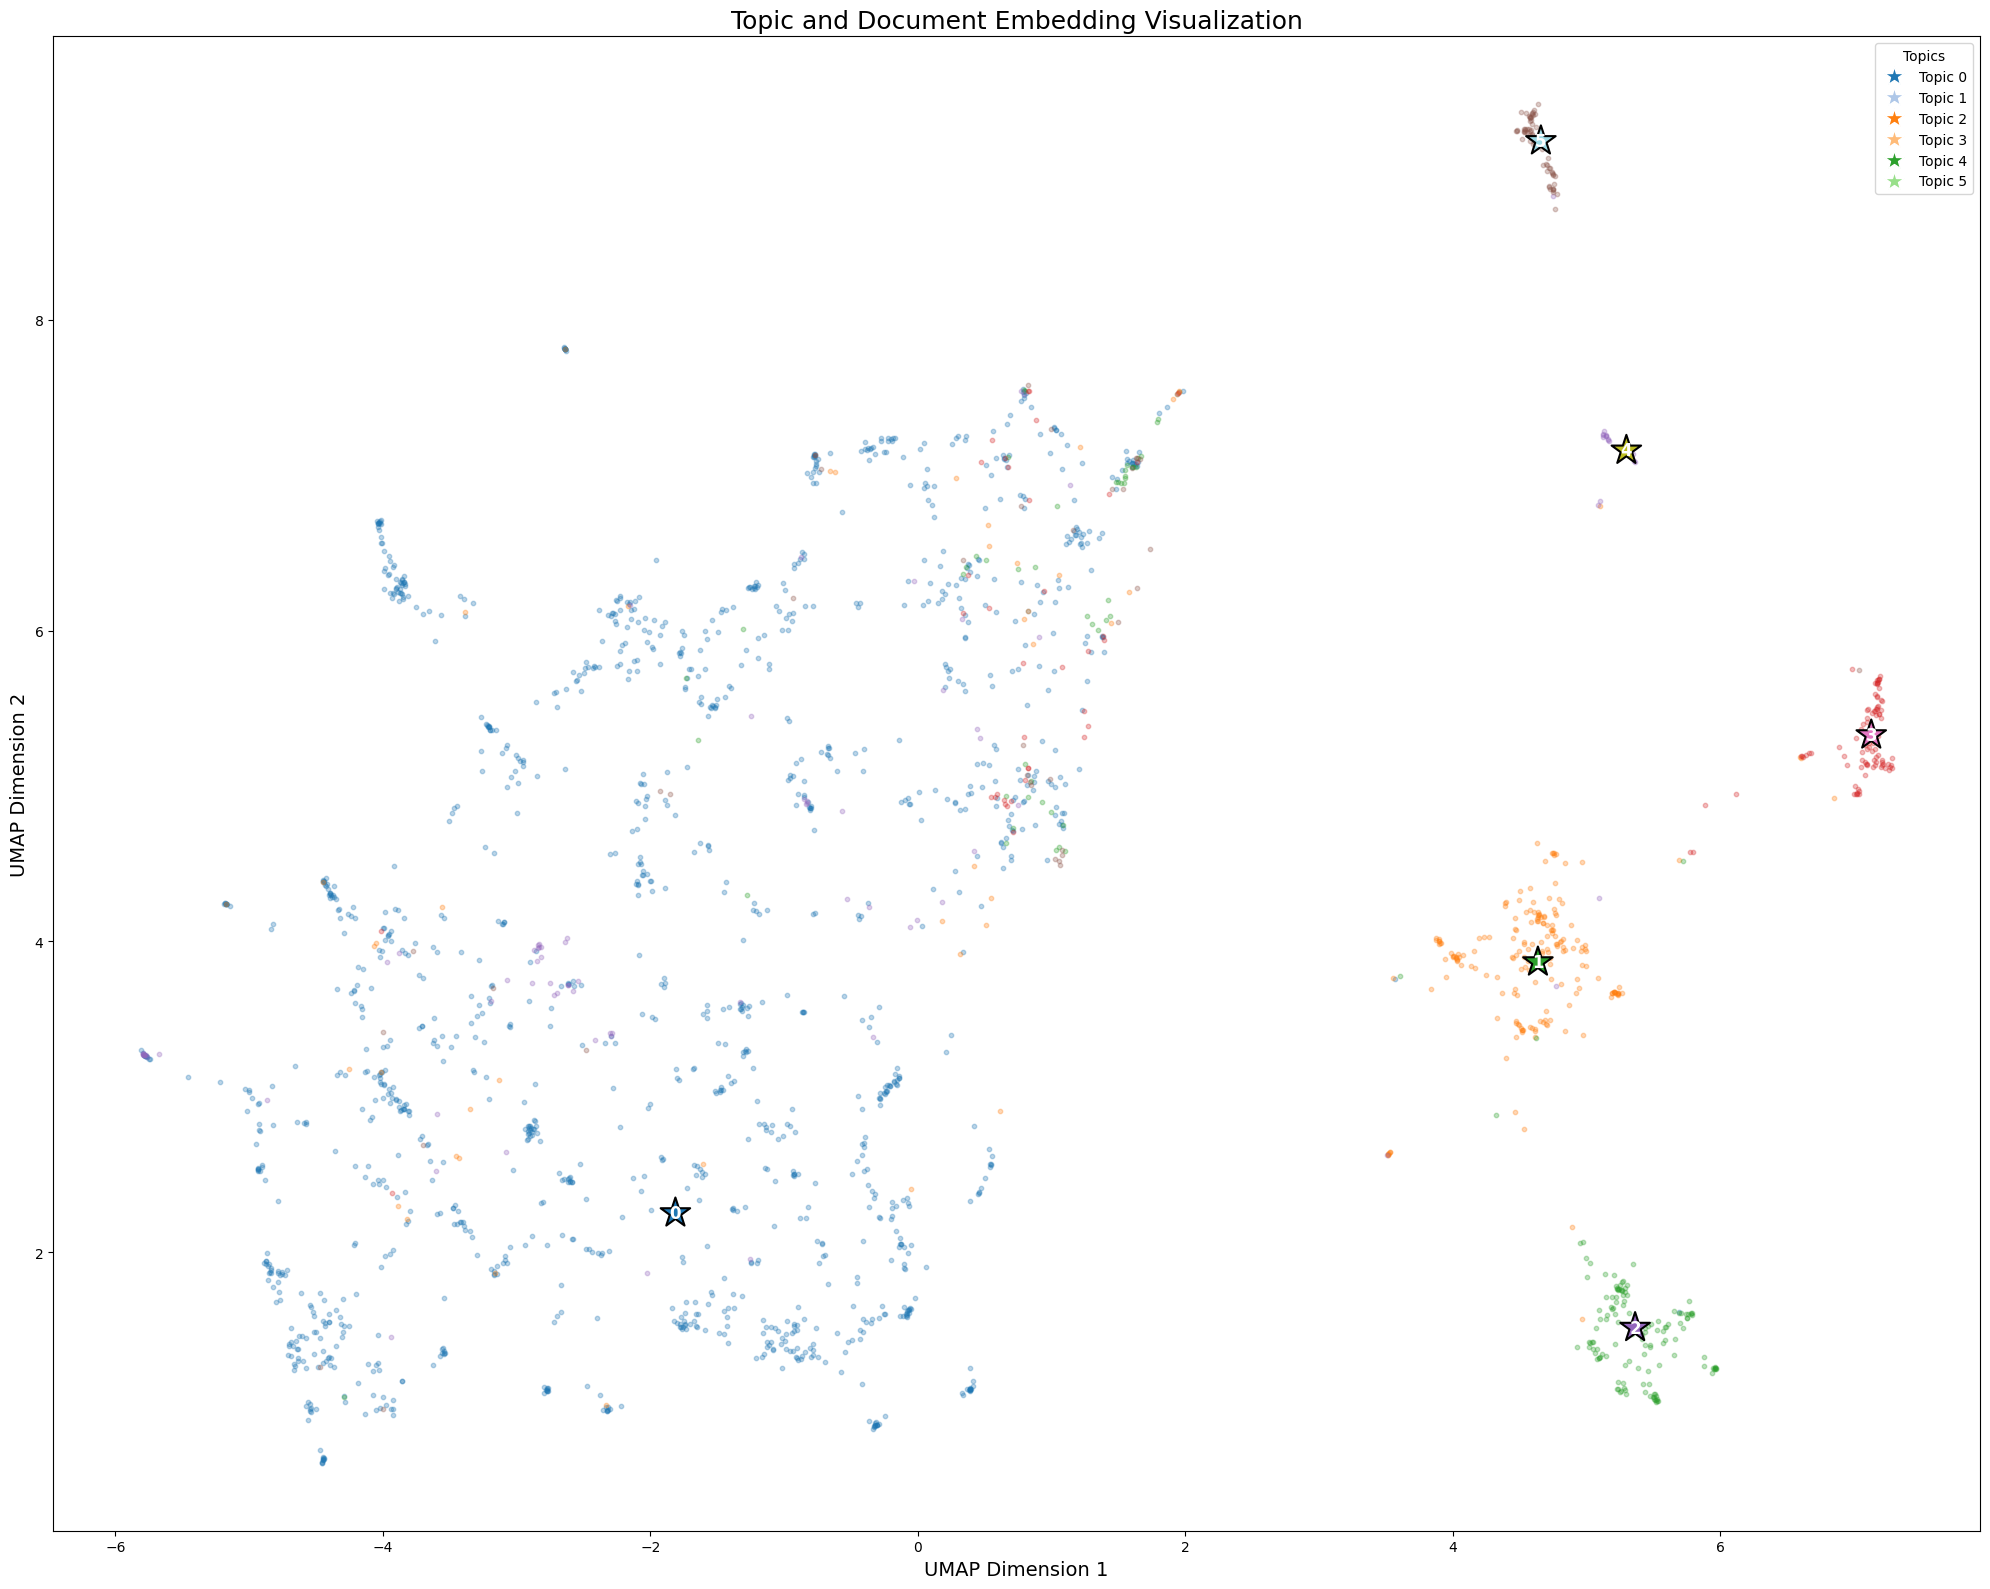

In [ ]:
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from top2vec import Top2Vec
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import umap

warnings.filterwarnings('ignore')
np.random.seed(42)

df = pd.read_csv("bbc_dataset_preprocessed.csv")

# Dataset-specific variables
TEXT_COLUMN = 'lemmatized_normalized_text'      # Column containing text data
CATEGORY_COLUMN = 'category'                    # Column containing category data
TARGET_TOPICS = 15                              # Preferred number of topics

# Hyperparameter ranges to test
MIN_COUNT_RANGE = [10, 20]                      # Controls vocabulary size
N_NEIGHBORS_RANGE = [5, 15]                     # Affects clustering density

# 1. Prepare text data
documents = df[TEXT_COLUMN].tolist()
document_ids = np.arange(len(documents))

# 2. Function to train and evaluate Top2Vec models
def evaluate_top2vec_models(documents, document_ids, min_count_range, n_neighbors_range, verbose=True):
    """
    Train and evaluate Top2Vec models with different hyperparameters

    Parameters:
    -----------
    documents: list of str
        Document texts
    document_ids: list or array
        Document IDs
    min_count_range: list of int
        Range of min_count values to try (controls vocab size)
    n_neighbors_range: list of int
        Range of n_neighbors values to try (affects clustering)
    verbose: bool
        Whether to print progress

    Returns:
    --------
    DataFrame with evaluation results
    """
    results = []

    # Create vectorizer for TC and TD calculations
    vectorizer = CountVectorizer(
        max_df=0.95,
        min_df=2,
        stop_words='english',
        max_features=5000
    )
    X = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()

    for min_count in min_count_range:
        for n_neighbors in n_neighbors_range:
            if verbose:
                print(f"Training model with min_count={min_count}, n_neighbors={n_neighbors}...")

            # Train Top2Vec model
            try:
                model = Top2Vec(
                    documents=documents,
                    document_ids=document_ids,
                    min_count=min_count,
                    embedding_model='doc2vec',  # Use doc2vec for embedding
                    umap_args={'n_neighbors': n_neighbors, 'n_components': 5, 'metric': 'cosine'},
                    hdbscan_args={'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom'},
                    workers=8,
                    verbose=verbose
                )

                n_topics = model.get_num_topics()

                if n_topics > 0:
                    # Get word vectors for topic coherence and diversity
                    topic_words_dict = {}
                    topic_word_dist_matrix = []

                    # Convert Top2Vec word scores to format similar to LDA components for TC/TD calculation
                    for topic_idx in range(n_topics):
                        words, word_scores = model.get_topics()[0][topic_idx], model.get_topics()[1][topic_idx]
                        topic_words_dict[topic_idx] = words

                        # Create a topic-word distribution vector
                        topic_word_dist = np.zeros(len(feature_names))
                        for word, score in zip(words, word_scores):
                            if word in vectorizer.vocabulary_:
                                word_idx = vectorizer.vocabulary_[word]
                                topic_word_dist[word_idx] = score

                        # Normalize to make it a probability distribution
                        if np.sum(topic_word_dist) > 0:
                            topic_word_dist = topic_word_dist / np.sum(topic_word_dist)

                        topic_word_dist_matrix.append(topic_word_dist)

                    topic_word_dist_matrix = np.array(topic_word_dist_matrix)

                    # Calculate the same metrics as for LDA
                    topic_coherence = calculate_topic_coherence(topic_word_dist_matrix, X, feature_names)
                    avg_coherence = np.mean(topic_coherence) if topic_coherence else 0
                    topic_diversity = calculate_topic_diversity(topic_word_dist_matrix)

                    # Store results
                    results.append({
                        'min_count': min_count,
                        'n_neighbors': n_neighbors,
                        'n_topics': n_topics,
                        'avg_coherence': avg_coherence,
                        'topic_diversity': topic_diversity,
                        'model': model,
                        'topic_words_dict': topic_words_dict,
                        'topic_word_dist_matrix': topic_word_dist_matrix
                    })

                    if verbose:
                        print(f"  Found {n_topics} topics")
                        print(f"  Avg coherence: {avg_coherence:.4f}")
                        print(f"  Topic diversity: {topic_diversity:.4f}")
                else:
                    if verbose:
                        print("  No topics found with these parameters")

            except Exception as e:
                if verbose:
                    print(f"  Error with parameters min_count={min_count}, n_neighbors={n_neighbors}: {e}")

    return pd.DataFrame(results)

# Topic Coherence calculation function
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]

    for topic_idx, topic_dist in enumerate(topic_word_dist):
        # Get top N words for this topic
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(top_word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(top_word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_dist in topic_word_dist:
        top_word_indices = topic_dist.argsort()[:-top_n-1:-1]
        topics_top_words.append(set(top_word_indices))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topic_word_dist) * top_n)

# 3. Run evaluation
print("Evaluating Top2Vec models with different parameters...")
evaluation_results = evaluate_top2vec_models(
    documents=documents,
    document_ids=document_ids,
    min_count_range=MIN_COUNT_RANGE,
    n_neighbors_range=N_NEIGHBORS_RANGE
)

# 4. Plot evaluation metrics
# Create a pivot table for visualization
coherence_pivot = evaluation_results.pivot(
    index='min_count',
    columns='n_neighbors',
    values='avg_coherence'
)

diversity_pivot = evaluation_results.pivot(
    index='min_count',
    columns='n_neighbors',
    values='topic_diversity'
)

n_topics_pivot = evaluation_results.pivot(
    index='min_count',
    columns='n_neighbors',
    values='n_topics'
)

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Topic count heatmap
sns.heatmap(n_topics_pivot, annot=True, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('Number of Topics', fontsize=14)
axes[0].set_xlabel('n_neighbors', fontsize=12)
axes[0].set_ylabel('min_count', fontsize=12)

# Coherence heatmap
sns.heatmap(coherence_pivot, annot=True, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('Average Topic Coherence (higher is better)', fontsize=14)
axes[1].set_xlabel('n_neighbors', fontsize=12)
axes[1].set_ylabel('min_count', fontsize=12)

# Diversity heatmap
sns.heatmap(diversity_pivot, annot=True, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('Topic Diversity (higher is better)', fontsize=14)
axes[2].set_xlabel('n_neighbors', fontsize=12)
axes[2].set_ylabel('min_count', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Calculate combined score for each model
# Normalize metrics
normalized_coherence = (evaluation_results['avg_coherence'] - evaluation_results['avg_coherence'].min()) / \
                       (evaluation_results['avg_coherence'].max() - evaluation_results['avg_coherence'].min() + 1e-10)

normalized_diversity = (evaluation_results['topic_diversity'] - evaluation_results['topic_diversity'].min()) / \
                       (evaluation_results['topic_diversity'].max() - evaluation_results['topic_diversity'].min() + 1e-10)

# Normalize number of topics based on a target range
topic_score = 1 - abs(evaluation_results['n_topics'] - TARGET_TOPICS) / \
             (evaluation_results['n_topics'].max() - evaluation_results['n_topics'].min() + 1e-10)

# Combined score (equal weights)
evaluation_results['combined_score'] = (normalized_coherence + normalized_diversity + topic_score) / 3

# 6. Find optimal model
best_model_idx = evaluation_results['combined_score'].idxmax()
best_model_params = evaluation_results.loc[best_model_idx]

print("\nBest model parameters:")
print(f"min_count: {best_model_params['min_count']}")
print(f"n_neighbors: {best_model_params['n_neighbors']}")
print(f"Number of topics: {best_model_params['n_topics']}")
print(f"Average coherence: {best_model_params['avg_coherence']:.4f}")
print(f"Topic diversity: {best_model_params['topic_diversity']:.4f}")

# 7. Get the best model
best_model = best_model_params['model']

# 8. Display topics
print("\nTop 10 words per topic:")
topic_words = {}
for i in range(best_model_params['n_topics']):
    words, word_scores = best_model.get_topics()[0][i], best_model.get_topics()[1][i]
    topic_words[i] = words[:10]
    print(f"Topic {i}: {' '.join(words[:10])}")

# 9. Document distribution across topics
topic_distribution = best_model.get_documents_topics(document_ids)[0]
document_topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'topic': topic_distribution,
    'category': df[CATEGORY_COLUMN]
})

# Plot document count by topic
plt.figure(figsize=(24, 12))
sns.countplot(x='topic', data=document_topic_df)
plt.title('Number of Documents per Topic', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Document Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 10. Analysis by category
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(document_topic_df['category'], document_topic_df['topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = i
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# 11. Topic distance visualization
# Get topic vectors
topic_vectors = np.array([best_model.topic_vectors[i] for i in range(best_model_params['n_topics'])])

# Calculate cosine similarity between topics
topic_similarities = cosine_similarity(topic_vectors)

# Convert to distances (1 - similarity)
topic_distances = 1 - topic_similarities

# Plot distance matrix
plt.figure(figsize=(16, 14))
topic_labels = [f"Topic {i}" for i in range(best_model_params['n_topics'])]

ax = sns.heatmap(
    topic_distances,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

# Improve the appearance of the plot
plt.title('Topic Distance Matrix (1 - Cosine Similarity)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.figtext(
    0.5, 0.01,
    "Lower values (darker colors) indicate topics that are more similar to each other.\n"
    "Higher values (lighter colors) indicate topics that are more distinct.\n"
    "Distances are calculated as 1 - cosine similarity between topic vectors.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()

# 12. Visualize topic and document embeddings in 2D
# Combine document and topic vectors
combined_vectors = np.vstack([best_model.document_vectors, topic_vectors])

# Use UMAP to reduce to 2D
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
embedding = reducer.fit_transform(combined_vectors)

# Split back into documents and topics
doc_embedding = embedding[:len(documents)]
topic_embedding = embedding[len(documents):]

# Get dominant topic for each document for coloring
doc_topics = best_model.get_documents_topics(document_ids)[0]

# Create plot
plt.figure(figsize=(20, 16))

# Plot documents colored by topic
for topic_idx in range(best_model_params['n_topics']):
    topic_docs = doc_topics == topic_idx
    plt.scatter(
        doc_embedding[topic_docs, 0],
        doc_embedding[topic_docs, 1],
        alpha=0.3,
        s=10,
        label=f"Documents in Topic {topic_idx}"
    )

# Plot topic centers with larger markers
plt.scatter(
    topic_embedding[:, 0],
    topic_embedding[:, 1],
    c=range(best_model_params['n_topics']),
    cmap='tab20',
    s=500,
    marker='*',
    edgecolor='black',
    linewidth=1.5
)

# Add topic numbers
for i in range(best_model_params['n_topics']):
    plt.text(
        topic_embedding[i, 0],
        topic_embedding[i, 1],
        str(i),
        fontsize=12,
        ha='center',
        va='center',
        color='white',
        fontweight='bold'
    )

plt.title('Topic and Document Embedding Visualization', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)

# Add a small legend for topics only
topic_legend = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor=plt.cm.tab20(i),
                           markersize=15, label=f"Topic {i}") for i in range(min(10, best_model_params['n_topics']))]
plt.legend(handles=topic_legend, title="Topics", loc='upper right')

plt.tight_layout()
plt.show()

The first iteration was the best meiner meinung nach

Maybe we need to change our evaluation method?

# BERTopic

In [ ]:
!pip install bertopic sentence-transformers umap-learn hdbscan plotly spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Processing 2225 documents
Loading sentence transformer model...


2025-04-23 18:49:48,520 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting BERTopic model...


Batches:   0%|          | 0/70 [00:00<?, ?it/s]

2025-04-23 18:49:55,455 - BERTopic - Embedding - Completed ✓
2025-04-23 18:49:55,456 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-23 18:50:04,745 - BERTopic - Dimensionality - Completed ✓
2025-04-23 18:50:04,746 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-23 18:50:04,852 - BERTopic - Cluster - Completed ✓
2025-04-23 18:50:04,856 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-23 18:50:05,357 - BERTopic - Representation - Completed ✓
2025-04-23 18:50:05,358 - BERTopic - Topic reduction - Reducing number of topics
2025-04-23 18:50:05,366 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-23 18:50:11,803 - BERTopic - Representation - Completed ✓
2025-04-23 18:50:11,806 - BERTopic - Topic reduction - Reduced number of topics from 50 to 20



======= Topic Information =======
Number of topics: 19
   Topic  Count                                Name  \
0     -1    447    -1_government_party_labour_child   
1      0    496             0_game_england_win_club   
2      1    248  1_election_labour_party_government   
3      2    144         2_firm_airline_share_profit   
4      3    141             3_music_band_album_song   
5      4    140             4_film_best_award_oscar   
6      5    124              5_site_user_virus_mail   
7      6     93   6_mobile_phone_technology_service   
8      7     59      7_game_console_gaming_nintendo   
9      8     59        8_economy_dollar_growth_rate   

                                      Representation  \
0  [government, party, labour, child, minister, t...   
1  [game, england, win, club, match, team, final,...   
2  [election, labour, party, government, minister...   
3  [firm, airline, share, profit, executive, mark...   
4  [music, band, album, song, chart, single, best...   
5 

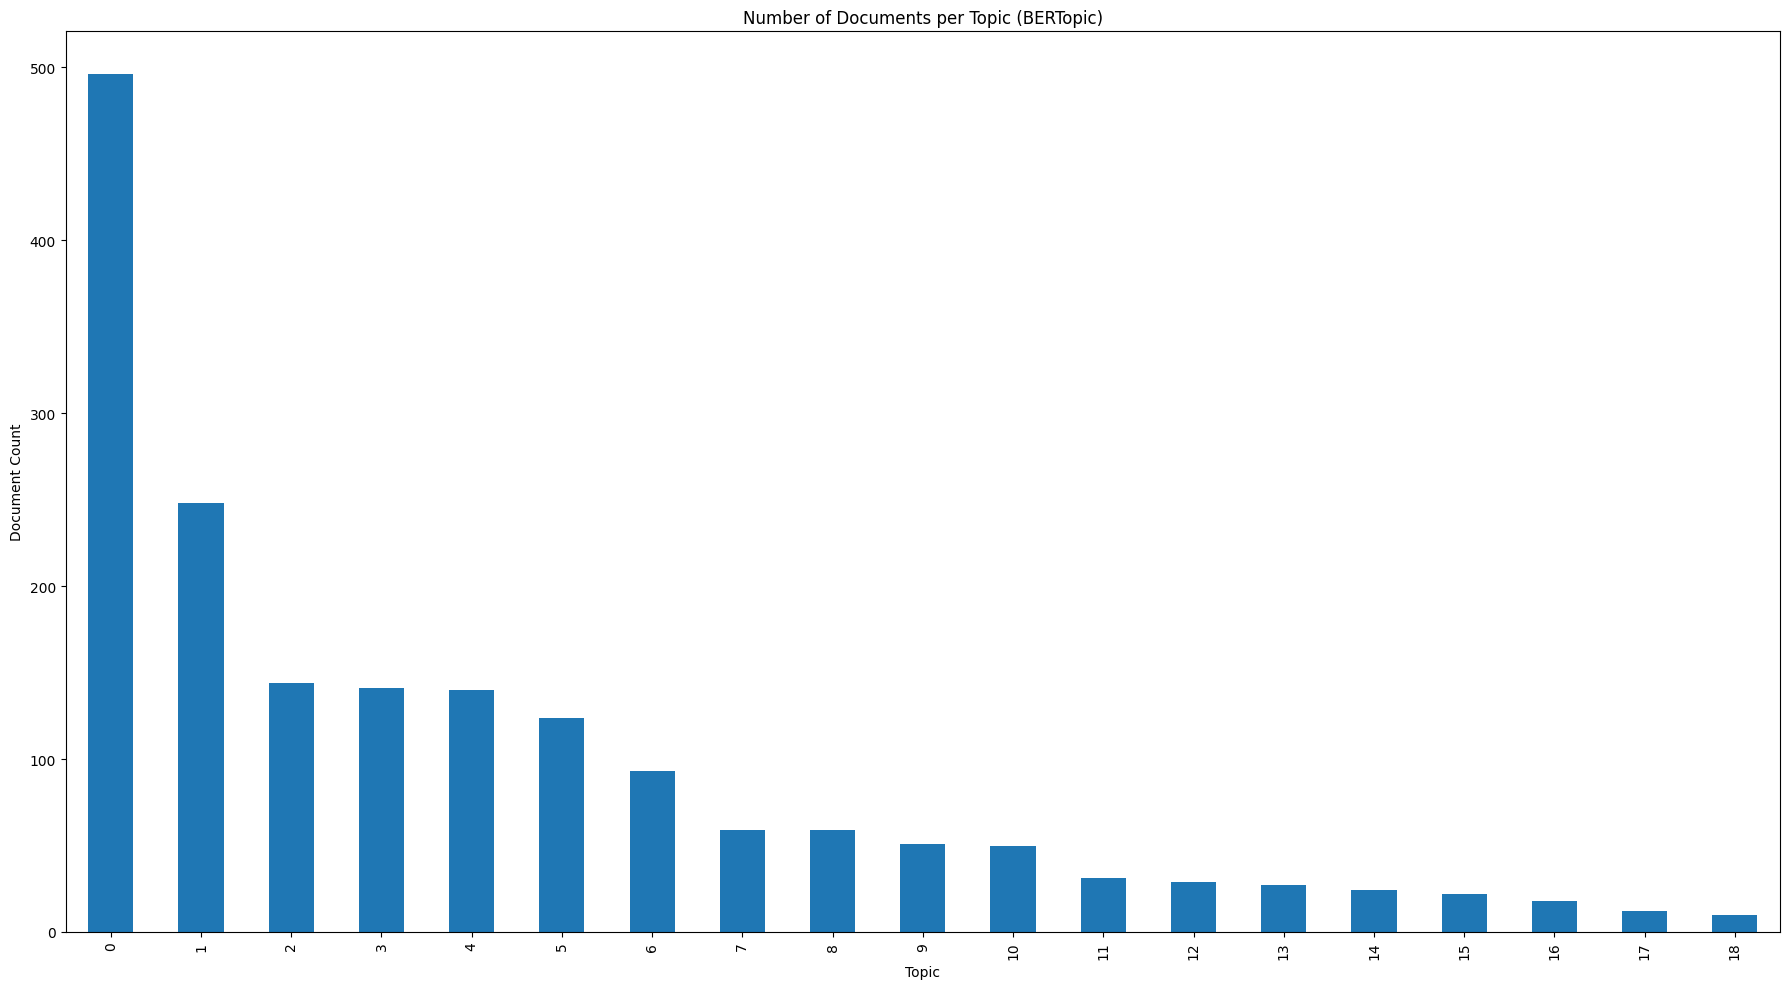

<Figure size 2000x1200 with 0 Axes>

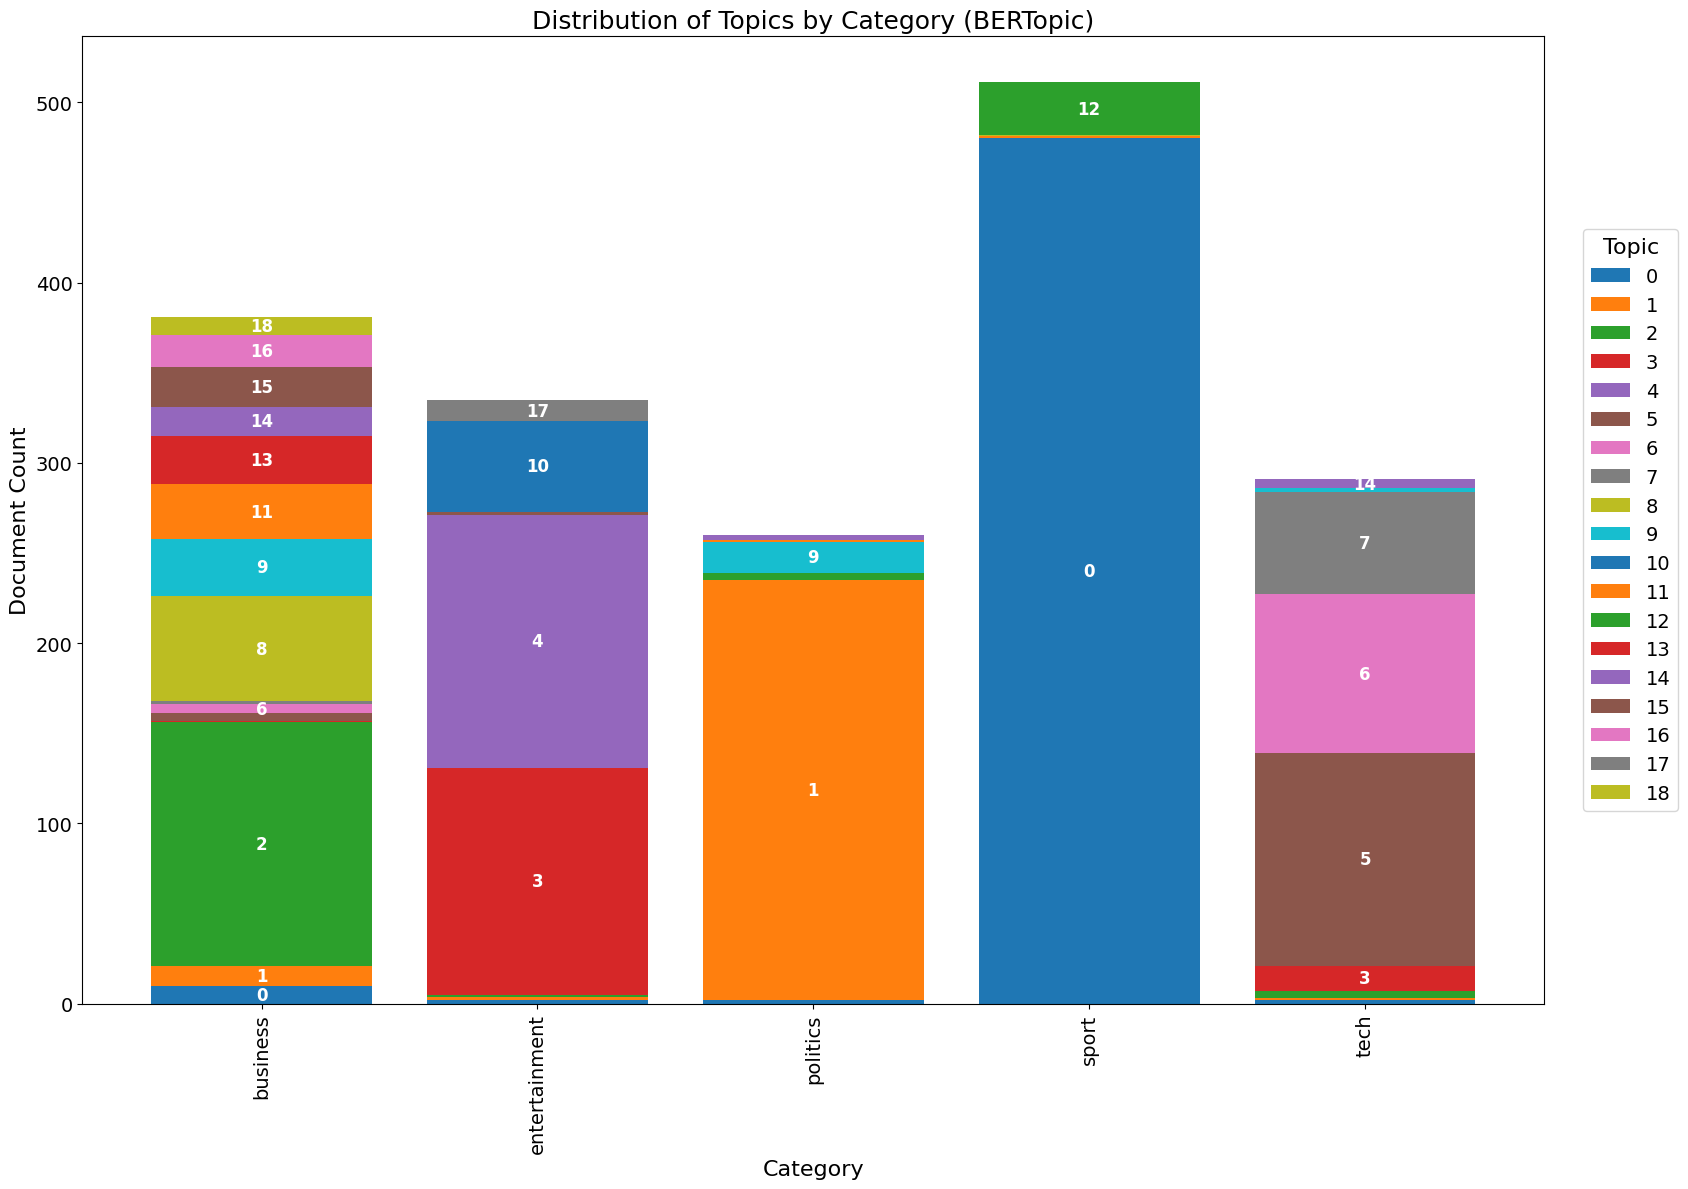

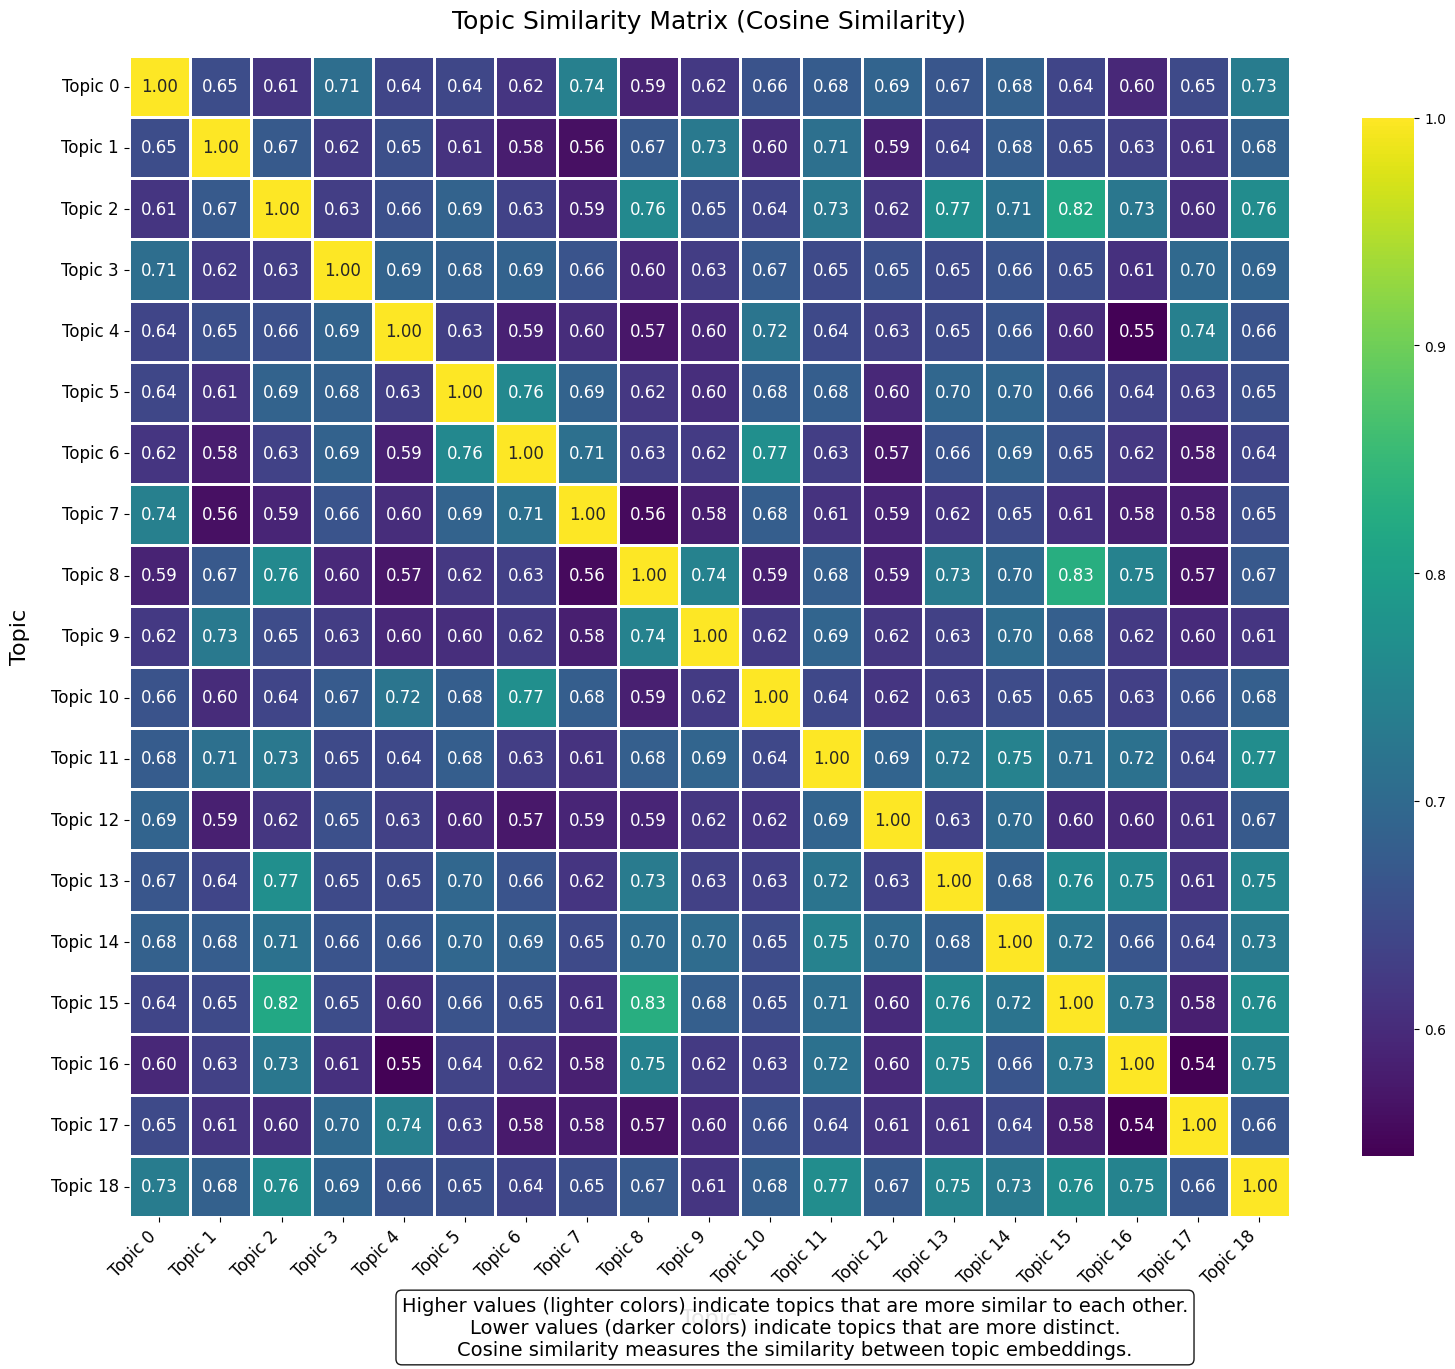

Network visualization not available in this version of BERTopic. Skipping.

======= Topic Coherence and Diversity Metrics =======
Creating document-term matrix for coherence calculation...
Document-term matrix shape: (2225, 5000)
Calculating Topic Coherence...
Calculating Topic Diversity...

Topic Coherence scores per topic:
Topic 0: 0.2393
Topic 1: 0.4212
Topic 2: 0.2403
Topic 3: 0.3825
Topic 4: 0.4197
Topic 5: 0.3414
Topic 6: 0.3859
Topic 7: 0.4631
Topic 8: 0.3370
Topic 9: 0.2798
Topic 10: 0.2879
Topic 11: 0.4963
Topic 12: 0.6410
Topic 13: 0.3277
Topic 14: 0.2023
Topic 15: 0.2962
Topic 16: 0.4006
Topic 17: 0.2930
Topic 18: 0.2897
Average Topic Coherence: 0.3550
Topic Diversity: 0.3495


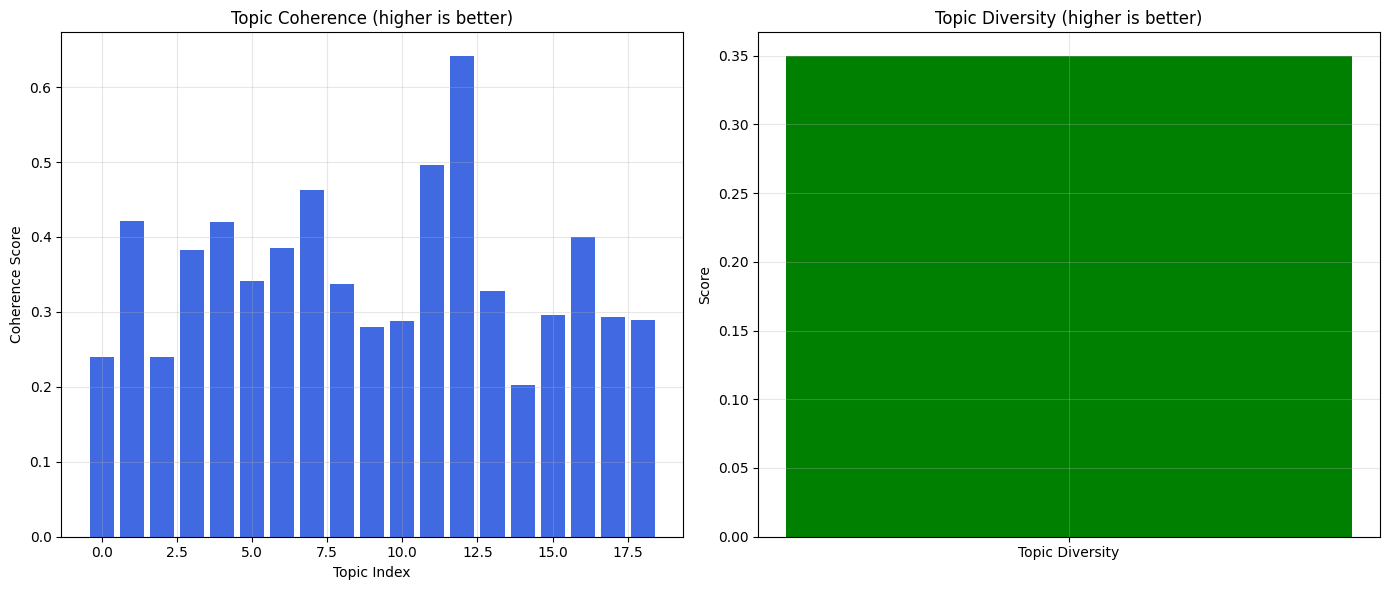


Execution time: 32.70 seconds

======= BERTopic Analysis Complete =======


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, coo_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time

# BERTopic and related libraries
from bertopic.representation import KeyBERTInspired, PartOfSpeech
from sklearn.metrics.pairwise import cosine_similarity
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP

warnings.filterwarnings('ignore')
np.random.seed(42)

# Start timer to measure performance
start_time = time.time()

# 1. Prepare text data
df = pd.read_csv("bbc_dataset_preprocessed.csv")
documents = df['lemmatized_normalized_text'].tolist()
categories = df['category'].tolist()

print(f"Processing {len(documents)} documents")

# 2. Initialize embedding model
# Choose other models based on our needs: https://www.sbert.net/docs/pretrained_models.html
print("Loading sentence transformer model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Smaller, faster model

# 3. Set up dimensionality reduction
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# 4. Set up clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# 5. Set up vectorization
vectorizer_model = CountVectorizer(
    max_df=0.95,            # Ignore terms that appear in more than 95% of documents
    min_df=2,               # Ignore terms that appear in fewer than 2 documents
    stop_words='english',
    max_features=5000       # Limit vocabulary size
)

# 6. Set up topic representation - using multiple approaches for better topics
representation_model = [
    KeyBERTInspired(),
    PartOfSpeech('en_core_web_sm')  # Need to download this: python -m spacy download en_core_web_sm
]

# 7. Create the BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ClassTfidfTransformer(),
    representation_model=representation_model,
    nr_topics=20,  # This limits the number of topics to 20
    verbose=True
)

# 8. Fit the model to our documents
print("Fitting BERTopic model...")
topics, probs = topic_model.fit_transform(documents)

# 9. Get information about the topics
topic_info = topic_model.get_topic_info()
print("\n======= Topic Information =======")
print(f"Number of topics: {len(topic_info) - 1}")  # -1 because BERTopic includes an "outlier" topic (-1)
print(topic_info.head(10))

# 10. Display top terms per topic (like in your LDA code)
print("\n======= Top Terms Per Topic =======")
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip the outlier topic
        print(f"Topic {topic_id}: {', '.join([word for word, _ in topic_model.get_topic(topic_id)[:10]])}")

# 11. Analyze document distribution across topics (similar to your LDA analysis)
# Count documents per topic
topic_counts = pd.Series(topics).value_counts().sort_index()
topic_counts = topic_counts[topic_counts.index != -1]  # Remove outlier topic

# Plot document count by topic
plt.figure(figsize=(18, 10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic (BERTopic)')
plt.xlabel('Topic')
plt.ylabel('Document Count')
plt.tight_layout()
plt.show()
plt.close()

# 12. Analysis by category
# Create a DataFrame with document-topic distribution
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': topics,
    'category': categories
})

# Remove outliers for clearer visualization
topic_df_filtered = topic_df[topic_df['dominant_topic'] != -1]

# Plot topic distribution by category
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df_filtered['category'], topic_df_filtered['dominant_topic'])
ax = category_topic_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 12),
    width=0.8
)

plt.title('Distribution of Topics by Category (BERTopic)', fontsize=18)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Document Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Position the legend outside the plot to the right
plt.legend(
    title='Topic',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

# Add topic numbers to each segment
for i, container in enumerate(ax.containers):
    topic_number = category_topic_counts.columns[i]
    for j, rect in enumerate(container):
        height = rect.get_height()
        if height > 4:
            # Get the center x,y coordinates of the bar segment
            x = rect.get_x() + rect.get_width()/2
            # For stacked bars, we need to find the vertical center of this segment
            y = rect.get_y() + height/2
            # Add the topic number at the center of the segment
            ax.text(x, y, str(topic_number),
                   ha='center',
                   va='center',
                   color='white',
                   fontweight='bold',
                   fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
plt.close()

# 13. Visualize topic similarity using BERTopic's built-in functionality
topic_model.visualize_topics().write_html("bertopic_topic_visualization.html")

# 14. Topic distance visualization (similar to your LDA implementation)
# Get embeddings for each topic
topic_embeddings = {}
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip the outlier topic
        # Get words in the topic
        words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
        # Get embeddings for these words
        word_embeddings = embedding_model.encode(words)
        # Average the embeddings to get a topic embedding
        topic_embeddings[topic_id] = np.mean(word_embeddings, axis=0)

# Calculate similarity matrix
topic_ids = sorted(list(topic_embeddings.keys()))
similarity_matrix = np.zeros((len(topic_ids), len(topic_ids)))

for i, topic_i in enumerate(topic_ids):
    for j, topic_j in enumerate(topic_ids):
        # Calculate cosine similarity between topic embeddings
        similarity = cosine_similarity([topic_embeddings[topic_i]], [topic_embeddings[topic_j]])[0][0]
        similarity_matrix[i, j] = similarity

# Plot similarity matrix
plt.figure(figsize=(16, 14))
topic_labels = [f"Topic {i}" for i in topic_ids]

ax = sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=1,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    square=True,
    xticklabels=topic_labels,
    yticklabels=topic_labels,
    annot_kws={"size": 12}
)

# Improve the appearance of the plot
plt.title('Topic Similarity Matrix (Cosine Similarity)', fontsize=18, pad=20)
plt.xlabel('Topic', fontsize=16, labelpad=15)
plt.ylabel('Topic', fontsize=16, labelpad=15)

# Increase the font size of tick labels
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Add a text explanation in the figure
plt.figtext(
    0.5, 0.01,
    "Higher values (lighter colors) indicate topics that are more similar to each other.\n"
    "Lower values (darker colors) indicate topics that are more distinct.\n"
    "Cosine similarity measures the similarity between topic embeddings.",
    ha='center',
    fontsize=14,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9)
)

plt.tight_layout()
plt.show()
plt.close()

# 15. Additional BERTopic visualizations not available in LDA
# Topic hierarchy
topic_model.visualize_hierarchy().write_html("bertopic_hierarchy.html")

# Topic similarity network - using the correct method name
try:
    # Try newer method name if available
    topic_model.visualize_network().write_html("bertopic_network.html")
except AttributeError:
    try:
        # Try older method name if available
        topic_model.visualize_topics_network().write_html("bertopic_network.html")
    except AttributeError:
        print("Network visualization not available in this version of BERTopic. Skipping.")

# Topic distributions over time (if we have a timestamp column)
if 'timestamp' in df.columns:
    topics_over_time = topic_model.topics_over_time(documents, df['timestamp'], nr_bins=20)
    topic_model.visualize_topics_over_time(topics_over_time).write_html("bertopic_over_time.html")

# 16. Dynamic Topic Representation (if needed)
# topic_model.update_topics(documents, topics, n_gram_range=(1, 3))

# 17. Evaluate TC and TD metrics (similar to LDA implementation)
print("\n======= Topic Coherence and Diversity Metrics =======")

# Create document-term matrix for BERTopic (needed for coherence calculation)
print("Creating document-term matrix for coherence calculation...")
vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english',
    max_features=5000
)
X = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()
print(f"Document-term matrix shape: {X.shape}")

# Topic Coherence calculation function (reused from LDA implementation)
def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
    """Calculate TC metric based on normalized pointwise mutual information (NPMI)"""
    coherence_scores = []
    n_docs = dtm.shape[0]
    vocab_dict = {word: idx for idx, word in enumerate(feature_names)}

    for topic_id, topic_words in topic_word_dist.items():
        if topic_id == -1:  # Skip outlier topic
            continue

        # Get words and ensure they exist in the vocabulary
        top_words = [word for word, _ in topic_words[:top_n]]
        valid_words = [word for word in top_words if word in vocab_dict]

        # Skip if not enough valid words
        if len(valid_words) < 2:
            coherence_scores.append(0)
            continue

        # Get word indices in the vocabulary
        word_indices = [vocab_dict[word] for word in valid_words if word in vocab_dict]

        # Calculate average NPMI for all word pairs
        npmi_scores = []

        for i, word_i_idx in enumerate(word_indices):
            word_i_docs = dtm[:, word_i_idx].nonzero()[0]
            for j, word_j_idx in enumerate(word_indices[i+1:], i+1):
                word_j_docs = dtm[:, word_j_idx].nonzero()[0]

                # Get co-occurrence
                co_docs = set(word_i_docs).intersection(set(word_j_docs))
                co_freq = len(co_docs)

                # Calculate NPMI: log(p(i,j)/(p(i)*p(j)))/(-log(p(i,j)))
                if co_freq > 0:
                    p_i = len(word_i_docs) / n_docs
                    p_j = len(word_j_docs) / n_docs
                    p_ij = co_freq / n_docs

                    pmi = np.log(p_ij / (p_i * p_j))
                    npmi = pmi / (-np.log(p_ij))
                    npmi_scores.append(npmi)

        # Average NPMI for this topic
        if npmi_scores:
            coherence_scores.append(np.mean(npmi_scores))
        else:
            coherence_scores.append(0)

    return coherence_scores

# Topic Diversity calculation function (adapted for BERTopic)
def calculate_topic_diversity(topic_word_dist, top_n=25):
    """Calculate TD metric based on proportion of unique words in top N words across all topics"""
    # Get top N words for each topic
    topics_top_words = []
    for topic_id, words in topic_word_dist.items():
        if topic_id == -1:  # Skip outlier topic
            continue
        top_words = [word for word, _ in words[:top_n]]
        topics_top_words.append(set(top_words))

    # Count unique words across all topics
    all_top_words = set()
    for topic_words in topics_top_words:
        all_top_words.update(topic_words)

    # Calculate diversity: unique words / (topics * top_n)
    return len(all_top_words) / (len(topics_top_words) * top_n)

# Get topic-word distributions for BERTopic
topic_word_dist = {}
num_topics = 0
for topic_id in topic_info['Topic'].unique():
    if topic_id != -1:  # Skip outlier topic
        topic_word_dist[topic_id] = topic_model.get_topic(topic_id)
        num_topics += 1

# Calculate TC and TD metrics
print("Calculating Topic Coherence...")
coherence_scores = calculate_topic_coherence(topic_word_dist, X, feature_names)
avg_coherence = np.mean(coherence_scores)

print("Calculating Topic Diversity...")
topic_diversity = calculate_topic_diversity(topic_word_dist)

# Display TC and TD metrics
print("\nTopic Coherence scores per topic:")
for i, score in enumerate(coherence_scores):
    topic_id = list(topic_word_dist.keys())[i]
    print(f"Topic {topic_id}: {score:.4f}")
print(f"Average Topic Coherence: {avg_coherence:.4f}")
print(f"Topic Diversity: {topic_diversity:.4f}")

# Plot TC and TD metrics
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(coherence_scores)), coherence_scores, color='royalblue')
plt.xlabel('Topic Index')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence (higher is better)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(['Topic Diversity'], [topic_diversity], color='green', width=0.4)
plt.ylabel('Score')
plt.title('Topic Diversity (higher is better)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

# Print execution time
end_time = time.time()
print(f"\nExecution time: {end_time - start_time:.2f} seconds")

print("\n======= BERTopic Analysis Complete =======")

# FASTopic

In [ ]:
!pip install fastopic topmost sentence-transformers scikit-learn pandas numpy matplotlib seaborn tqdm plotly bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from fastopic import FASTopic
from topmost.preprocess import Preprocess

warnings.filterwarnings('ignore')
np.random.seed(42)

# Create output directory if it doesn't exist
output_dir = "fastopic_outputs_v3_defaults"
os.makedirs(output_dir, exist_ok=True)

# Start timer to measure performance
start_time = time.time()

# 1. Prepare text data
print("Loading dataset...")
df = pd.read_csv("bbc_dataset_preprocessed.csv")

if 'text' in df.columns:
    print("Using original 'text' column for FASTopic.")
    documents = df['text'].tolist()
else:
    raise ValueError("Dataset must contain the 'text' column.")

categories = df['category'].tolist()
print(f"Processing {len(documents)} documents")

# 2. Initialize FASTopic Preprocessor (USING DEFAULTS)
print("Initializing FASTopic Preprocessor (using defaults)...")
preprocess = Preprocess()

# 3. Initialize FASTopic model
print("Initializing FASTopic model...")
n_topics_target = 20 # Desired number of topics
topic_model = FASTopic(
    n_topics_target,
    preprocess
)

# (Optional) Load embedding model separately if needed for similarity approx.
print("Loading sentence transformer model (for potential similarity calculation)...")
embedding_model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(embedding_model_name)


# 4. Fit the model to our documents (USING DEFAULT EPOCHS)
print("\nFitting FASTopic model (using default epochs)...")
top_words_list, doc_topic_dist = topic_model.fit_transform(documents)

# Derive dominant topic assignments
topics = np.argmax(doc_topic_dist, axis=1)
actual_num_topics = doc_topic_dist.shape[1]
print(f"Model fitting complete. Found {actual_num_topics} topics.")
if actual_num_topics != n_topics_target:
     print(f"Note: The actual number of topics ({actual_num_topics}) differs from the target ({n_topics_target}).")

# 5. Get information about the topics
print("\n======= Topic Information =======")
print(f"Number of topics found: {actual_num_topics}")

# 6. Display top terms per topic and store for TC/TD
print("\n======= Top Terms Per Topic =======")
topic_word_dist = {} # Store for later use (TC/TD)
num_words_to_display = 10
num_words_for_coherence = 10
num_words_for_diversity = 15

# Iterate through the actual number of topics found
for topic_id in range(actual_num_topics):
    try:
        # Call get_topic with only topic_idx
        all_topic_words_scores = topic_model.get_topic(topic_idx=topic_id)

        if all_topic_words_scores:
            # Slice for display
            display_words_scores = all_topic_words_scores[:num_words_to_display]
            # Store the needed number for metrics (get_topic might return more or less than 25)
            topic_word_dist[topic_id] = all_topic_words_scores # Store potentially more words for metrics flexibility

            print(f"Topic {topic_id}: {', '.join([word for word, _ in display_words_scores])}")
        else:
             print(f"Topic {topic_id}: No words returned by get_topic.")
             if topic_id < len(top_words_list) and top_words_list[topic_id]:
                 top_words_only = top_words_list[topic_id][:num_words_to_display]
                 print(f"Topic {topic_id} (from list): {', '.join(top_words_only)}")
             else:
                 print(f"Topic {topic_id}: Could not retrieve words.")

    except Exception as e:
        print(f"Error processing topic {topic_id}: {e}")

if not topic_word_dist:
    print("\nWarning: 'topic_word_dist' is empty. Similarity and TC/TD calculation will be skipped.")
else:
    print(f"\nSuccessfully retrieved top words for {len(topic_word_dist)} topics.")


# 7. Analyze document distribution across topics
print("\n======= Document Distribution Analysis =======")
topic_counts = pd.Series(topics).value_counts().sort_index()
plt.figure(figsize=(18, 10))
topic_counts.plot(kind='bar')
plt.title('Number of Documents per Topic (FASTopic - Defaults)')
plt.xlabel('Topic ID')
plt.ylabel('Document Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "fastopic_doc_distribution.png"))
print(f"Saved document distribution plot to {os.path.join(output_dir, 'fastopic_doc_distribution.png')}")
plt.close()

# 8. Analysis by category
print("\n======= Category Distribution Analysis =======")
topic_df = pd.DataFrame({
    'document_id': range(len(documents)),
    'dominant_topic': topics,
    'category': categories
})
plt.figure(figsize=(20, 12))
category_topic_counts = pd.crosstab(topic_df['category'], topic_df['dominant_topic'])

if not category_topic_counts.empty:
    category_topic_counts = category_topic_counts.sort_index(axis=1)
    ax = category_topic_counts.plot(
        kind='bar', stacked=True, figsize=(20, 12), width=0.8, colormap='tab20'
    )
    plt.title('Distribution of Topics by Category (FASTopic - Defaults)', fontsize=18)
    plt.xlabel('Category', fontsize=16)
    plt.ylabel('Document Count', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(
        title='Topic', loc='center left', bbox_to_anchor=(1.02, 0.5),
        fontsize=12, title_fontsize=14,
        ncol = 1 if actual_num_topics <= 25 else (actual_num_topics // 25) + 1
    )
    add_labels_to_bars = True if actual_num_topics <= 25 else False
    if add_labels_to_bars:
        print("Adding labels to category plot bars...")
        for i, container in enumerate(ax.containers):
            topic_id = category_topic_counts.columns[i]
            labels = [f"{topic_id}" if v > 4 else '' for v in container.datavalues]
            if labels: ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=9, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig(os.path.join(output_dir, "fastopic_category_distribution.png"))
    print(f"Saved category distribution plot to {os.path.join(output_dir, 'fastopic_category_distribution.png')}")
    plt.close()
else:
    print("Category topic counts DataFrame is empty. Skipping plot.")


# 9. Topic Similarity Matrix (Approximation Method)
print("\n======= Topic Similarity Analysis (Approximation) =======")
print("Calculating topic similarity using average of top word embeddings...")
topic_embeddings_approx = {}
words_for_embedding = {}

# Use num_words_for_coherence (10) for consistency with TC calc
for topic_id, words_scores in topic_word_dist.items():
    top_words = [word for word, score in words_scores[:num_words_for_coherence]]
    if top_words: words_for_embedding[topic_id] = top_words

all_unique_words = list(set(word for words in words_for_embedding.values() for word in words))
if all_unique_words:
    print(f"Encoding {len(all_unique_words)} unique words for topic embeddings...")
    word_embeddings = embedding_model.encode(all_unique_words, show_progress_bar=True)
    word_to_embedding = dict(zip(all_unique_words, word_embeddings))

    for topic_id, words in words_for_embedding.items():
        embeddings_for_topic = [word_to_embedding[word] for word in words if word in word_to_embedding]
        if embeddings_for_topic: topic_embeddings_approx[topic_id] = np.mean(embeddings_for_topic, axis=0)

if topic_embeddings_approx:
    valid_topic_ids_sim = sorted(list(topic_embeddings_approx.keys()))
    embedding_matrix = np.array([topic_embeddings_approx[tid] for tid in valid_topic_ids_sim])
    if embedding_matrix.ndim == 2 and embedding_matrix.shape[0] > 1:
        similarity_matrix = cosine_similarity(embedding_matrix)
        plt.figure(figsize=(16, 14))
        topic_labels = [f"Topic {i}" for i in valid_topic_ids_sim]
        annot_size = 10 if len(valid_topic_ids_sim) <= 20 else 8
        annot_flag = True if len(valid_topic_ids_sim) <= 25 else False
        sns.heatmap(
            similarity_matrix, annot=annot_flag, cmap='viridis', fmt='.2f',
            linewidths=0.5, linecolor='white', cbar_kws={'shrink': 0.8}, square=True,
            xticklabels=topic_labels, yticklabels=topic_labels, annot_kws={"size": annot_size}
        )
        plt.title('Topic Similarity Matrix (FASTopic Defaults - Approx.)', fontsize=18, pad=20)
        plt.xlabel('Topic', fontsize=16, labelpad=15)
        plt.ylabel('Topic', fontsize=16, labelpad=15)
        plt.xticks(fontsize=12, rotation=45, ha='right')
        plt.yticks(fontsize=12, rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "fastopic_similarity_matrix_approx.png"))
        print(f"Saved approx topic similarity matrix to {os.path.join(output_dir, 'fastopic_similarity_matrix_approx.png')}")
        plt.close()
    else: print("Not enough topic embeddings calculated.")
else: print("Could not calculate approximate topic embeddings.")


# 10. Evaluate TC and TD metrics
print("\n======= Topic Coherence and Diversity Metrics =======")
# Attempt to use Preprocess vectorizer, fallback to CountVectorizer
dtm = None
feature_names = None
try:
    if hasattr(preprocess, 'vectorizer') and hasattr(preprocess.vectorizer, 'get_feature_names_out'):
        print("Attempting to use vocabulary from FASTopic's preprocessor...")
        dtm = preprocess.vectorizer.transform(documents) # Use fitted vectorizer
        feature_names = preprocess.vectorizer.get_feature_names_out()
        print(f"Using DTM from Preprocess object (shape: {dtm.shape})")
    else:
         print("Preprocessor vectorizer not accessible.")
except Exception as e:
    print(f"Could not use Preprocess vectorizer: {e}. Falling back.")
    dtm = None

if dtm is None:
    print("Creating document-term matrix using separate CountVectorizer...")
    # Fallback: Use CountVectorizer with reasonable defaults
    # Keeping max_features=10000 as a sensible limit, though not tied to preprocess default
    vectorizer = CountVectorizer(
        max_df=0.95, min_df=2, stop_words='english', max_features=10000
    )
    try:
        dtm = vectorizer.fit_transform(documents)
        feature_names = vectorizer.get_feature_names_out()
        print(f"Fallback Document-term matrix shape: {dtm.shape}")
    except Exception as e:
        print(f"Error creating fallback DTM: {e}")
        dtm = None

if dtm is not None and feature_names is not None and dtm.shape[0] > 0 and dtm.shape[1] > 0:
    # --- Using the MODIFIED calculate_topic_coherence (floored at 0) ---
    def calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=10):
        """Calculate TC metric based on NPMI (floored at 0)"""
        coherence_scores = []
        topic_ids = []
        n_docs = dtm.shape[0]
        vocab_dict = {word: idx for idx, word in enumerate(feature_names)}
        doc_freq = np.array(dtm.sum(axis=0)).flatten()
        dtm_csc = dtm.tocsc()
        print(f"Calculating coherence for {len(topic_word_dist)} topics (top_n={top_n})...")
        for topic_id, topic_words_scores in tqdm(topic_word_dist.items(), desc="Coherence Calc"):
            topic_ids.append(topic_id)
            # Ensure we use the correct number of words based on top_n argument
            top_words = [word for word, _ in topic_words_scores[:top_n]]
            valid_words = [word for word in top_words if word in vocab_dict]
            if len(valid_words) < 2:
                coherence_scores.append(0.0); continue
            word_indices = [vocab_dict[word] for word in valid_words]
            npmi_scores = []
            for i, word_i_idx in enumerate(word_indices):
                p_i = (doc_freq[word_i_idx] + 1e-9) / n_docs
                word_i_docs = set(dtm_csc[:, word_i_idx].nonzero()[0])
                for j, word_j_idx in enumerate(word_indices[i+1:], i+1):
                    p_j = (doc_freq[word_j_idx] + 1e-9) / n_docs
                    word_j_docs = set(dtm_csc[:, word_j_idx].nonzero()[0])
                    co_docs_count = len(word_i_docs.intersection(word_j_docs))
                    p_ij = (co_docs_count + 1e-9) / n_docs
                    if co_docs_count > 0:
                        pmi = np.log(p_ij / (p_i * p_j))
                        npmi = pmi / (-np.log(p_ij))
                        # --- Apply floor at 0 ---
                        npmi_scores.append(max(0.0, npmi))
                    else:
                        npmi_scores.append(0.0)
            if npmi_scores: coherence_scores.append(np.mean(npmi_scores))
            else: coherence_scores.append(0.0)
        return topic_ids, coherence_scores

    # Topic Diversity calculation function
    def calculate_topic_diversity(topic_word_dist, top_n=25):
        """Calculate TD metric based on proportion of unique words in top N words across all topics"""
        if not topic_word_dist: return 0.0
        topics_top_words_sets = []
        num_valid_topics = 0
        for topic_id, words_scores in topic_word_dist.items():
             # Ensure we use the correct number of words based on top_n argument
            top_words = [word for word, _ in words_scores[:top_n]]
            if top_words:
                topics_top_words_sets.append(set(top_words))
                num_valid_topics += 1
        if not topics_top_words_sets: return 0.0
        all_top_words = set.union(*topics_top_words_sets)
        if num_valid_topics > 0:
            return len(all_top_words) / (num_valid_topics * top_n)
        else: return 0.0

    if topic_word_dist:
        print("Calculating Topic Coherence (NPMI, floored at 0)...")
        # Use num_words_for_coherence
        coh_topic_ids, coherence_scores = calculate_topic_coherence(topic_word_dist, dtm, feature_names, top_n=num_words_for_coherence)
        if coherence_scores: avg_coherence = np.mean(coherence_scores); print(f"Average Topic Coherence (NPMI): {avg_coherence:.4f}")
        else: avg_coherence = 0.0; print("Could not calculate average coherence.")

        print("Calculating Topic Diversity...")
        # Use num_words_for_diversity
        topic_diversity = calculate_topic_diversity(topic_word_dist, top_n=num_words_for_diversity)
        print(f"Topic Diversity: {topic_diversity:.4f}")

        print("\nTopic Coherence scores per topic:")
        coh_map = dict(zip(coh_topic_ids, coherence_scores))
        for topic_id in range(actual_num_topics):
            score = coh_map.get(topic_id, 0.0)
            print(f"Topic {topic_id}: {score:.4f}") # Should all be >= 0

        # Plot TC and TD metrics
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.bar([f"T{tid}" for tid in coh_topic_ids], coherence_scores, color='royalblue')
        plt.xlabel('Topic ID'); plt.ylabel('Coherence Score (NPMI >= 0)'); plt.title('Topic Coherence (higher is better)')
        plt.xticks(rotation=45, ha='right'); plt.grid(True, axis='y', alpha=0.5)
        plt.subplot(1, 2, 2)
        plt.bar(['Topic Diversity'], [topic_diversity], color='green', width=0.4)
        plt.ylabel('Score'); plt.title('Topic Diversity (higher is better)')
        plt.ylim(0, max(1.0, topic_diversity * 1.1)); plt.grid(True, axis='y', alpha=0.5)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "fastopic_metrics_plot.png"))
        print(f"\nSaved TC/TD metrics plot to {os.path.join(output_dir, 'fastopic_metrics_plot.png')}")
        plt.close()
    else:
        print("No topic words found, skipping TC and TD calculation.")
else:
    print("\nSkipping TC/TD calculation due to issues creating Document-Term Matrix.")


# 11. FASTopic Specific Visualizations
print("\n======= FASTopic Visualizations =======")
try:
    print("Generating topic words visualization...")
    fig_topics = topic_model.visualize_topic(top_n=num_words_to_display)
    fig_topics.write_html(os.path.join(output_dir, "fastopic_topic_words.html"))
    print(f"Saved topic words visualization to {os.path.join(output_dir, 'fastopic_topic_words.html')}")
except Exception as e: print(f"Could not generate topic words visualization: {e}")

try:
    print("Generating topic hierarchy visualization...")
    fig_hierarchy = topic_model.visualize_topic_hierarchy()
    fig_hierarchy.write_html(os.path.join(output_dir, "fastopic_hierarchy.html"))
    print(f"Saved topic hierarchy visualization to {os.path.join(output_dir, 'fastopic_hierarchy.html')}")
except Exception as e: print(f"Could not generate topic hierarchy visualization: {e}")

try:
    print("Generating topic weights visualization...")
    fig_weights = topic_model.visualize_topic_weights(top_n=min(20, actual_num_topics))
    fig_weights.write_html(os.path.join(output_dir, "fastopic_weights.html"))
    print(f"Saved topic weights visualization to {os.path.join(output_dir, 'fastopic_weights.html')}")
except Exception as e: print(f"Could not generate topic weights visualization: {e}")


# 12. Print execution time
end_time = time.time()
print(f"\nExecution time: {end_time - start_time:.2f} seconds")

# 13. Save the trained model
# model_save_path = os.path.join(output_dir, "fastopic_model.zip")
# try:
#     print(f"\nSaving trained FASTopic model to {model_save_path}...")
#     topic_model.save(model_save_path)
#     print("Model saved successfully.")
# except Exception as e: print(f"Error saving model: {e}")

print(f"\n======= FASTopic Analysis Complete (Defaults). Outputs saved in '{output_dir}' =======")

Loading dataset...
Using original 'text' column for FASTopic.
Processing 2225 documents
Initializing FASTopic Preprocessor (using defaults)...
Initializing FASTopic model...
Loading sentence transformer model (for potential similarity calculation)...

Fitting FASTopic model (using default epochs)...


parsing texts: 100%|██████████| 2225/2225 [00:00<00:00, 3427.81it/s]
2025-04-23 21:31:19,011 - TopMost - Real vocab size: 28586
2025-04-23 21:31:19,012 - TopMost - Real training size: 2225 	 avg length: 192.794
Training FASTopic: 100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


Model fitting complete. Found 20 topics.

======= Topic Information =======
Number of topics found: 20

======= Top Terms Per Topic =======
Topic 0: yukos, bankruptcy, shareholders, airlines, gazprom
Topic 1: lawyer, prison, murder, attorney, guilty
Topic 2: wimbledon, mirza, serena, melbourne, lleyton
Topic 3: scrum, wasps, stade, lewsey, ulster
Topic 4: roddick, seed, nadal, federer, moya
Topic 5: pension, reforms, poverty, pensions, wage
Topic 6: league, cup, olympic, athens, stadium
Topic 7: apple, technologies, gadget, portable, gaming
Topic 8: kilroy, ukip, silk, poster, jewish
Topic 9: lending, economist, slowdown, exports, recession
Topic 10: patent, patents, directive, ibm, computing
Topic 11: sites, spam, google, spyware, blogs
Topic 12: hanks, csi, episode, gervais, robot
Topic 13: song, hip, urban, hop, soul
Topic 14: ink, animals, palestinian, casinos, nuclear
Topic 15: sri, indonesia, lanka, reconstruction, tourism
Topic 16: conte, balco, parmalat, chepkemei, marion
Topic

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Saved approx topic similarity matrix to fastopic_outputs_v3_defaults/fastopic_similarity_matrix_approx.png

======= Topic Coherence and Diversity Metrics =======
Preprocessor vectorizer not accessible.
Creating document-term matrix using separate CountVectorizer...
Fallback Document-term matrix shape: (2225, 10000)
Calculating Topic Coherence (NPMI, floored at 0)...
Calculating coherence for 20 topics (top_n=10)...


Coherence Calc:   0%|          | 0/20 [00:00<?, ?it/s]

Average Topic Coherence (NPMI): 0.1651
Calculating Topic Diversity...
Topic Diversity: 0.3333

Topic Coherence scores per topic:
Topic 0: 0.1054
Topic 1: 0.1767
Topic 2: 0.3353
Topic 3: 0.1995
Topic 4: 0.1552
Topic 5: 0.1109
Topic 6: 0.0786
Topic 7: 0.1492
Topic 8: 0.0563
Topic 9: 0.2702
Topic 10: 0.1687
Topic 11: 0.0288
Topic 12: 0.0635
Topic 13: 0.1360
Topic 14: 0.0067
Topic 15: 0.4139
Topic 16: 0.1493
Topic 17: 0.1584
Topic 18: 0.3628
Topic 19: 0.1765

Saved TC/TD metrics plot to fastopic_outputs_v3_defaults/fastopic_metrics_plot.png

======= FASTopic Visualizations =======
Generating topic words visualization...
Saved topic words visualization to fastopic_outputs_v3_defaults/fastopic_topic_words.html
Generating topic hierarchy visualization...
Saved topic hierarchy visualization to fastopic_outputs_v3_defaults/fastopic_hierarchy.html
Generating topic weights visualization...
Saved topic weights visualization to fastopic_outputs_v3_defaults/fastopic_weights.html

Execution time: 29.

<Figure size 2000x1200 with 0 Axes>

# Minimal usage example

In [ ]:
from fastopic import FASTopic
from topmost.preprocess import Preprocess

docs = df['text'].tolist()
preprocess = Preprocess()

model = FASTopic(20, preprocess)
top_words, doc_topic_dist = model.fit_transform(docs)

parsing texts: 100%|██████████| 2225/2225 [00:00<00:00, 3236.77it/s]
2025-04-23 21:15:55,980 - TopMost - Real vocab size: 28586
2025-04-23 21:15:55,983 - TopMost - Real training size: 2225 	 avg length: 192.794
Training FASTopic: 100%|██████████| 200/200 [00:13<00:00, 14.32it/s]


In [ ]:
for i in range(20):
    print(model.get_topic(topic_idx=i))

(('album', 0.0013275226), ('elvis', 0.0012955653), ('hop', 0.0012899305), ('rap', 0.0012783635), ('musicians', 0.0012574173))
(('bmw', 0.0012540275), ('slowdown', 0.0012246727), ('motors', 0.0011871943), ('retailers', 0.001093317), ('barrel', 0.0010889866))
(('athens', 0.0013257624), ('athletics', 0.0013214037), ('holmes', 0.001320695), ('kenteris', 0.001317644), ('iaaf', 0.0013166328))
(('spider', 0.0011021064), ('mcdonalds', 0.0010284862), ('stern', 0.0009738069), ('corp', 0.00093384186), ('hendrix', 0.00090611994))
(('election', 0.0013309036), ('tory', 0.0013251066), ('labours', 0.0013151958), ('kennedy', 0.001313598), ('kilroy', 0.0013129439))
(('rugby', 0.0013258663), ('zealand', 0.001312572), ('lions', 0.001292197), ('squad', 0.0012877856), ('odriscoll', 0.001278118))
(('councils', 0.0012682972), ('pension', 0.0012654421), ('register', 0.0012268556), ('regulations', 0.0012129147), ('ink', 0.001206561))
(('suspects', 0.0012664316), ('police', 0.0012544106), ('inquiry', 0.001224816